In [1]:
# Predict abnormal patients with circle strain
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import ipywidgets
from ipywidgets import interact, interact_manual
import os

In [2]:
import sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

def get_peak_rs_cs(df, per_phase=True):
    
    if per_phase:
        # by phase
        pcs = df[df['phase']==1]['our_cs'].values
        prs = df[df['phase']==1]['our_rs'].values
        
    else:
        # get the peak radial and circumferential strains from all time steps
        # min/max
        pcs = np.stack(df.groupby(['phase'])['our_cs'].apply(list).values).astype(np.float32)
        pcs = pcs.min(axis=0)
        prs = np.stack(df.groupby(['phase'])['our_rs'].apply(list).values).astype(np.float32)
        prs = prs.max(axis=0)
        
    return prs, pcs

def create_df_peak(df_strain_comp, df_strain_p2p):
    # peak radial and circumferential strain
    # for the composed and p2p strain values
    prs_com_p, pcs_com_p = get_peak_rs_cs(df_strain_comp, per_phase=True)
    prs_com_arg, pcs_com_arg = get_peak_rs_cs(df_strain_comp, per_phase=False)
    prs_p2p_p, pcs_p2p_p = get_peak_rs_cs(df_strain_p2p, per_phase=True)
    prs_p2p_arg, pcs_p2p_arg = get_peak_rs_cs(df_strain_p2p, per_phase=False)

    # 56 patients x 16 segments = 896 --> Peak strain per patient and segment
    df_peak = df_strain_comp[df_strain_comp['phase']==0].copy()

    # composed phase
    df_peak['prs_com_p']=prs_com_p
    df_peak['pcs_com_p']=pcs_com_p
    # composed arg-min/max
    df_peak['prs_com_arg']=prs_com_arg
    df_peak['pcs_com_arg']=pcs_com_arg
    # p2p phase
    df_peak['prs_p2p_p']=prs_p2p_p
    df_peak['pcs_p2p_p']=pcs_p2p_p
    # p2p arg-min/max
    df_peak['prs_p2p_arg']=prs_p2p_arg
    df_peak['pcs_p2p_arg']=pcs_p2p_arg
    # minor cleaning and dtype casting
    df_peak.drop(labels='phase', axis=1, inplace=True)
    df_peak.drop(labels='our_rs', axis=1, inplace=True)
    df_peak.drop(labels='our_cs', axis=1, inplace=True)
    df_peak.sort_values(by=['pat', 'aha'], inplace=True)
    df_peak = df_peak.apply(lambda x: x.astype(np.float32, errors='ignore'), axis=0)
    print(df_peak.shape)
    return df_peak

def cross_validate_f1(x,y):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams.update({'font.size': 16})
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)
    cv = 5
    
    clf1 = LogisticRegression(random_state=1, class_weight='balanced', max_iter=1000)
    clf2 = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500, random_state=1, class_weight='balanced')) #RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
    clf3 = GaussianNB()
    clf4 = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(class_weight='balanced'))
    clf5 = make_pipeline(StandardScaler(), NeighborhoodComponentsAnalysis(random_state=42, n_components=2), KNeighborsClassifier(n_neighbors=2))
    clf6 = make_pipeline(StandardScaler(), SVC(kernel='rbf',gamma='auto',class_weight='balanced', C=100))
    clf7 = SVC(kernel='poly', gamma='auto',class_weight='balanced')
    # ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
    # NeighborhoodComponentsAnalysis(n_components=10, random_state=random_state),
    
    eclf = VotingClassifier(
        estimators=[
            #('lr', clf1), 
             
            ('lr', clf1), 
            ('rf', clf2), 
            ('gnb', clf3),
            ('svc', clf6),
            ('dt', clf4)
                   ],
        voting='hard')
    
    fig, ax = plt.subplots(1,8, figsize=(25,5))
    i = 0
    for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'scaled DecissionTree', 'KNN', 'scaled SVC(poly)', 'SVC(poly)', 'Ensemble']):
        
        y_pred = cross_val_predict(clf, x, y, cv=cv)
        scores = cross_validate(clf, x, y, scoring=['f1','recall', 'balanced_accuracy'], cv=cv)
        print('*'*10,label,'*'*10)
        print(scores['test_recall'])
        print("F1: %0.2f (+/- %0.2f) [%s]" % (scores['test_f1'].mean(), scores['test_f1'].std(), label))
        print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores['test_recall'].mean(), scores['test_recall'].std(), label))
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_balanced_accuracy'].mean(), scores['test_balanced_accuracy'].std(), label))
        ConfusionMatrixDisplay.from_predictions(y, y_pred, labels=[1,0],ax=ax[i], colorbar=False)
        ax[i].set_title(label)
        ax[i].xaxis.label.set_visible(False)
        ax[i].yaxis.label.set_visible(False)
        i = i + 1
    plt.show()
    
def create_grid_search():
    gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 'scale', 'auto']
    Cs = [0.1, 1, 5, 10, 20, 100, 1e3]
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    weights = [None, 'balanced']
    degree = [2,3,4,5]
    n_estimators = [10,100,500,1000]

    penalties = ['l2']
    solvers = ['liblinear']

    scaler = [StandardScaler(), MinMaxScaler(), None]
    
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)

    [ 
     'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 
     'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 
     'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 
     'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose']

    svc_params = {'clf':(SVC(),), 
                  'clf__gamma': gammas, 
                  'clf__C': Cs, 
                  'clf__kernel': kernels, 
                  'clf__class_weight':weights,
                 'scaler': scaler}
    
    ################ ensemble #############
    clf1 = LogisticRegression(random_state=1, class_weight='balanced', penalty='l2',)
    clf2 = RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
    clf4 = tree.DecisionTreeClassifier(class_weight='balanced')
    clf6 = SVC(kernel='poly',gamma='scale',class_weight='balanced', C=1, degree=3)
    
    eclf = VotingClassifier(
        estimators=[
            ('lr', clf1), 
            ('rf', clf2),
            ('svc', clf6)
                   ],
        voting='hard')
    
    ens_params = {'clf':(eclf,),
                 'scaler': scaler}
    
    
    rf_params = {'clf':(RandomForestClassifier( random_state=1, class_weight='balanced'),),
                'clf__n_estimators':n_estimators,
                 'clf__class_weight':weights,
                'scaler': scaler}
    lr_params = {'clf':(LogisticRegression(random_state=1, max_iter=10000,class_weight='balanced'),),
                 'clf__class_weight':weights,
                 'clf__penalty':penalties,
                 'clf__C': Cs,
                 'clf__solver': solvers,
                'scaler': scaler}
    et_params = {'clf': (ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1),),
                 'clf__n_estimators':n_estimators,
                'scaler': scaler}
    params = [rf_params, svc_params, lr_params, et_params, ens_params]


    pipeline = Pipeline( steps=[
        ('scaler',StandardScaler()), 
        ('clf', SVC())
    ])
    return GridSearchCV(estimator=pipeline, 
                        param_grid=params, 
                        scoring=['recall', 'accuracy', 'balanced_accuracy', 'average_precision','precision', 'f1', 'roc_auc'], 
                        refit='balanced_accuracy',
                        cv=skf,
                        n_jobs=16)
def plot_strain_per_time(df, title=None, p2p=False, hue='lge'):
    import seaborn
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    # scale to % values
    df = df.copy()
    df['our_rs'] = df['our_rs'] * 100
    df['our_cs'] = df['our_cs'] * 100
    
    if p2p:
        phases = ['ED-MS','MS-ES','ES-PF','PF-MD','MD-ED']
    else:
        phases = ['ED-MS','ED-ES','ED-PF','ED-MD','ED-ED']
    ax1, ax2 = ax
    ax1 = sb.lineplot(x="phase", y="our_cs",
                      hue=hue,
                      err_style='band', legend=False,ax=ax1,
                 data=df)
    ax1 = sb.violinplot(x="phase", y="our_cs",inner='quart',
                   ax=ax1,
                 data=df, 
                        split=True,hue=hue
                       )
    ax1 = sb.stripplot(x="phase", y="our_cs",
                   ax=ax1,
                 data=df, 
                        hue=hue
                       )
    #_ = ax1.set_ylim((-25., 25))
    _ = ax1.set_xticks([0, 1, 2, 3, 4], minor=False)
    _ = ax1.set_xticklabels(phases)
    _ = ax1.legend(['neg','pos'])
    _ = ax1.set_xlabel('')
    _ = ax1.set_ylabel('Circumferential Strain (%)')

    ax2 = sb.lineplot(x="phase", y="our_rs",
                 hue=hue,
                      err_style='band', legend=False,ax=ax2,
                 data=df)
    ax2 = sb.violinplot(x="phase", y="our_rs",inner='quart',
                   ax=ax2,
                 data=df, 
                        split=True,hue=hue
                       )
    ax2 = sb.stripplot(x="phase", y="our_rs",
                   ax=ax2,
                 data=df, 
                        hue=hue
                       )

    #_ = ax2.set_ylim((-25, 150))
    _ = ax2.set_xticks([0, 1, 2, 3, 4], minor=False)
    _ = ax2.set_xticklabels(phases)
    _ = ax2.legend(['neg','pos'])
    _ = ax2.set_xlabel('')
    _ = ax2.set_ylabel('Radial Strain (%)')
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    return fig

In [3]:
# load circle strain
df_circ = pd.read_excel('/mnt/ssd/data/dmd/metadata/cvi_dmd_t.xlsx', sheet_name='circumferential')
print(df_circ.shape)
# load circle strain
df_radial = pd.read_excel('/mnt/ssd/data/dmd/metadata/cvi_dmd_t.xlsx', sheet_name='radial')
print(df_radial.shape)

(912, 32)
(912, 32)


In [4]:
# 57 patients x 16 segments x 30 timesteps = 27360
df_radial_melt = pd.melt(df_radial, id_vars=['pat', 'aha'], var_name='frame', value_name='radial_strain')
df_radial_melt.head()

df_circ_melt = pd.melt(df_circ, id_vars=['pat', 'aha'], var_name='frame', value_name='circ_strain')
df_melt = pd.concat([df_radial_melt,df_circ_melt['circ_strain']],axis=1)

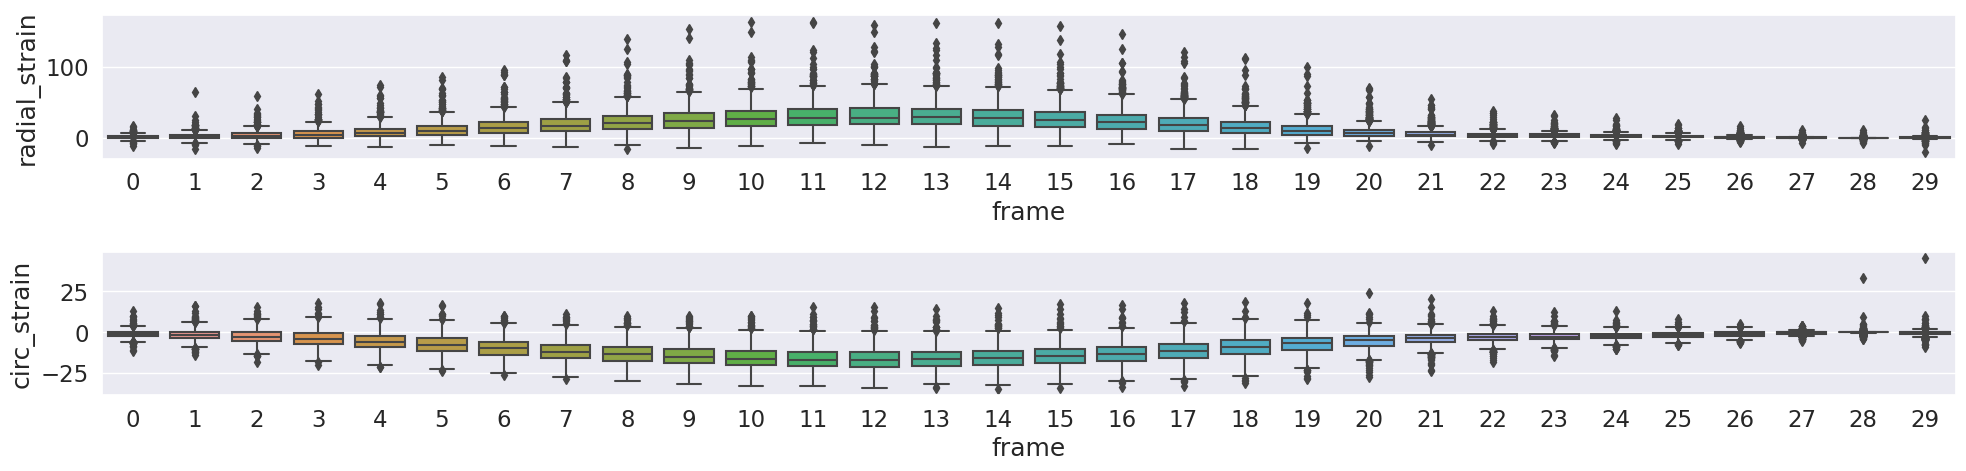

In [5]:
sb.set_context('paper')
sb.set(font_scale = 1.5)
fig, (ax, ax1) = plt.subplots(2,1,figsize=(20,5))
sb.boxplot(x="frame", y="radial_strain",
                 data=df_melt,
              ax=ax)

sb.boxplot(x="frame", y="circ_strain",
                 data=df_melt,
              ax=ax1)
plt.tight_layout()
plt.show()

In [6]:
# load meta
path_to_df_meta = '/mnt/ssd/data/dmd/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase.csv'
df_meta = pd.read_csv(path_to_df_meta)
df_meta = df_meta.loc[:, ~df_meta.columns.str.contains('^Unnamed')]
df_meta['patient'] = df_meta['patient'].str.lower().str.ljust(11, '0')
df_meta.head()

Participant Number             Name  \
0                 1.0  AC_20180301_DMD   
1                 2.0  AA_20181211_DMD   
2                 3.0  AO_20191212_DMD   
3                 4.0  AA_20180710_DMD   
4                 5.0  AB_20180710_DMD   

  Tarique -visual wall motion abnormality? AHA segments  \
0                                        Y   9, 10 , 11   
1                                        Y           11   
2                                        N            0   
3                                        N            0   
4                                        Y           11   

  Tarique -strain abnormality? AHA segment from strain if different  \
0                            Y                                    0   
1                            N                                    0   
2                            Y                                   10   
3                            N                                    0   
4                            Y                                    0   

   Unique ID           Study Date  Age at MRI Gender  ...  Steroid use (y/n)  \
0  8381562.0  2018-03-01 00:00:00   12.344444      M  ...                  Y   
1  2073764.0  2018-12-11 00:00:00    8.788889      M  ...                  Y   
2  5381412.0  2019-12-12 00:00:00   15.852778      M  ...                  Y   
3  6223189.0  2018-07-10 00:00:00    9.566667      M  ...                  Y   
4  2883132.0  2018-07-10 00:00:00   12.950000      M  ...                  Y   

   Use of any ACE-I/ ARB/ MRA/ beta-blockers (y/n)  ACE-I use?   ARB use?  \
0                                                Y            Y         N   
1                                                Y            Y         N   
2                                                Y            Y         N   
3                                                Y            Y         N   
4                                                Y            Y         N   

   MRA use?  Beta-blocker use?    Specific Steroid and Dose  \
0         Y                  N                prednisone 20   
1         N                  N  prednisone 60 Fri, Sat, Sun   
2         Y                  Y                prednisone 15   
3         N                  Y       prednisone 60, Fri-Sun   
4         N                  N        prednisone 70 Fri-Sun   

                              ACE-I/ARB/BB/MRA doses  \
0               enalipril 2.5 BID, sprionolactone 25   
1                                      lisinopril 10   
2  spironolactone 50, lisinopril 10, carvedilol 3...   
3                    carvedilol 6.25, lisiniopril 10   
4                                      lisinopril 20   

                                   Other Medications      patient  
0  ranitidine 150mg, Vit D3 5000 units, albuterol...  ac_20180301  
1                                    VitD 4000 units  aa_20181211  
2  famotidine 10 BID, VitD3 6000 units, sertralin...  ao_20191212  
3    ranitidine 150 Fri-Sun, Vit D3 4000 units daily  aa_20180710  
4                   esomeprazole 10, Vit D3 2000 BID  ab_20180710  

[5 rows x 52 columns]

In [7]:
df_merged = pd.merge(left=df_melt, right=df_meta, how='left', left_on='pat', right_on='patient')
df_merged['target'] = df_merged['LGE present? (y/n)']
df_merged.head()

pat  aha frame  radial_strain  circ_strain  Participant Number  \
0  aa_20180710    1     0          2.039       -2.433                 4.0   
1  aa_20180710    2     0          5.273       -3.247                 4.0   
2  aa_20180710    3     0         -0.020        1.799                 4.0   
3  aa_20180710    4     0          1.311       -0.911                 4.0   
4  aa_20180710    5     0         -0.322       -0.343                 4.0   

              Name Tarique -visual wall motion abnormality? AHA segments  \
0  AA_20180710_DMD                                        N            0   
1  AA_20180710_DMD                                        N            0   
2  AA_20180710_DMD                                        N            0   
3  AA_20180710_DMD                                        N            0   
4  AA_20180710_DMD                                        N            0   

  Tarique -strain abnormality?  ...  \
0                            N  ...   
1                            N  ...   
2                            N  ...   
3                            N  ...   
4                            N  ...   

  Use of any ACE-I/ ARB/ MRA/ beta-blockers (y/n)  ACE-I use?  ARB use?  \
0                                               Y            Y        N   
1                                               Y            Y        N   
2                                               Y            Y        N   
3                                               Y            Y        N   
4                                               Y            Y        N   

   MRA use? Beta-blocker use?  Specific Steroid and Dose  \
0         N                 Y     prednisone 60, Fri-Sun   
1         N                 Y     prednisone 60, Fri-Sun   
2         N                 Y     prednisone 60, Fri-Sun   
3         N                 Y     prednisone 60, Fri-Sun   
4         N                 Y     prednisone 60, Fri-Sun   

            ACE-I/ARB/BB/MRA doses  \
0  carvedilol 6.25, lisiniopril 10   
1  carvedilol 6.25, lisiniopril 10   
2  carvedilol 6.25, lisiniopril 10   
3  carvedilol 6.25, lisiniopril 10   
4  carvedilol 6.25, lisiniopril 10   

                                 Other Medications      patient  target  
0  ranitidine 150 Fri-Sun, Vit D3 4000 units daily  aa_20180710       N  
1  ranitidine 150 Fri-Sun, Vit D3 4000 units daily  aa_20180710       N  
2  ranitidine 150 Fri-Sun, Vit D3 4000 units daily  aa_20180710       N  
3  ranitidine 150 Fri-Sun, Vit D3 4000 units daily  aa_20180710       N  
4  ranitidine 150 Fri-Sun, Vit D3 4000 units daily  aa_20180710       N  

[5 rows x 58 columns]

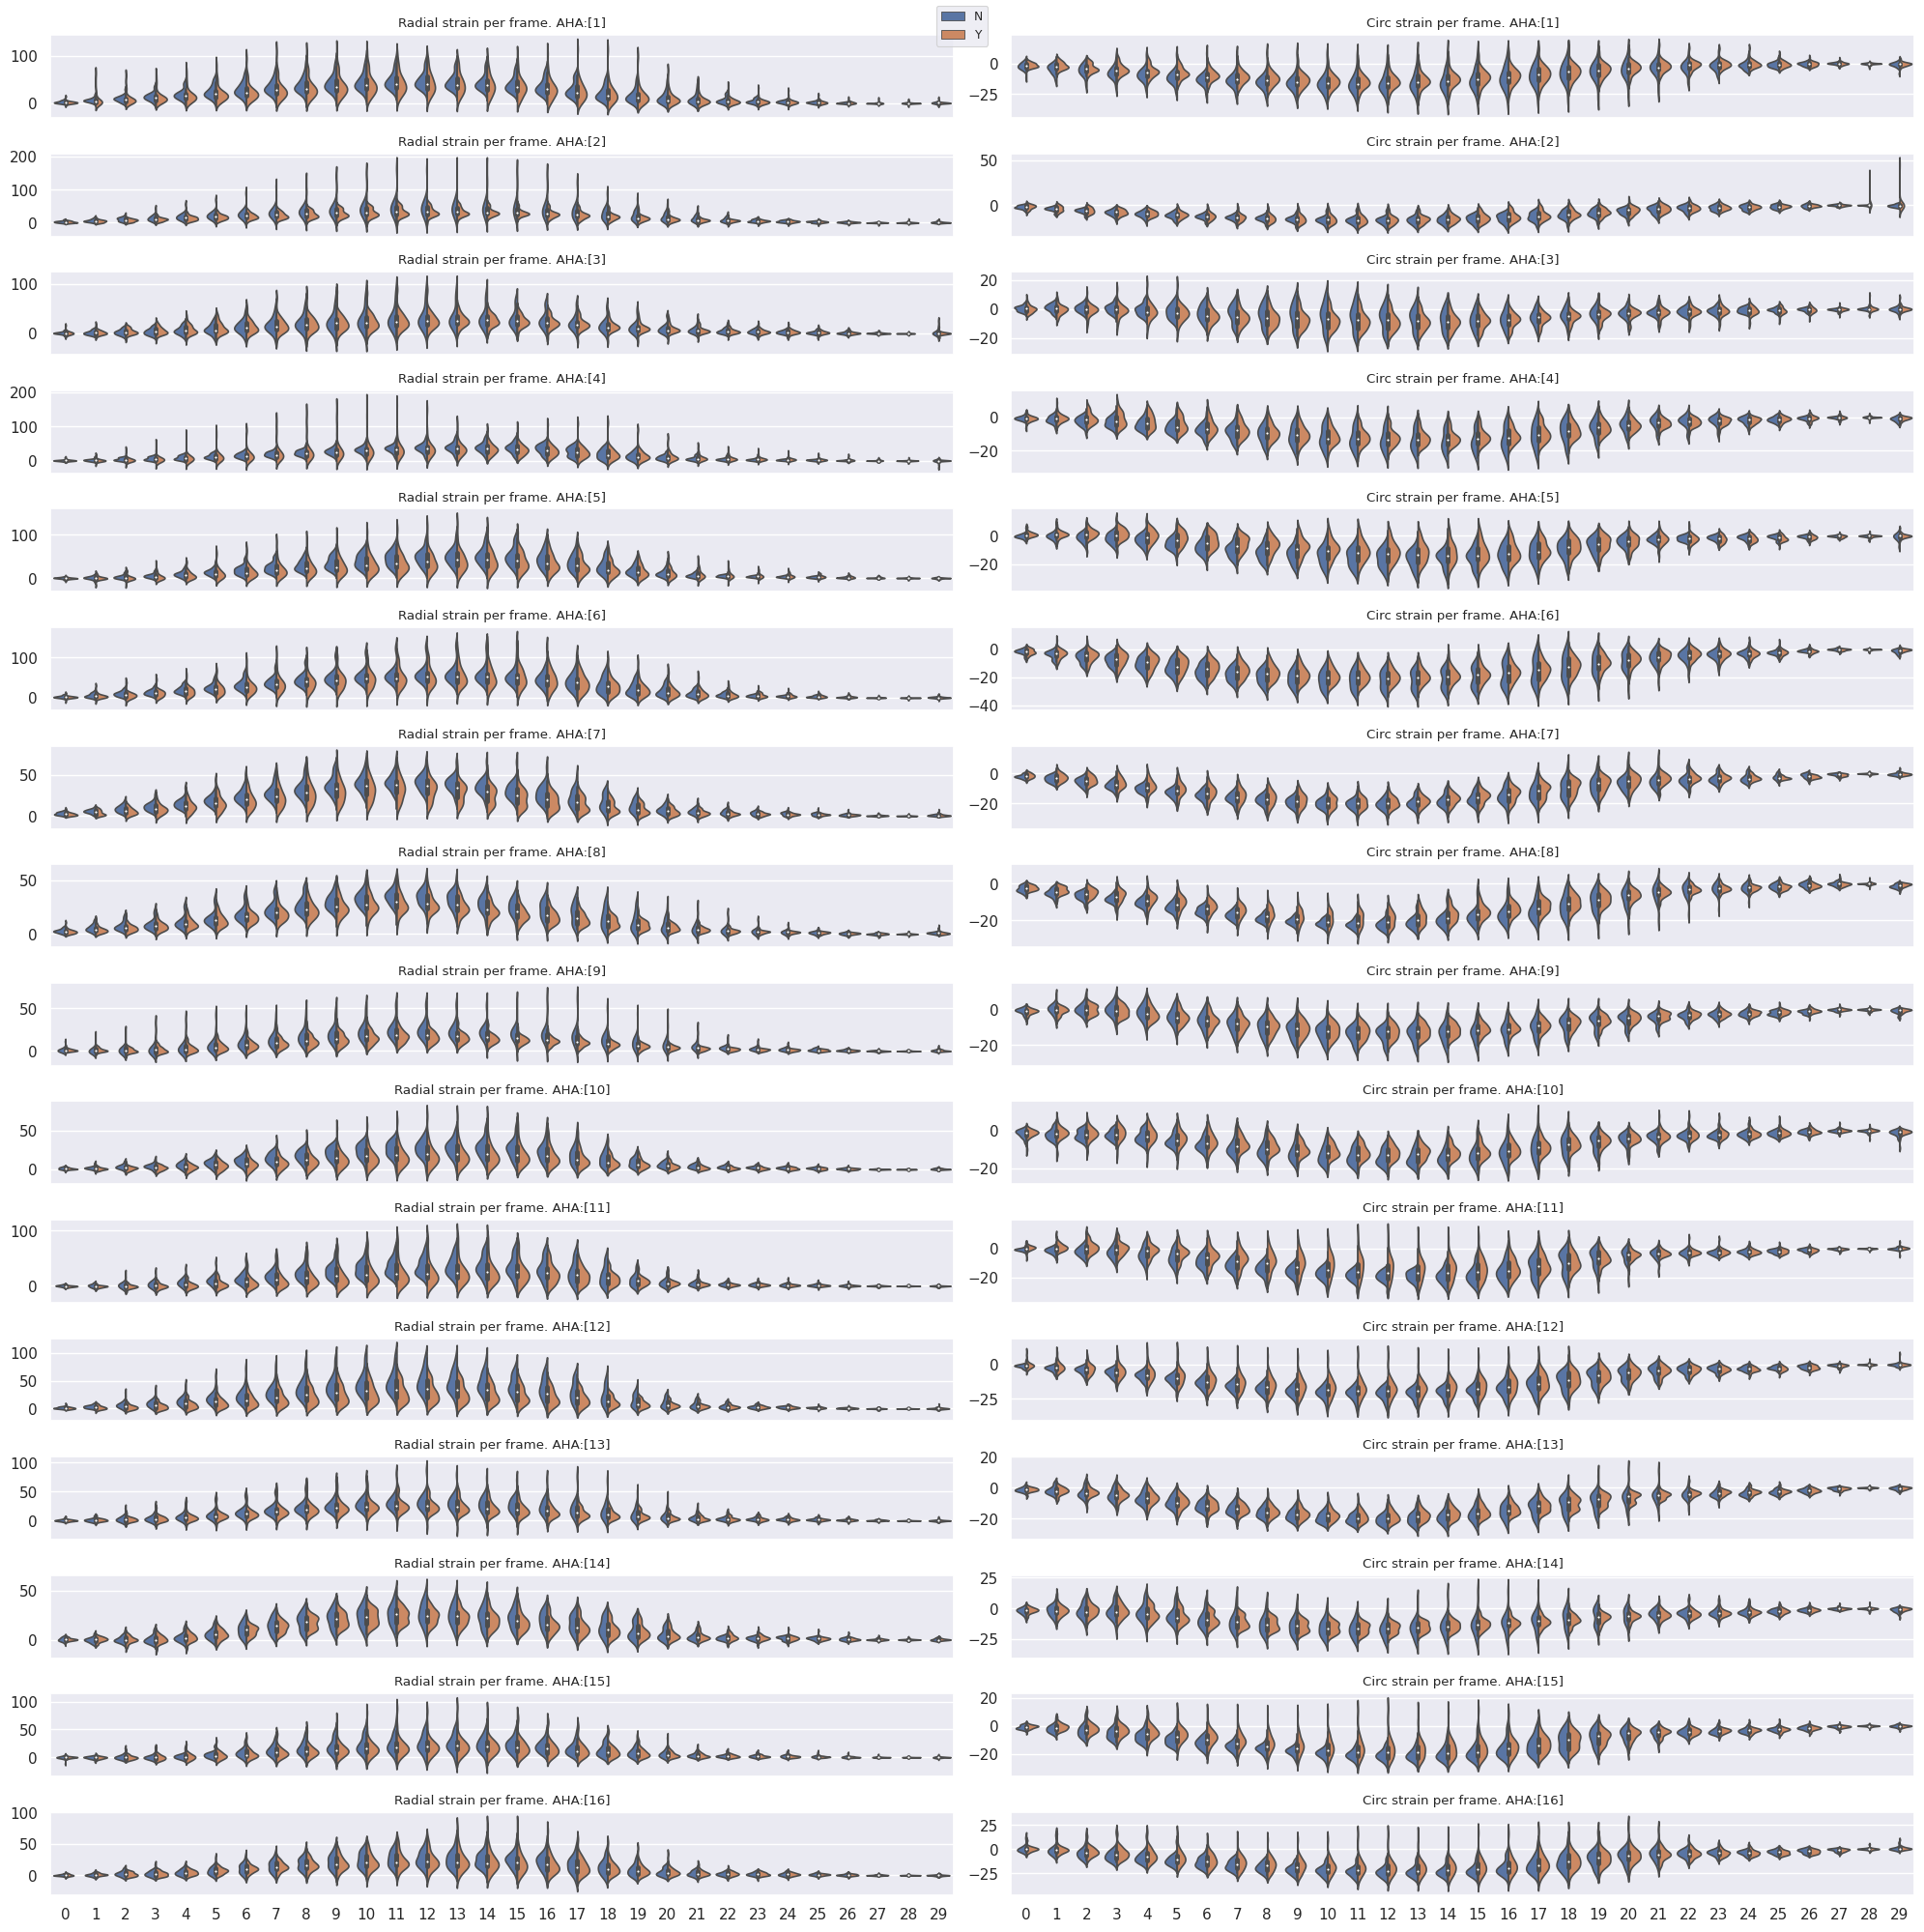

In [243]:
def plot_strain(df, segments=[1], ax=None, ax1=None, show_xlabel=False):
    sb.set_context('paper')
    #sb.set(font_scale = 1.5)
    if ax is None:
        fig, (ax, ax1) = plt.subplots(1,2,figsize=(20,4))
    ax.set_title('Radial strain per frame. AHA:{}'.format(segments))
    ax1.set_title('Circ strain per frame. AHA:{}'.format(segments))
    g1 = sb.violinplot(x="frame", y='radial_strain',
                     data=df[df['aha'].isin(segments)],
                  ax=ax,
                 hue='target',
                 split=True, legend=False)
    g2 = sb.violinplot(x="frame", y='circ_strain',
                     data=df[df['aha'].isin(segments)],
                  ax=ax1,
                 hue='target',
                 split=True)
    
    if show_xlabel:
        pass
    else:
        g1.set(ylabel=None)
        g2.set(ylabel=None)
        g1.set(xlabel=None)
        g2.set(xlabel=None)
        g1.legend([],[],frameon=False)
        g2.legend([],[],frameon=False)
        #g2.set(xticklabels=[])
        #g1.set(xticklabels=[])
    
    
seg_of_interest = 16
sb.set_context('paper')
sb.set(font_scale = 1)
fig, axes = plt.subplots(seg_of_interest,2,figsize=(20,20), sharex=True)
_ = [plot_strain(df_merged, segments=[i], ax=axes[i-1,0], ax1=axes[i-1,1], show_xlabel=i==seg_of_interest+1) for i in range(1,1 + seg_of_interest)]
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.tight_layout()
plt.show()

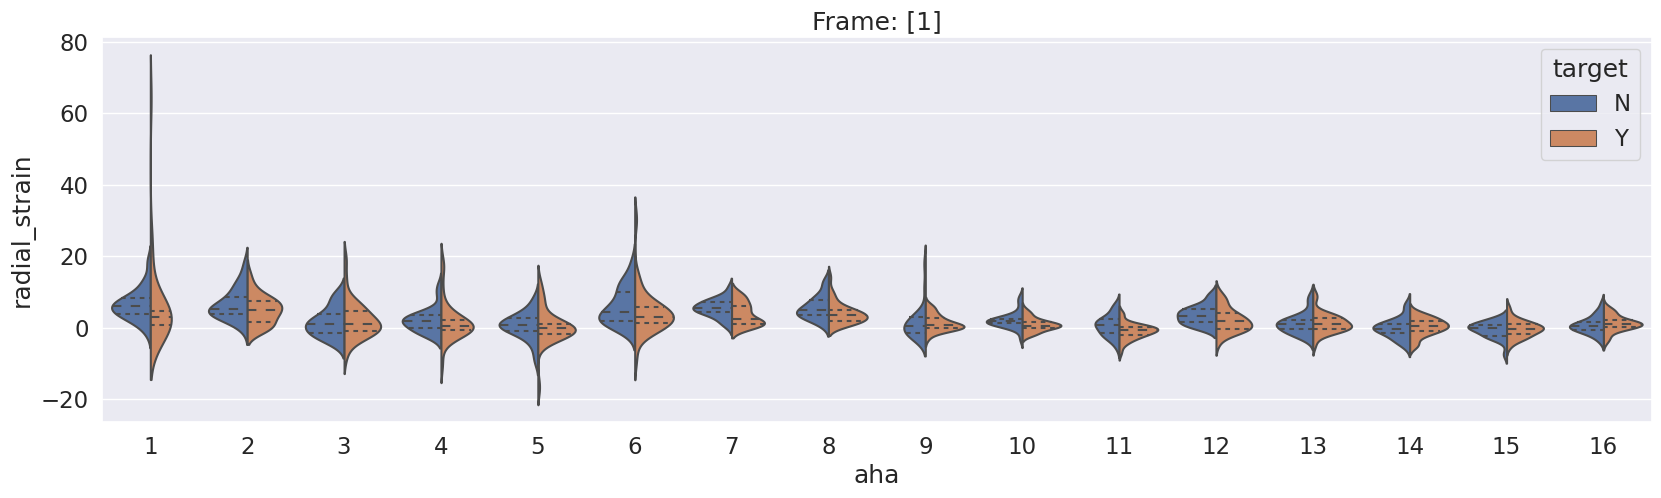

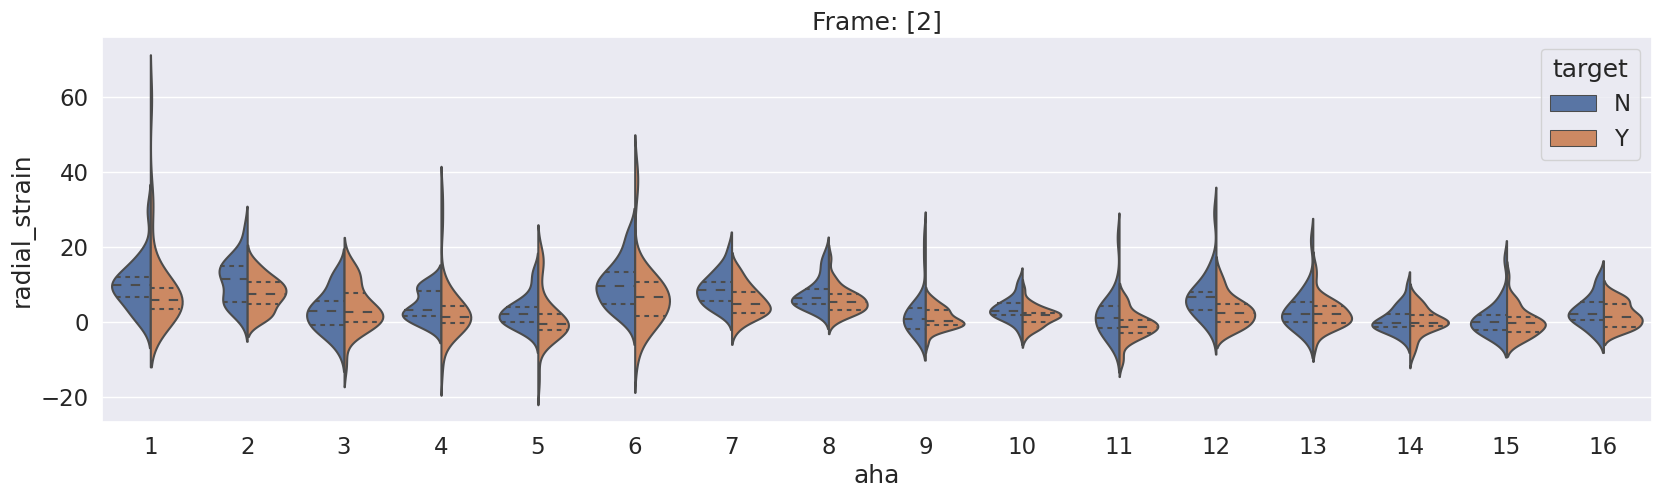

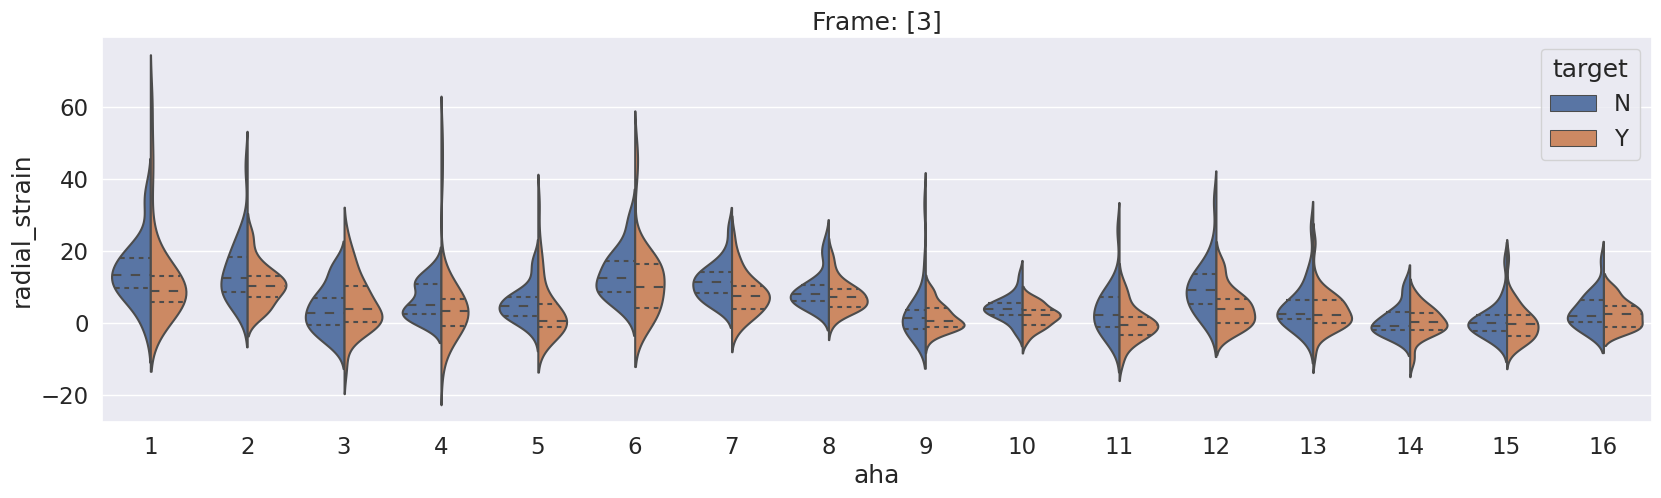

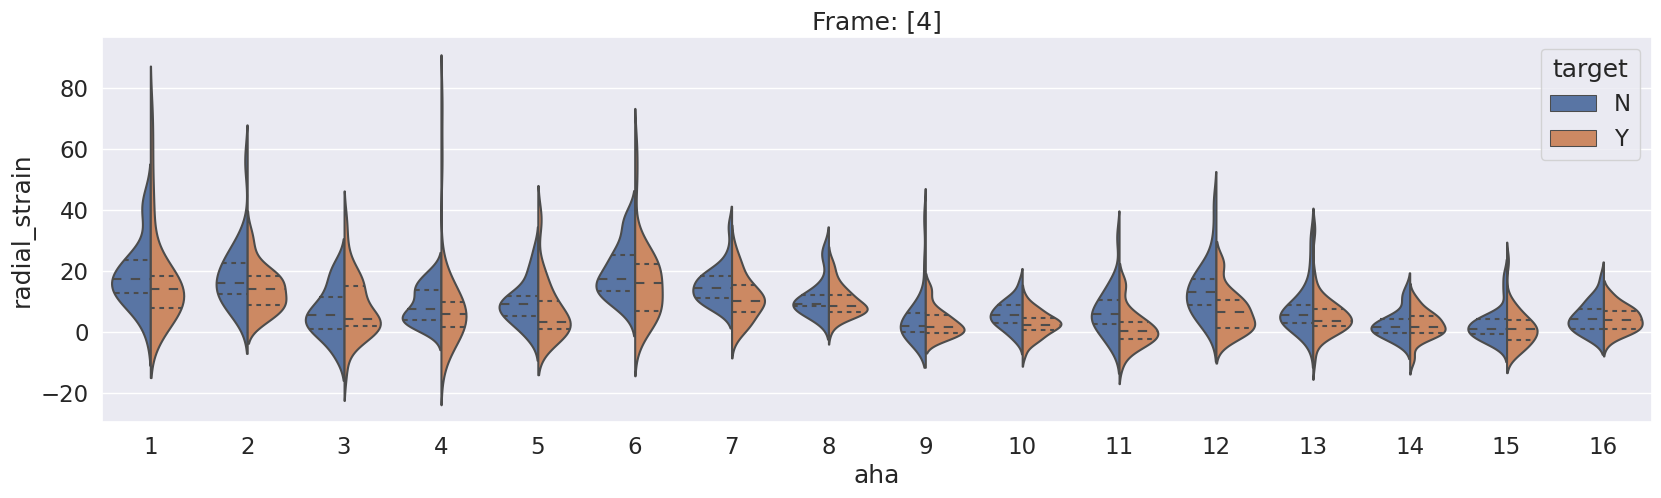

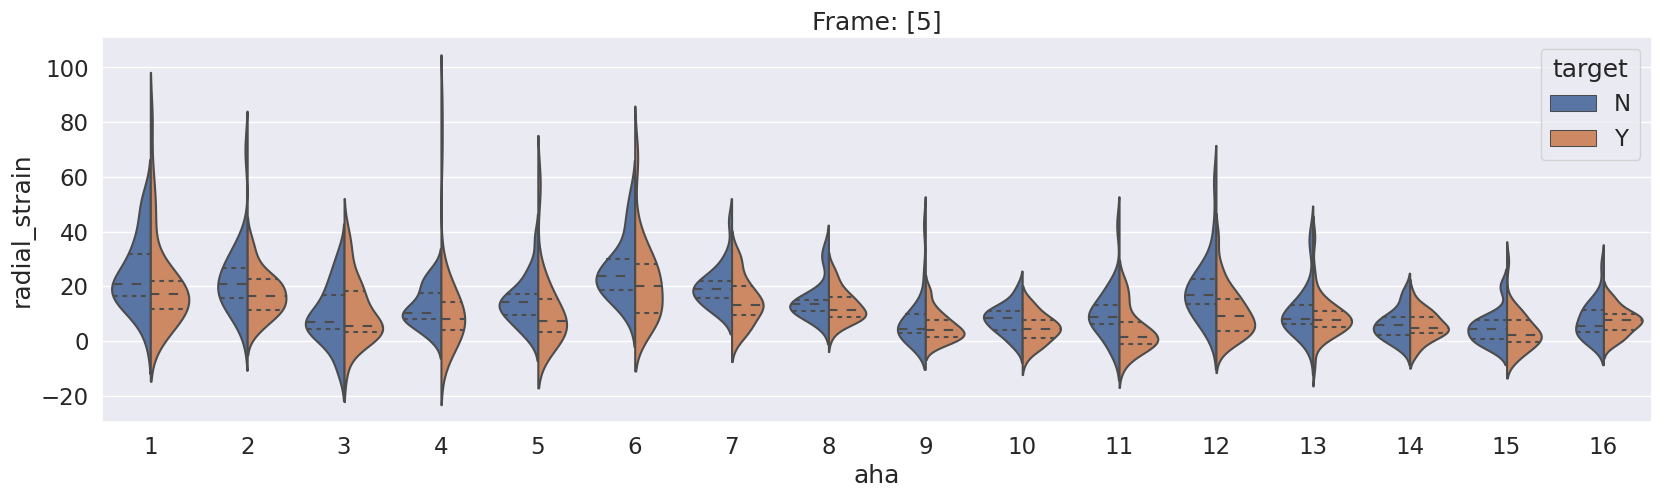

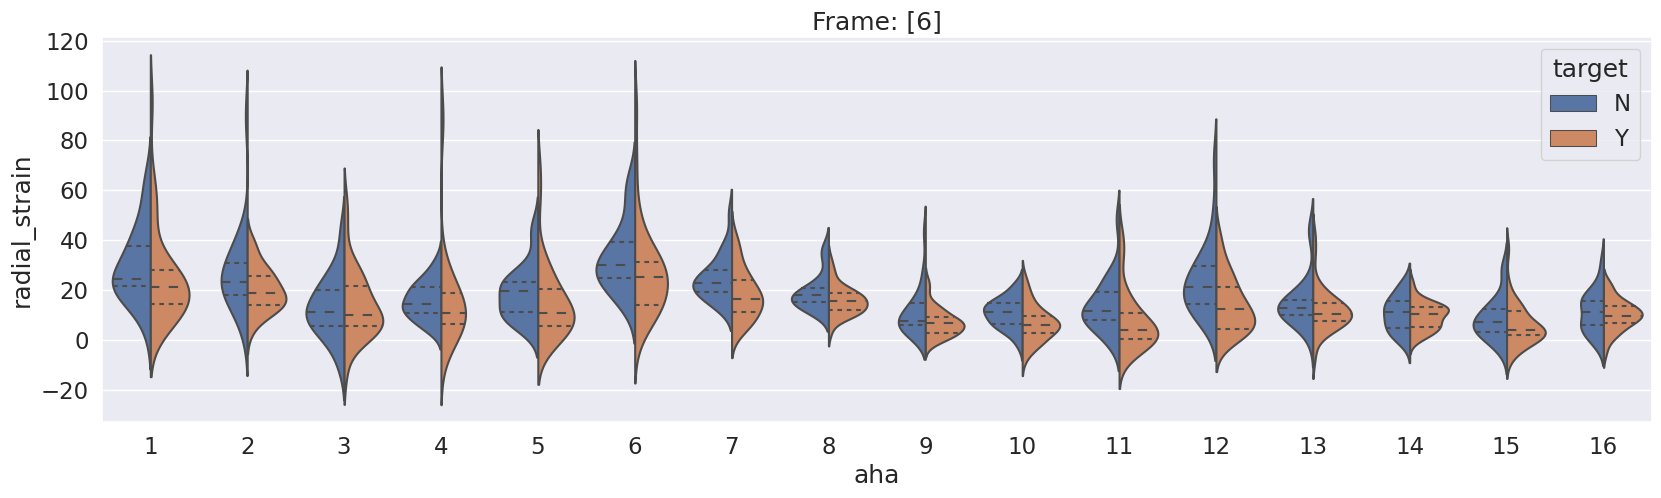

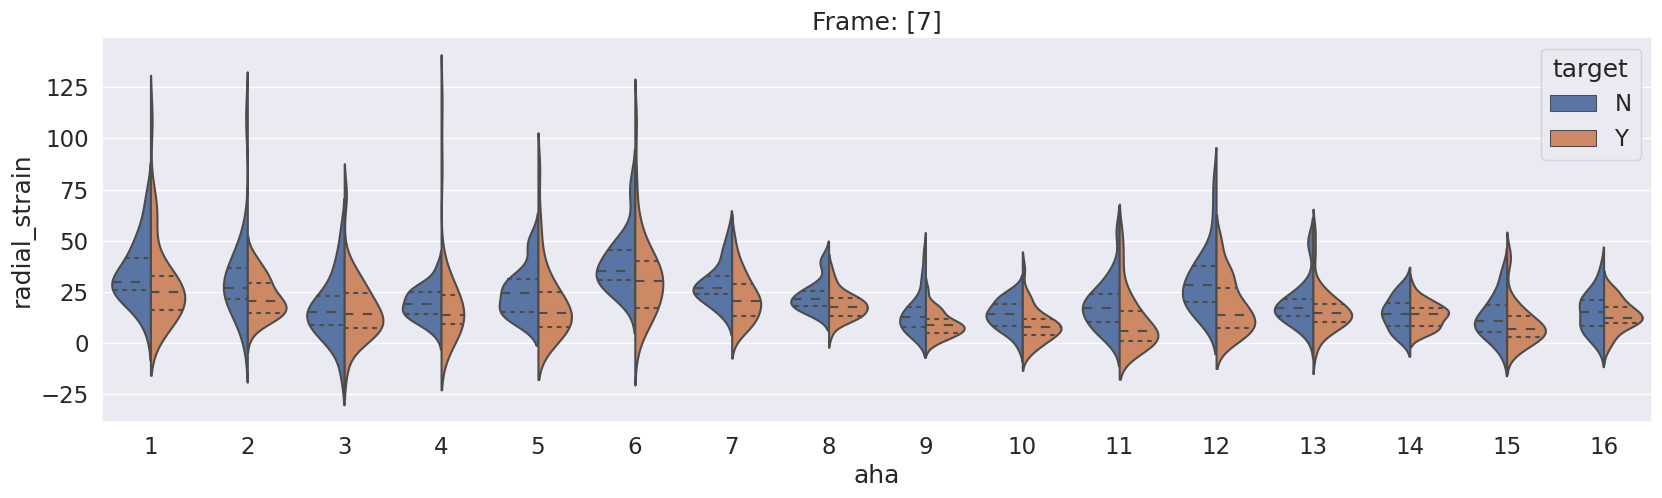

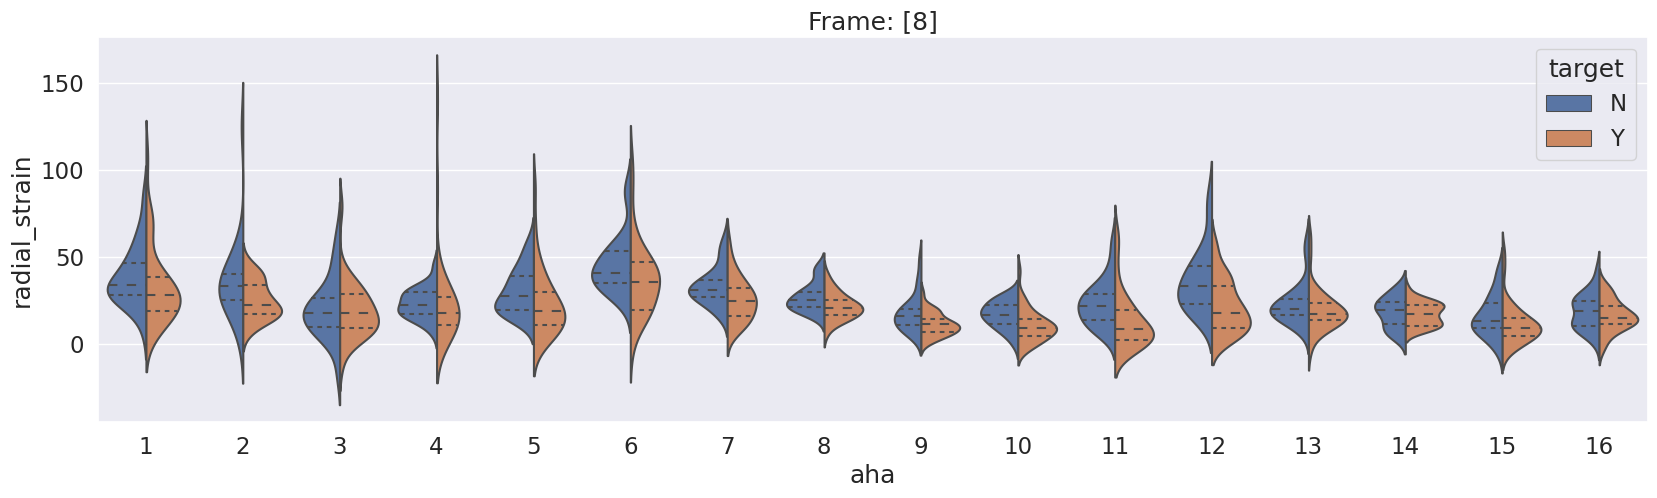

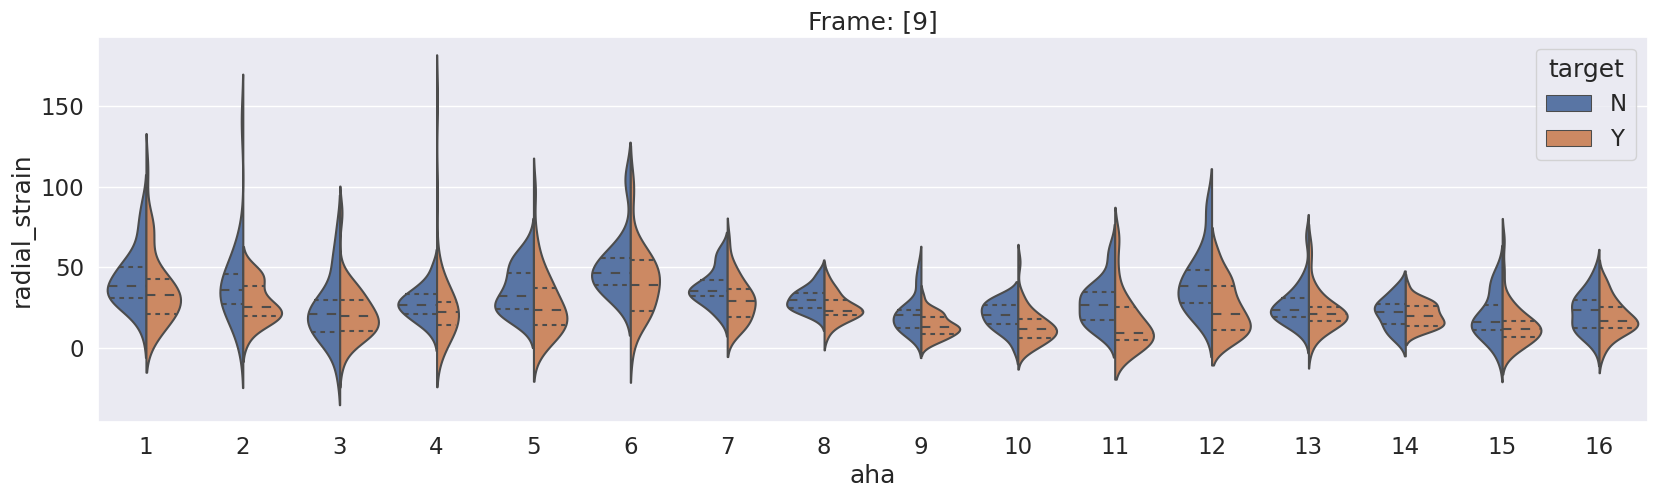

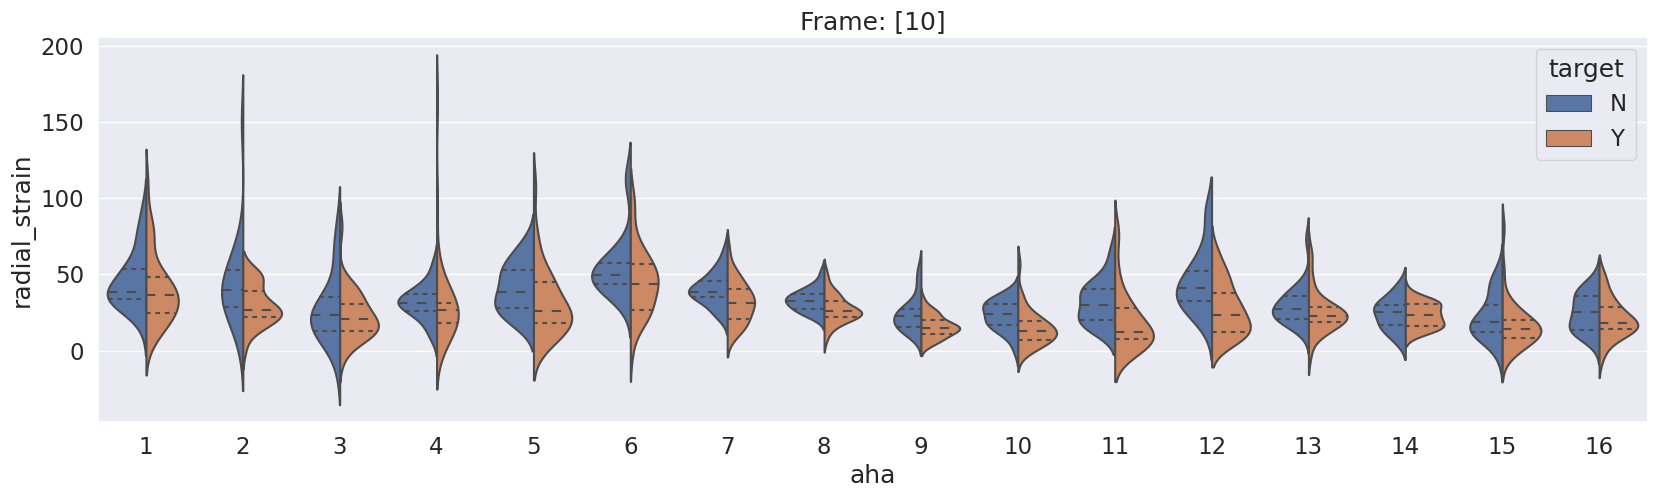

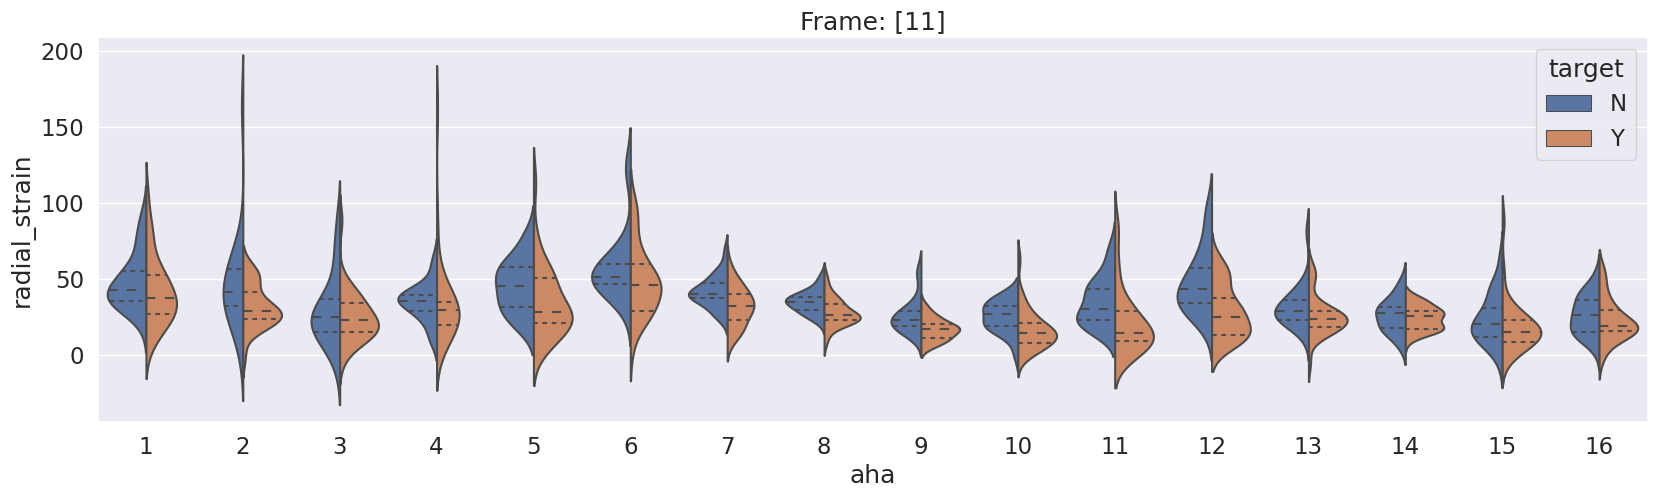

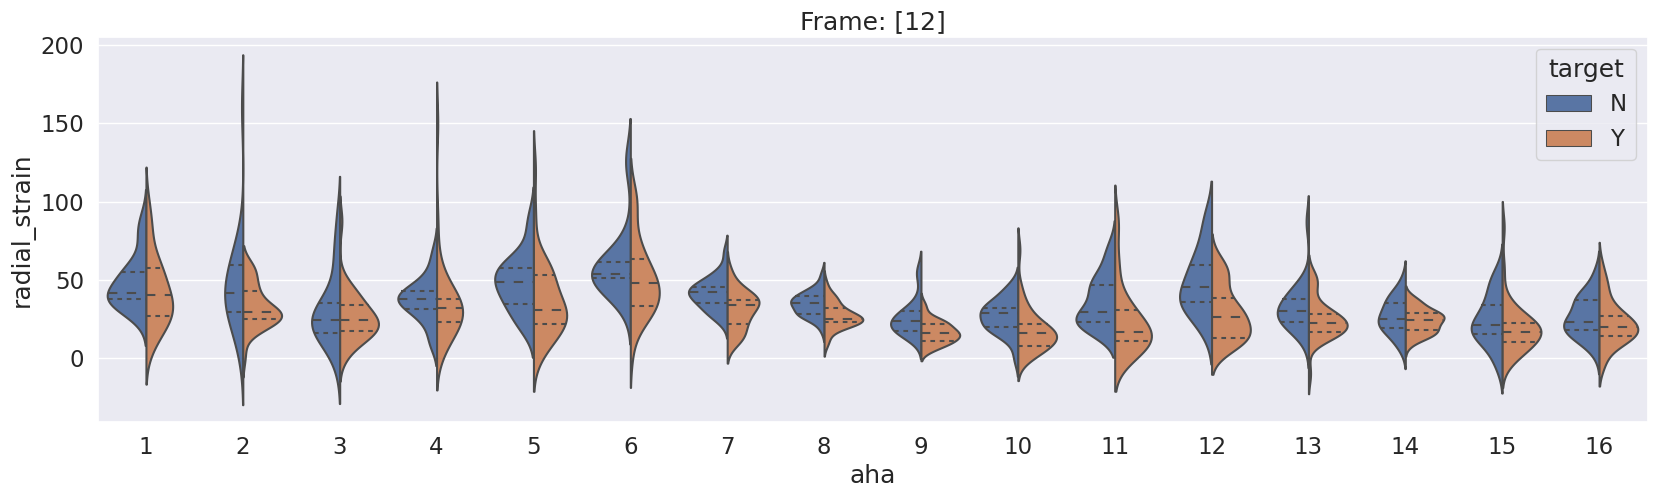

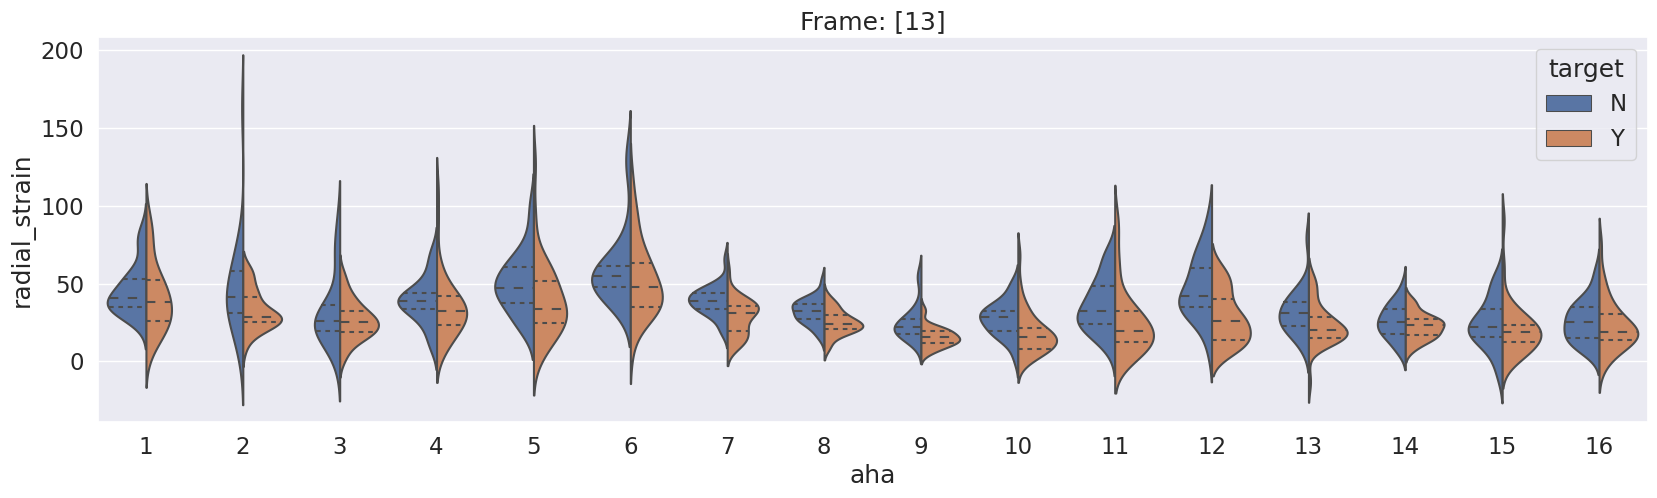

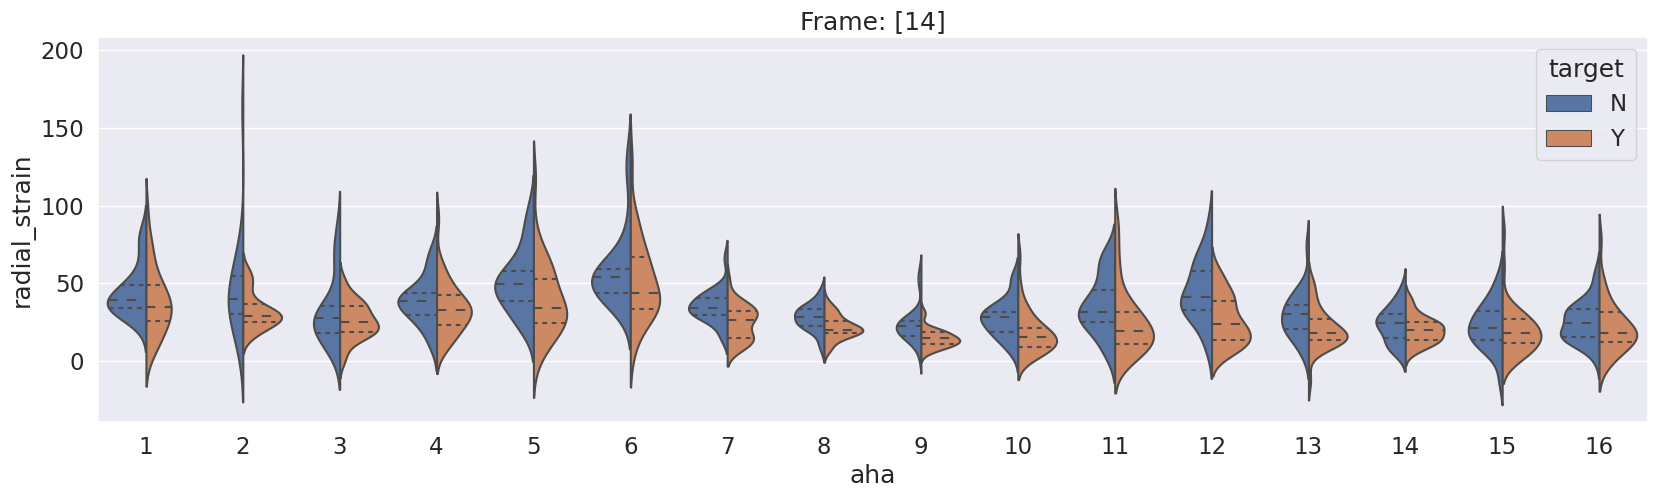

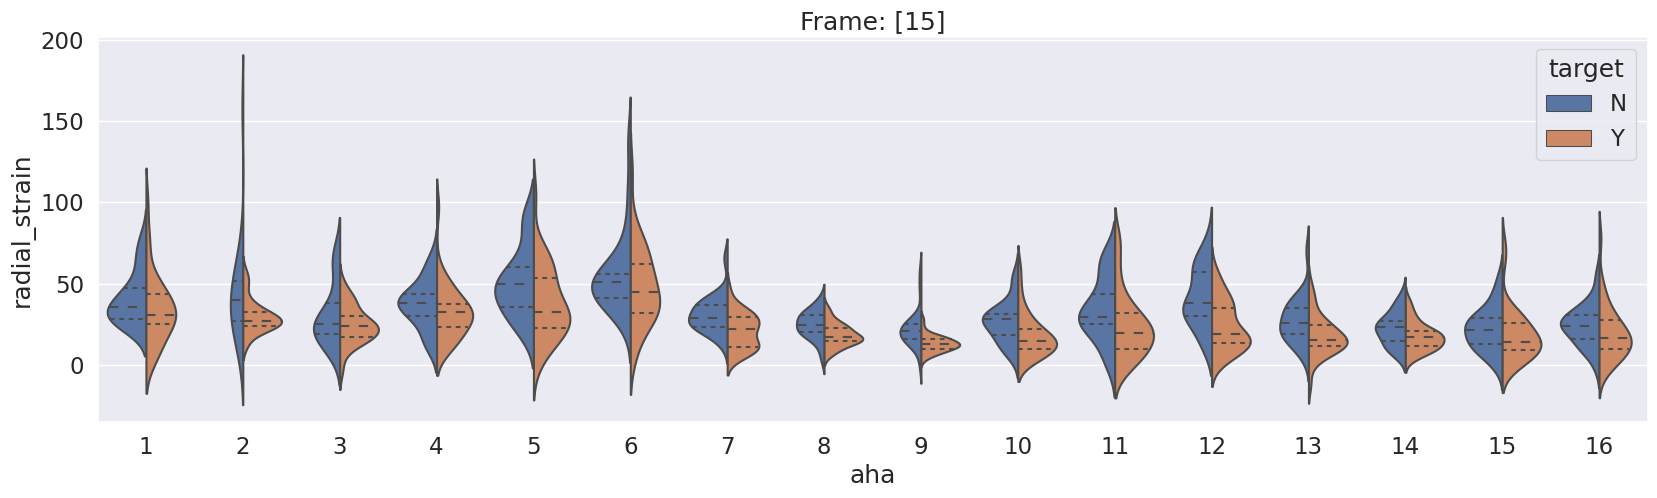

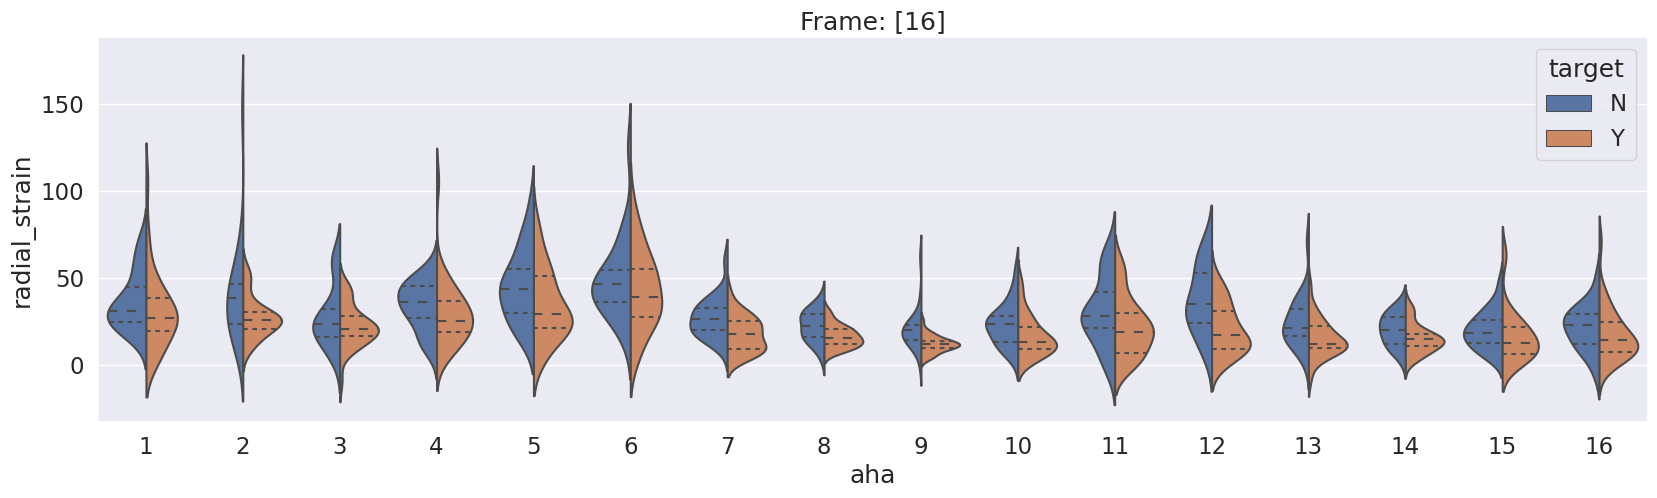

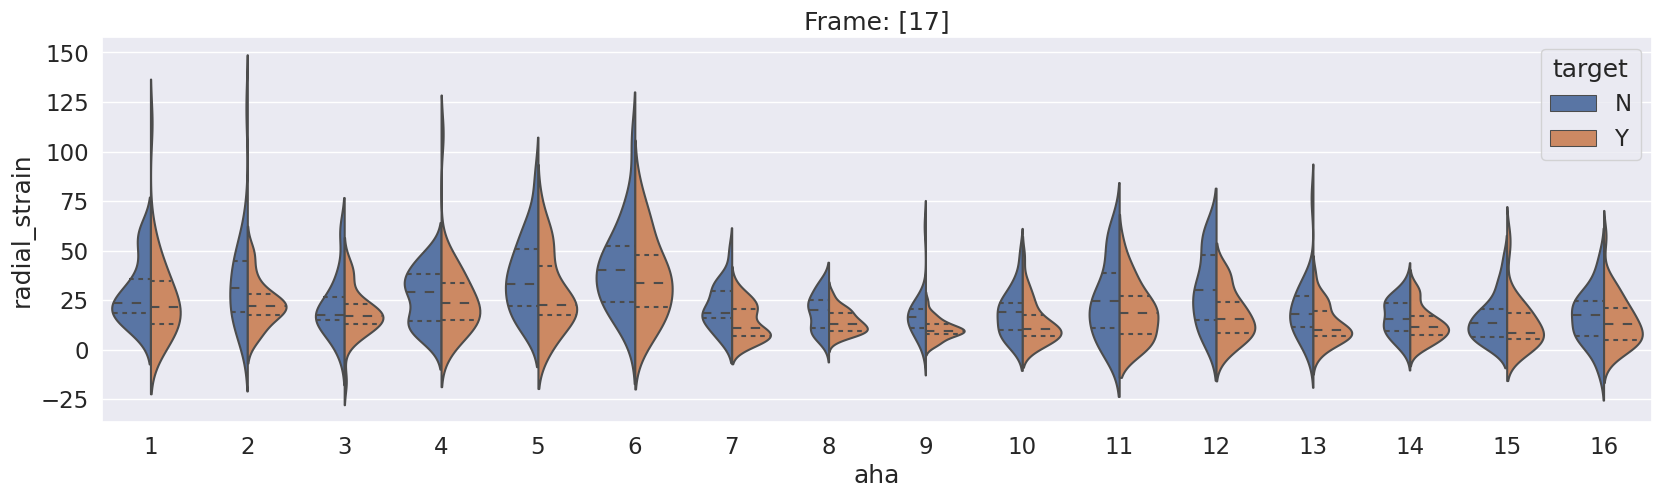

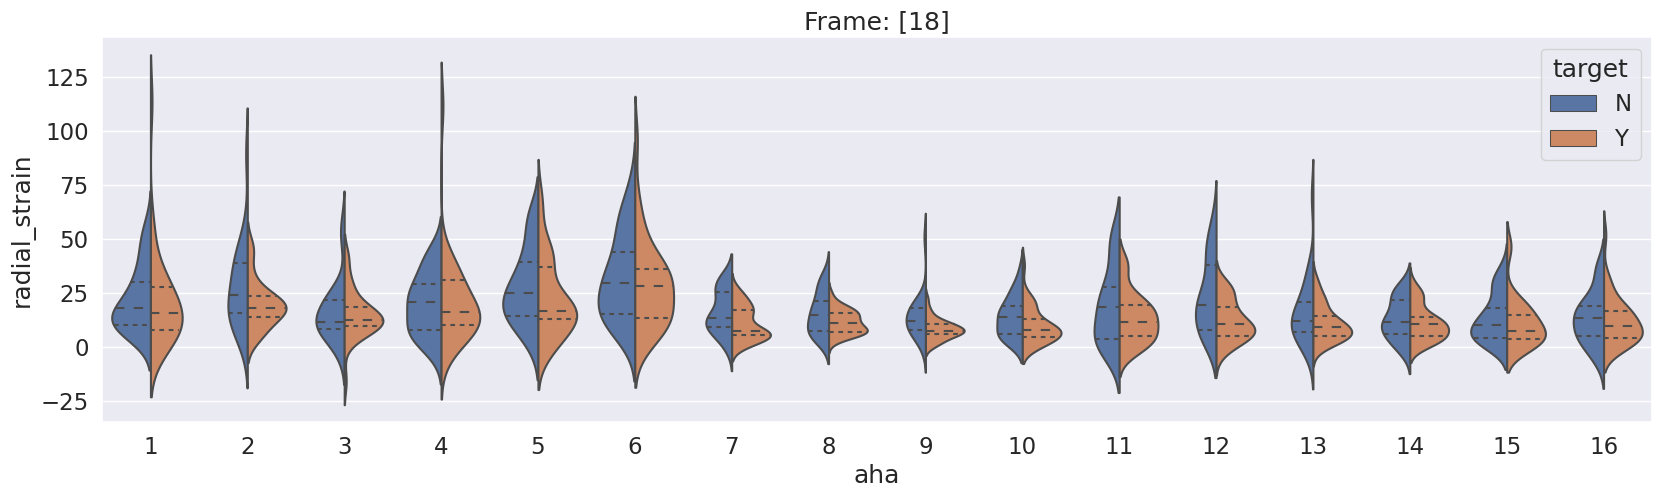

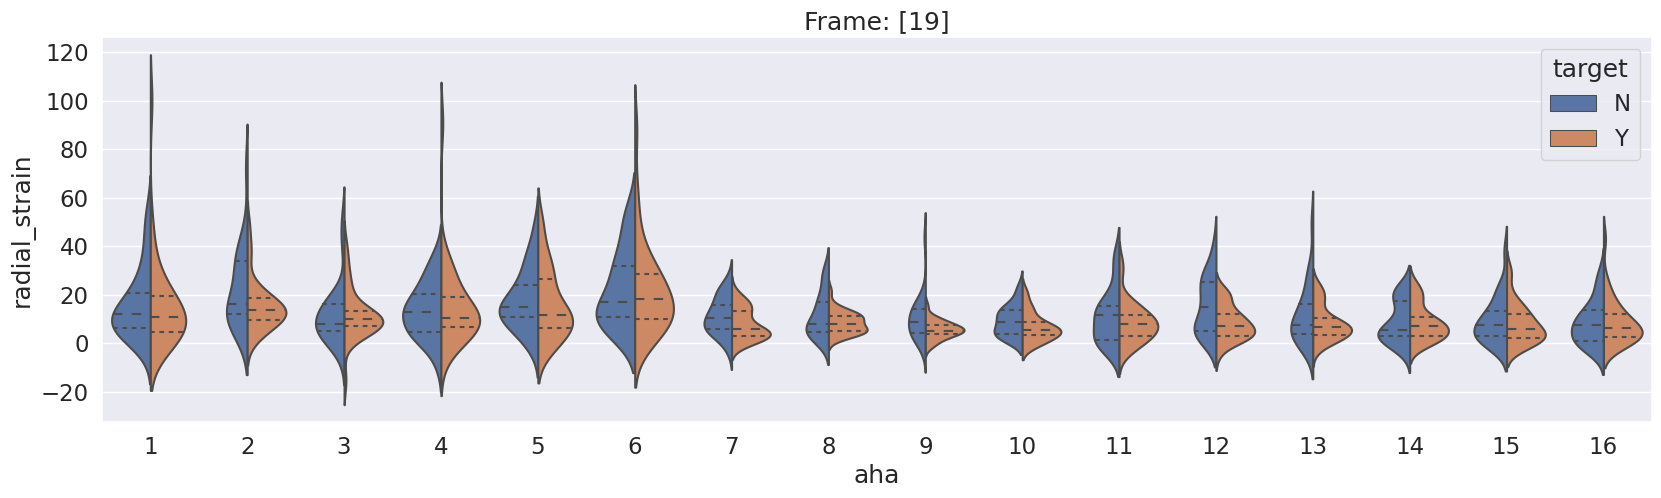

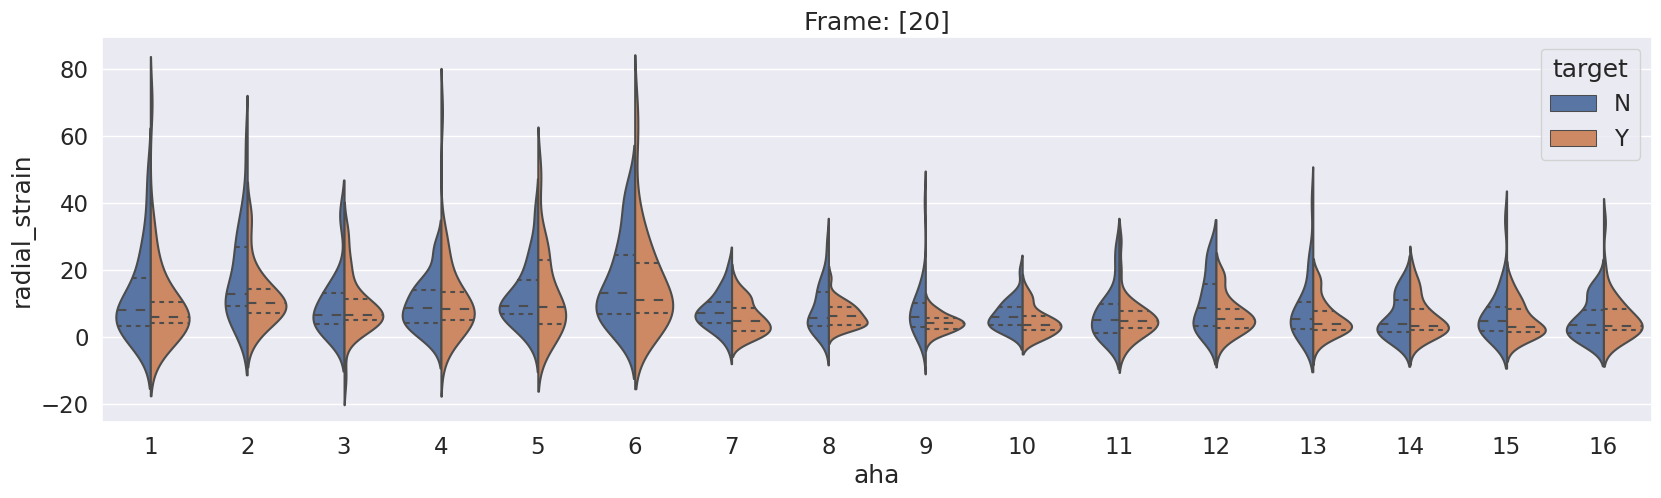

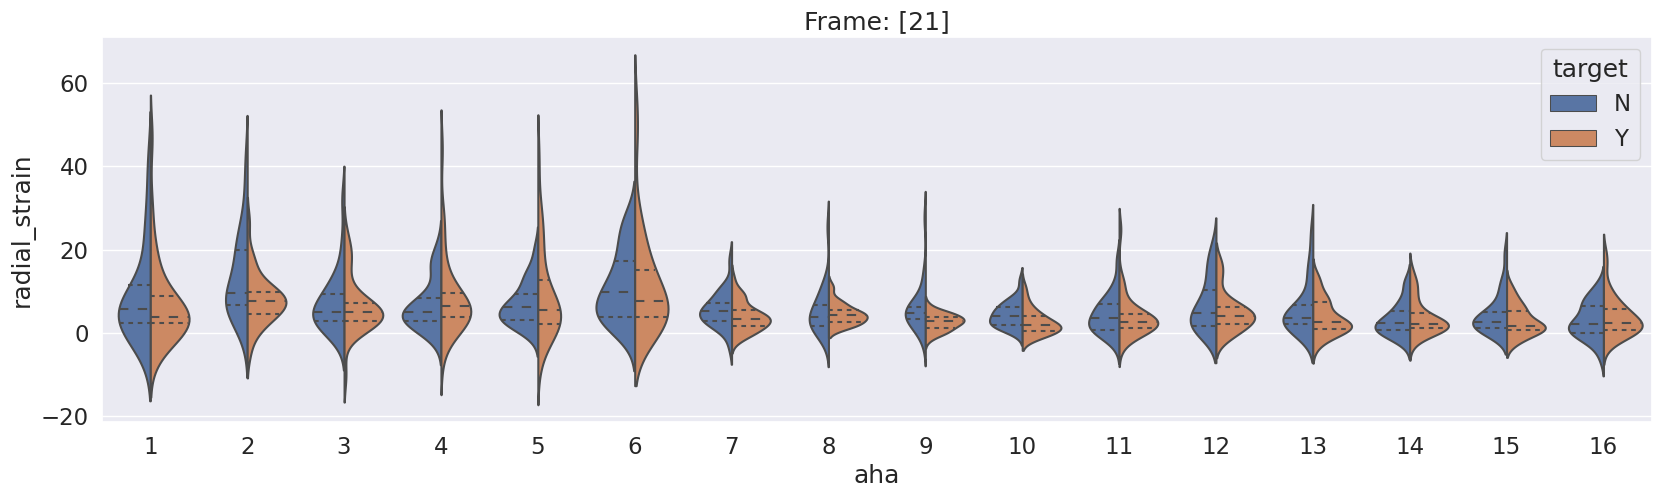

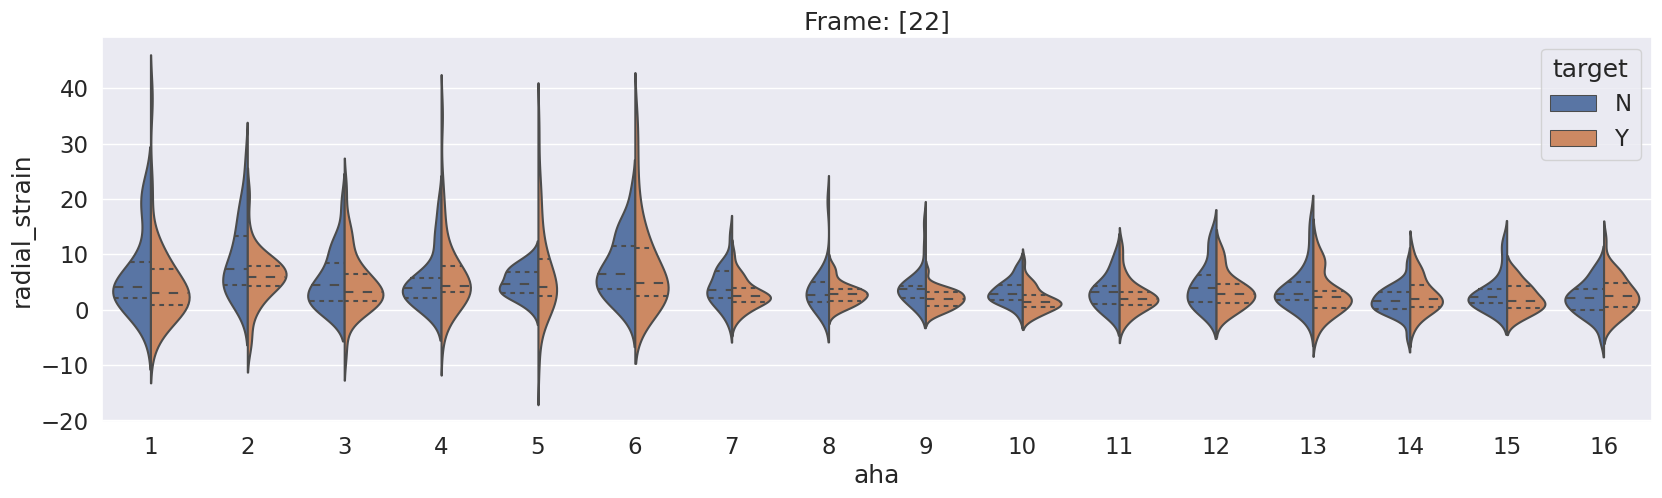

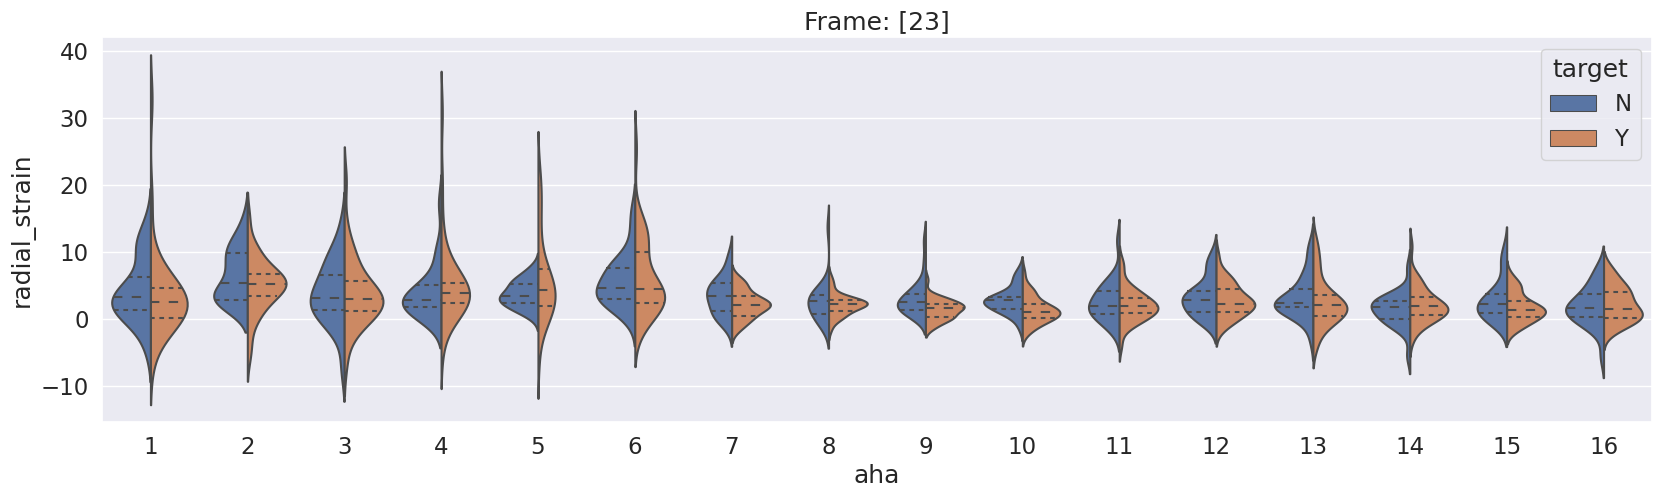

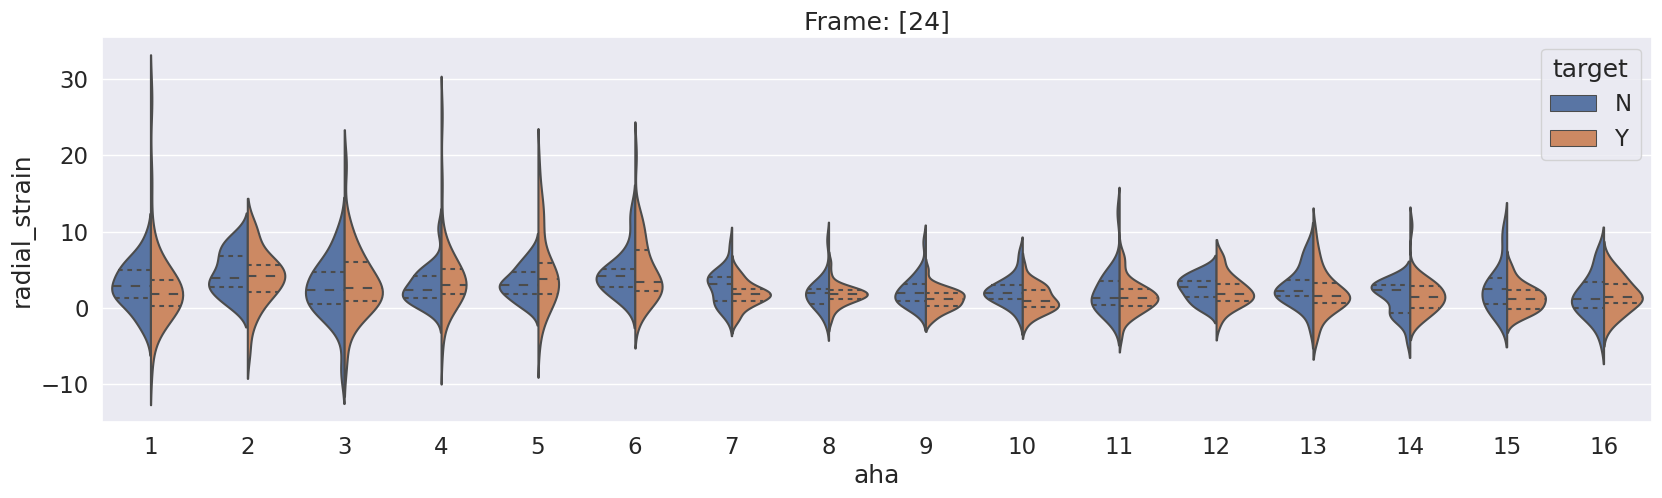

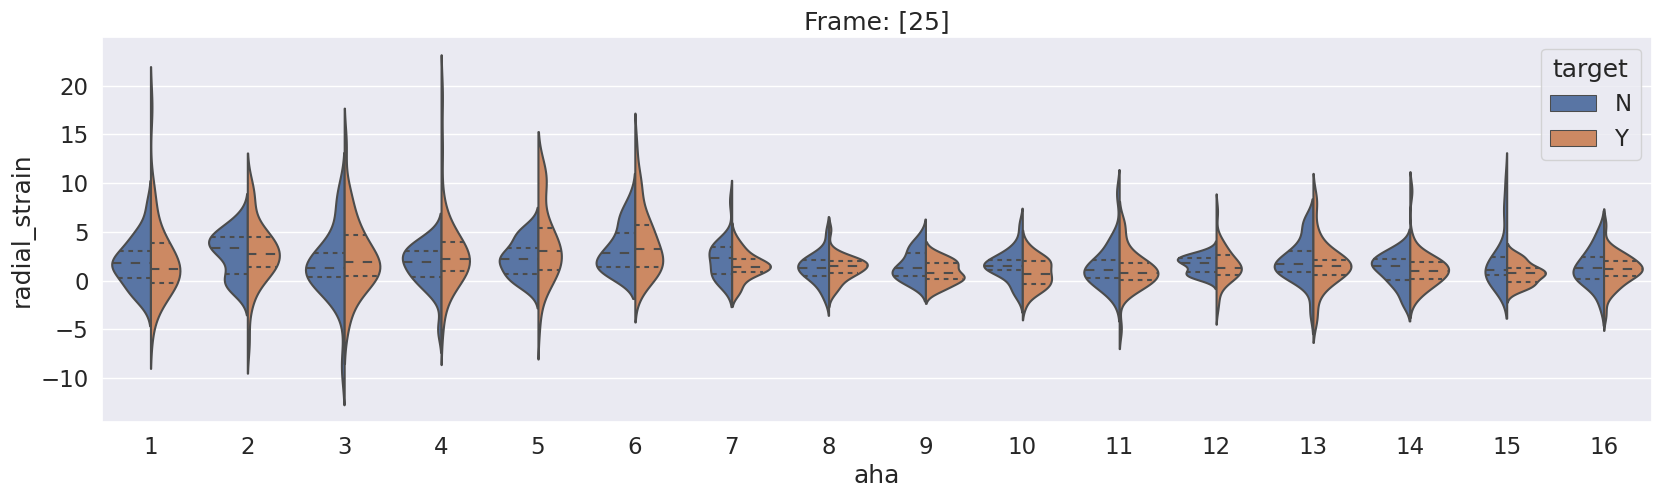

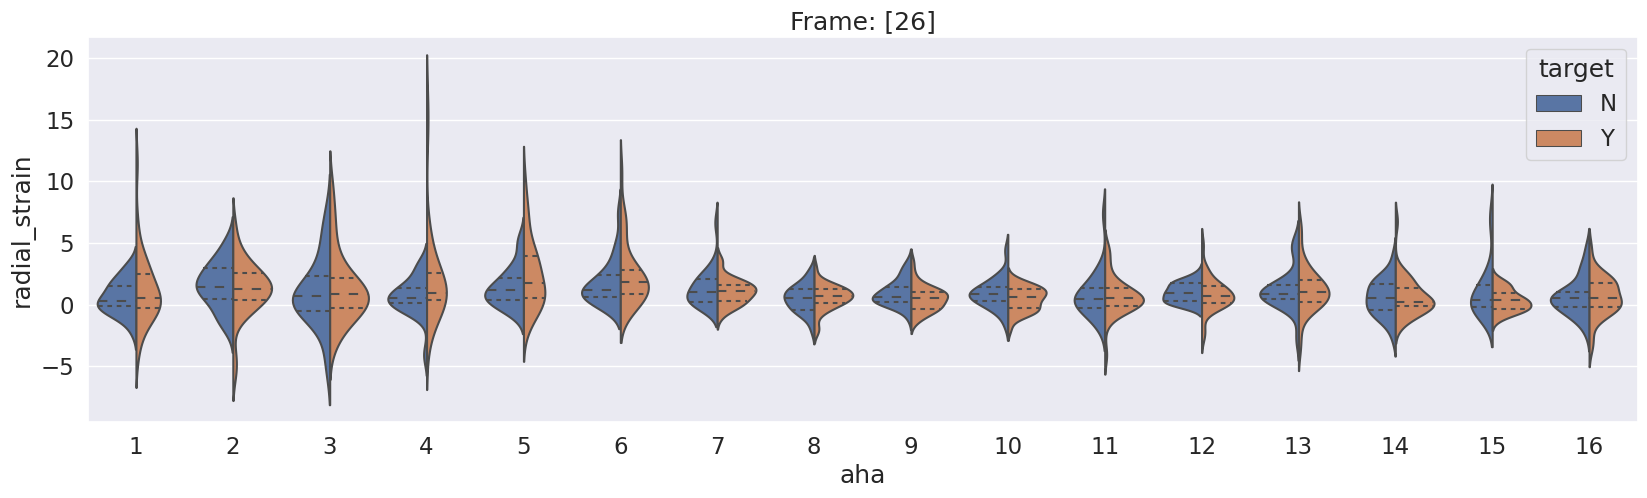

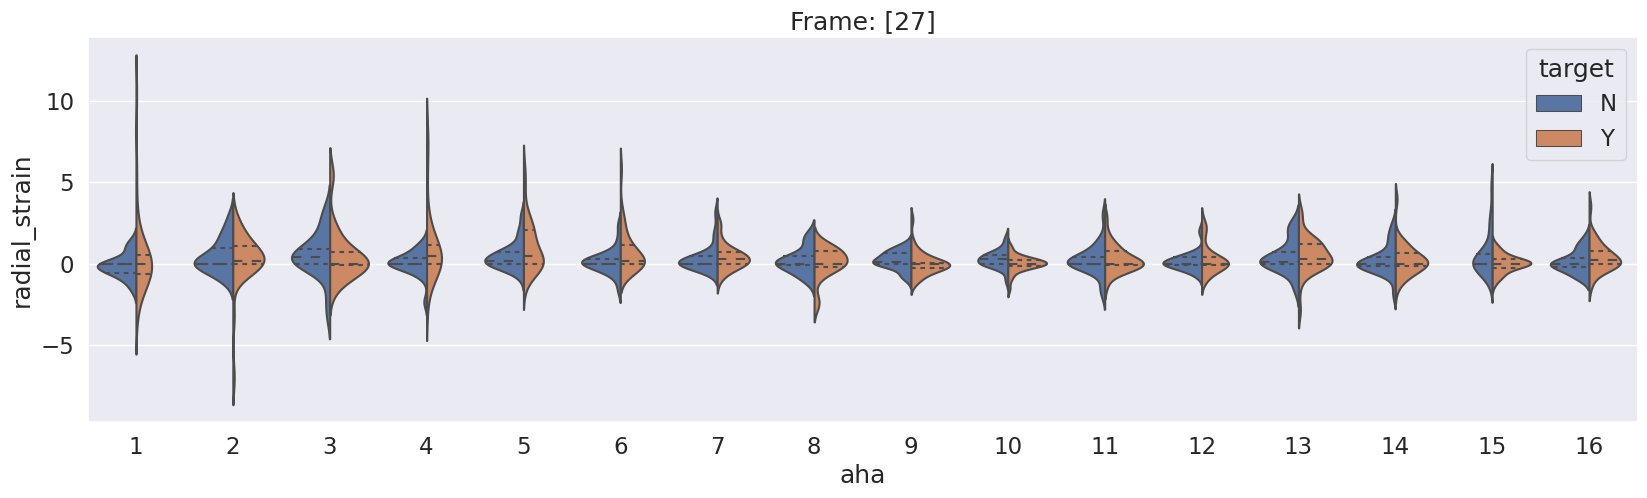

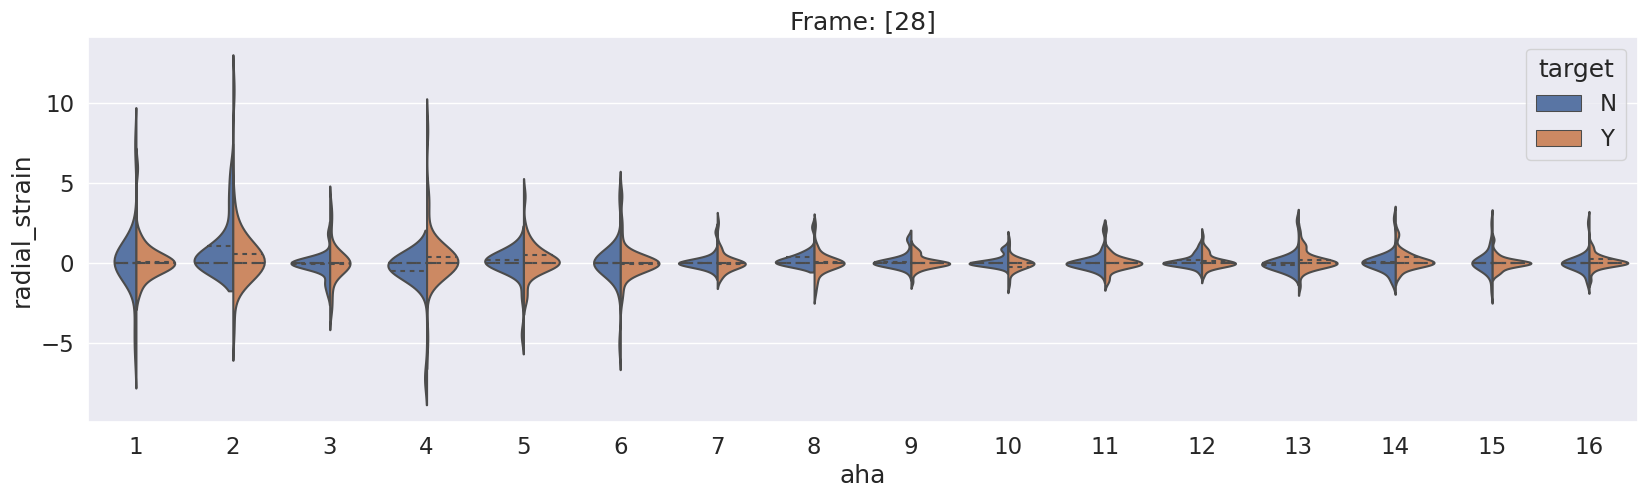

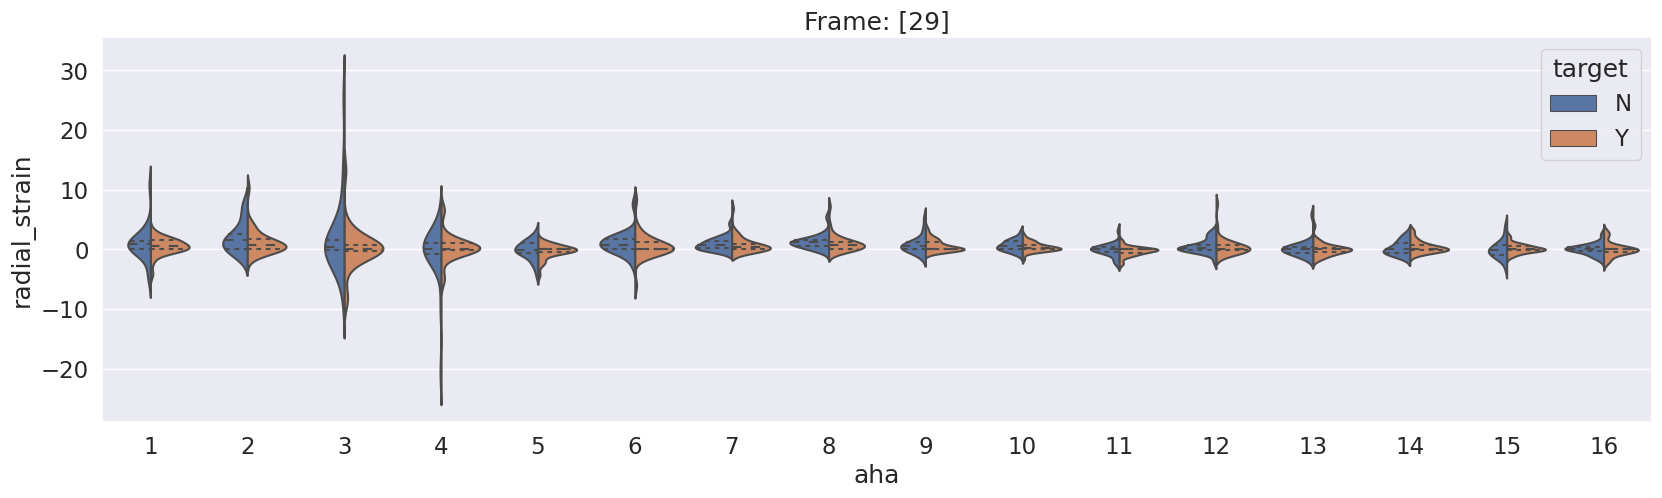

In [41]:
def plot_strain(df, segments=[1]):
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    plt.title('Frame: {}'.format(segments))
    sb.violinplot(x="aha", y="radial_strain",inner='quart',
                     data=df[df['frame'].isin(segments)],
                  ax=ax,
                 hue='target',
                 split=True
                 );plt.show()
_ = [plot_strain(df_merged, segments=[i]) for i in range(1,30)]

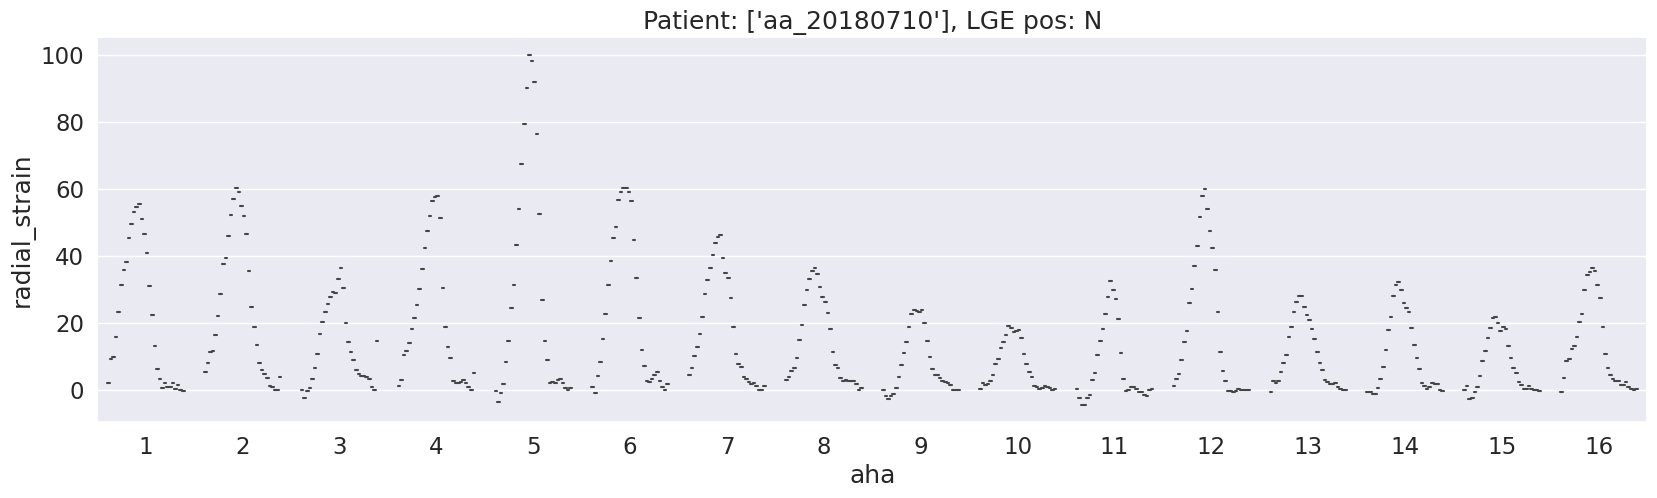

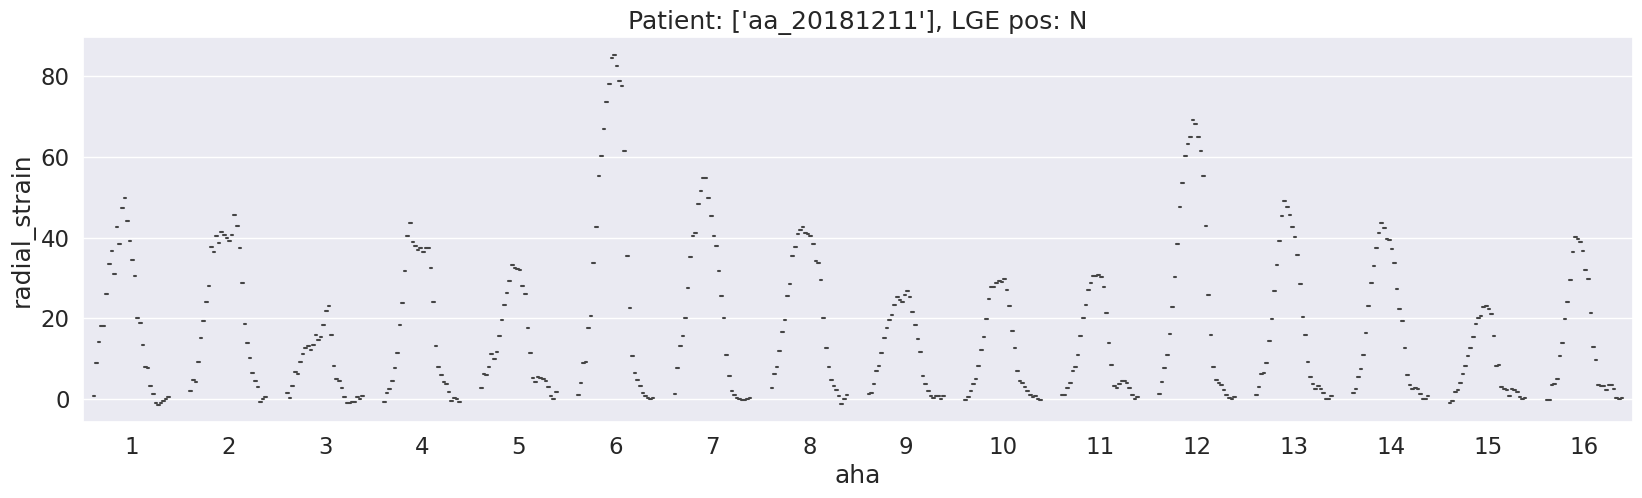

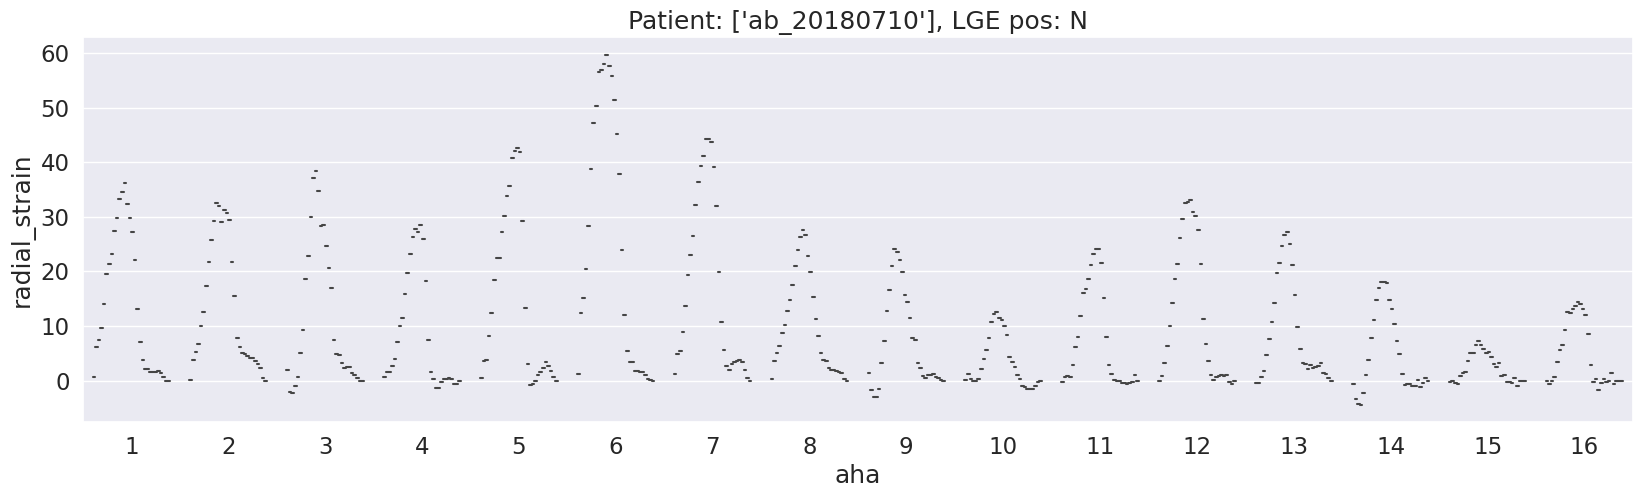

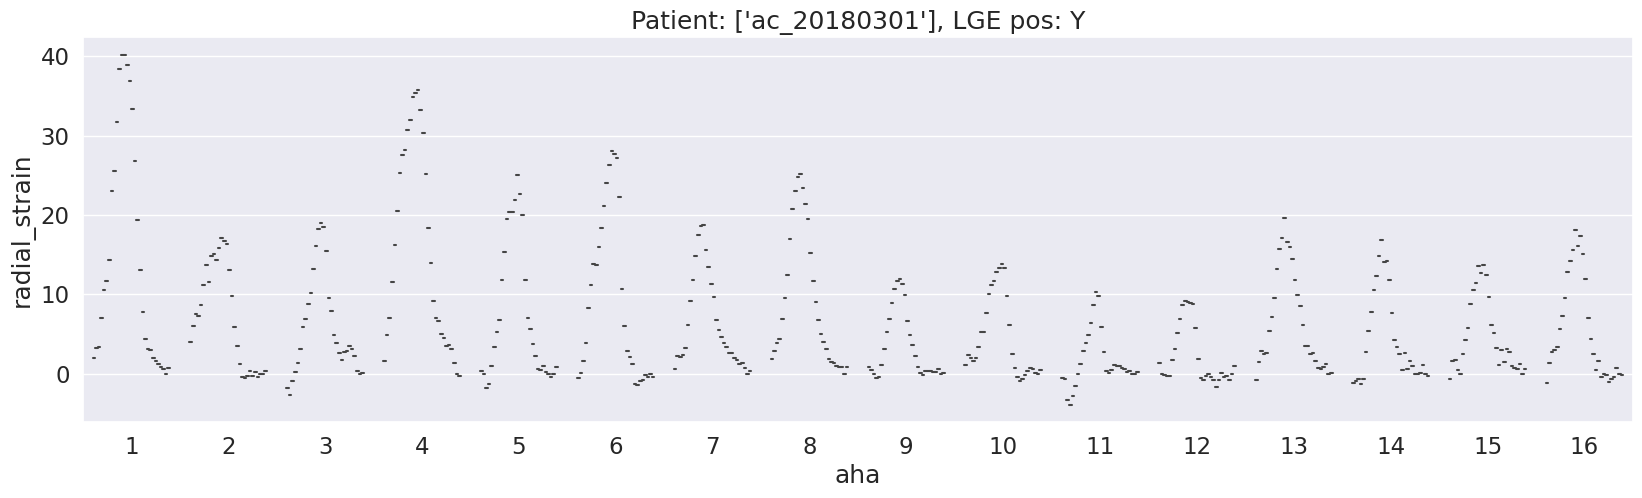

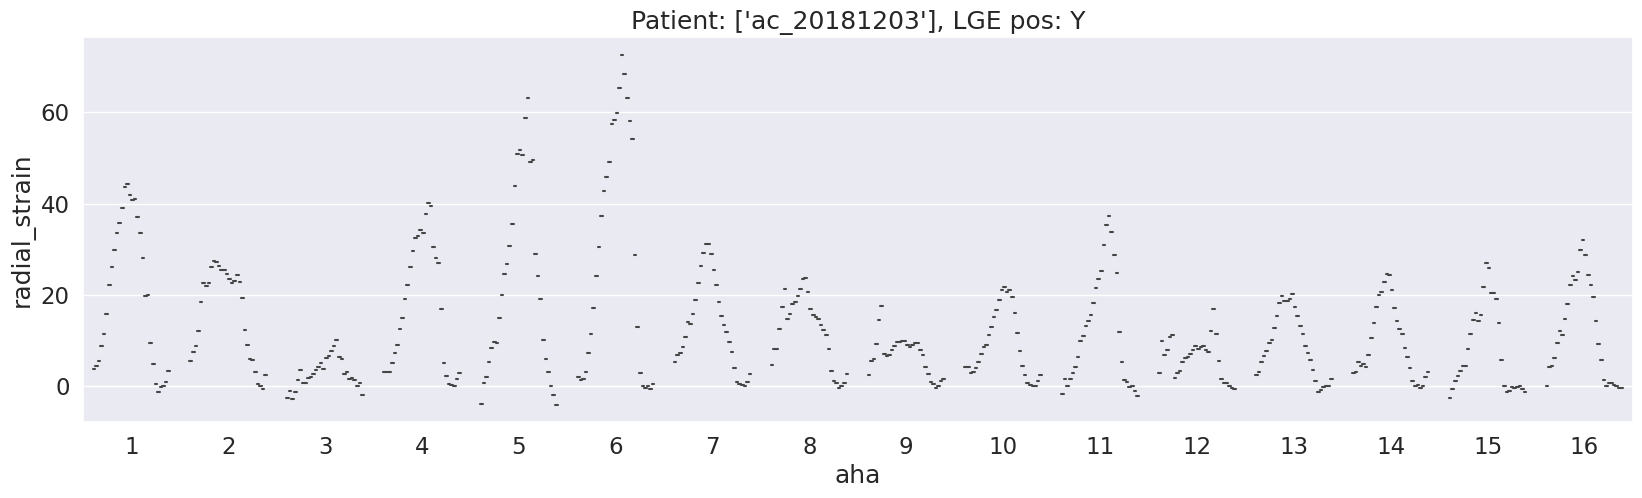

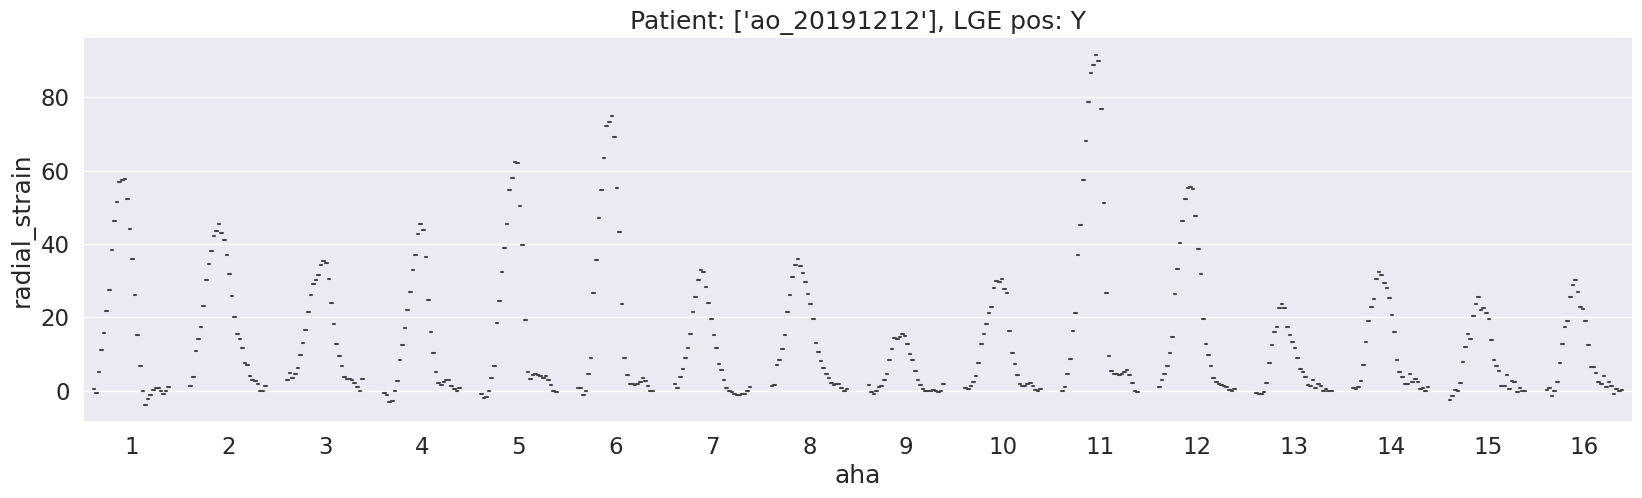

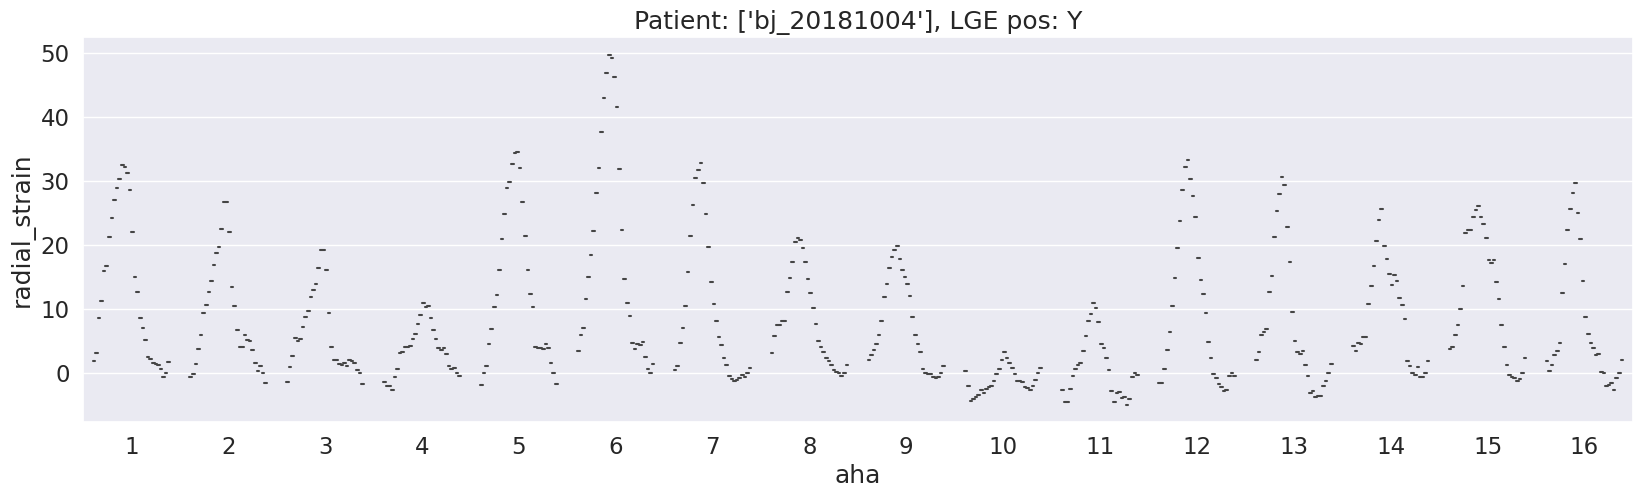

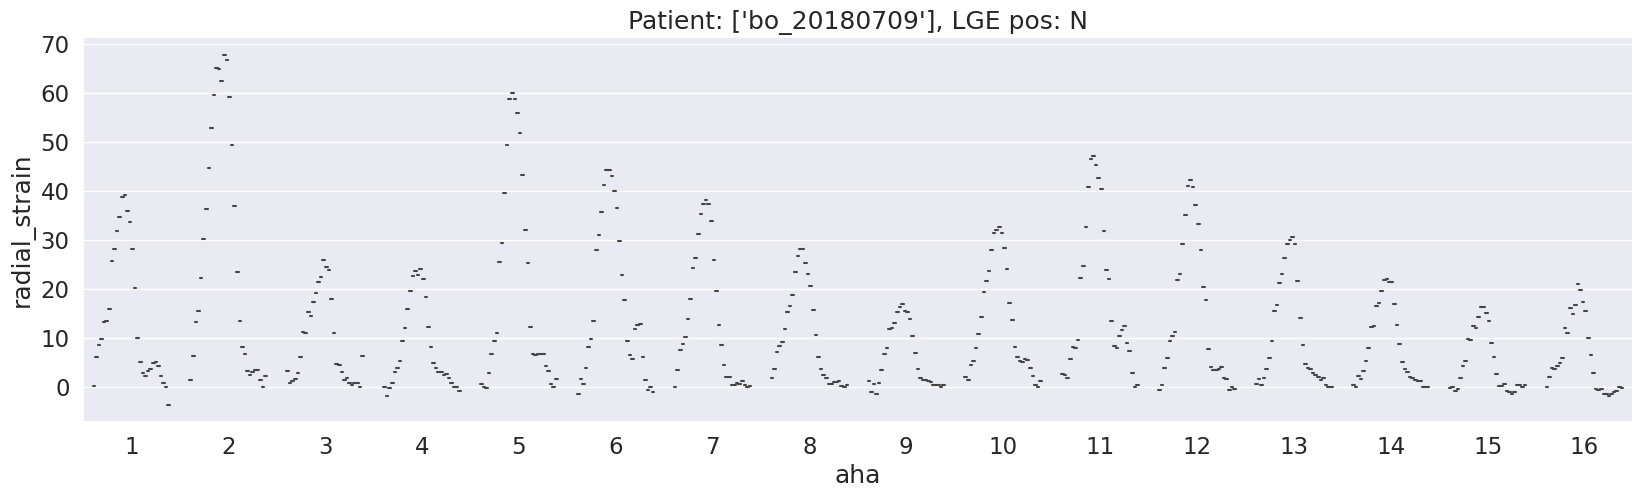

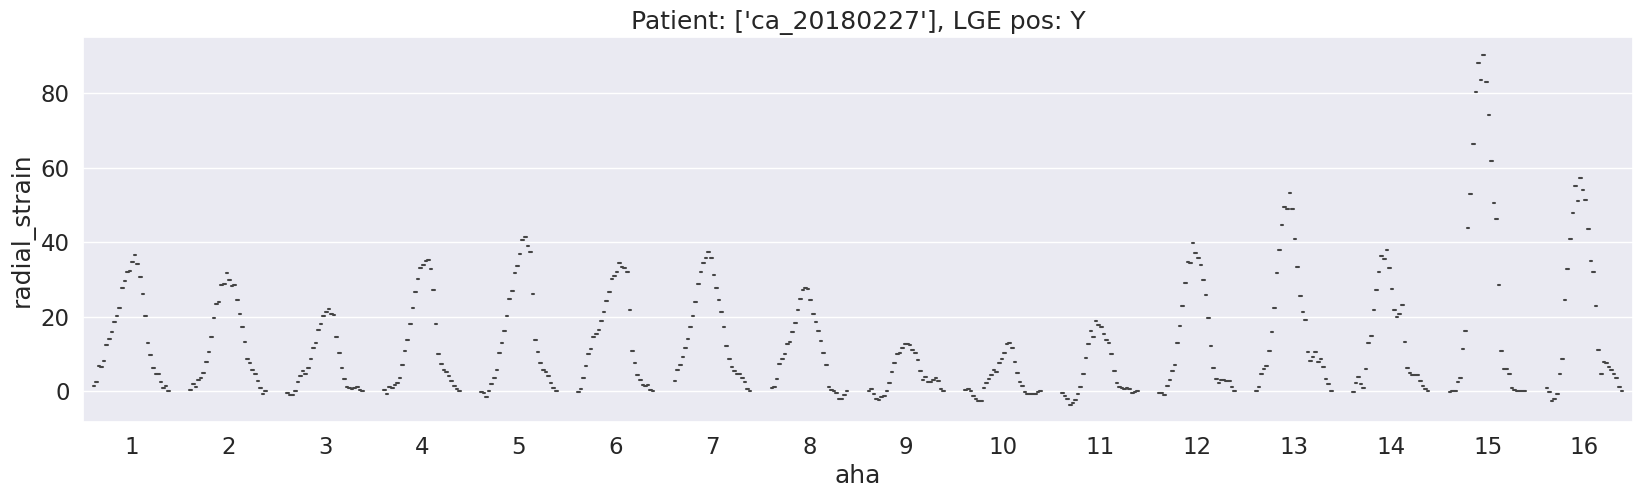

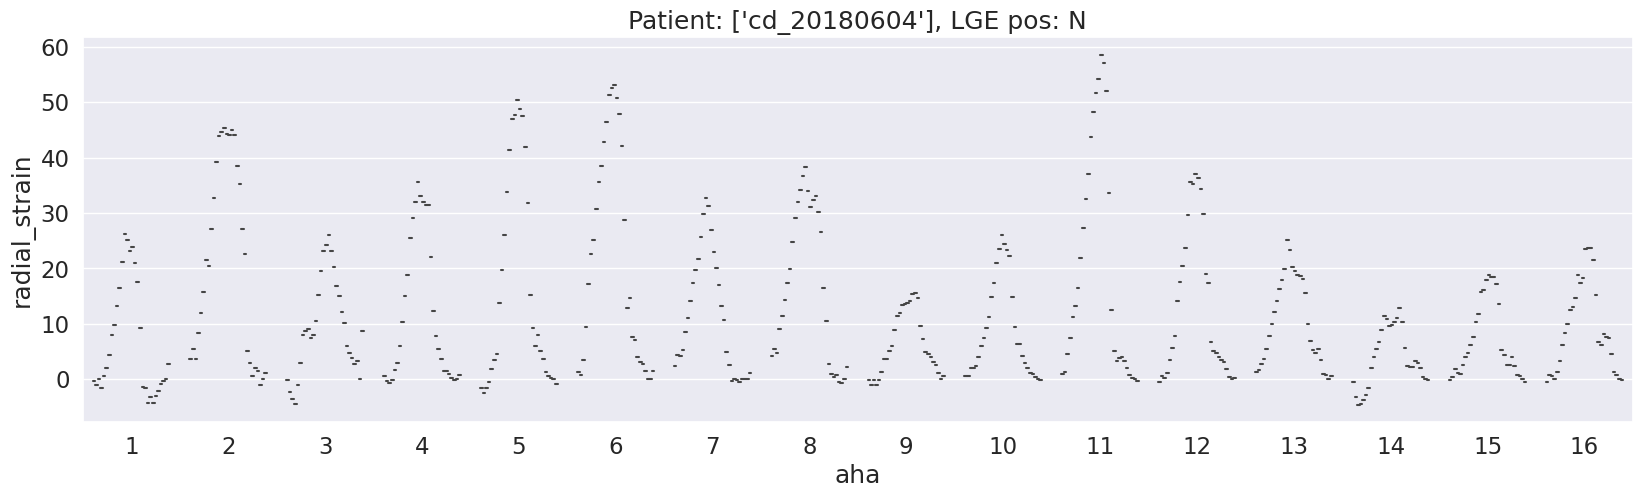

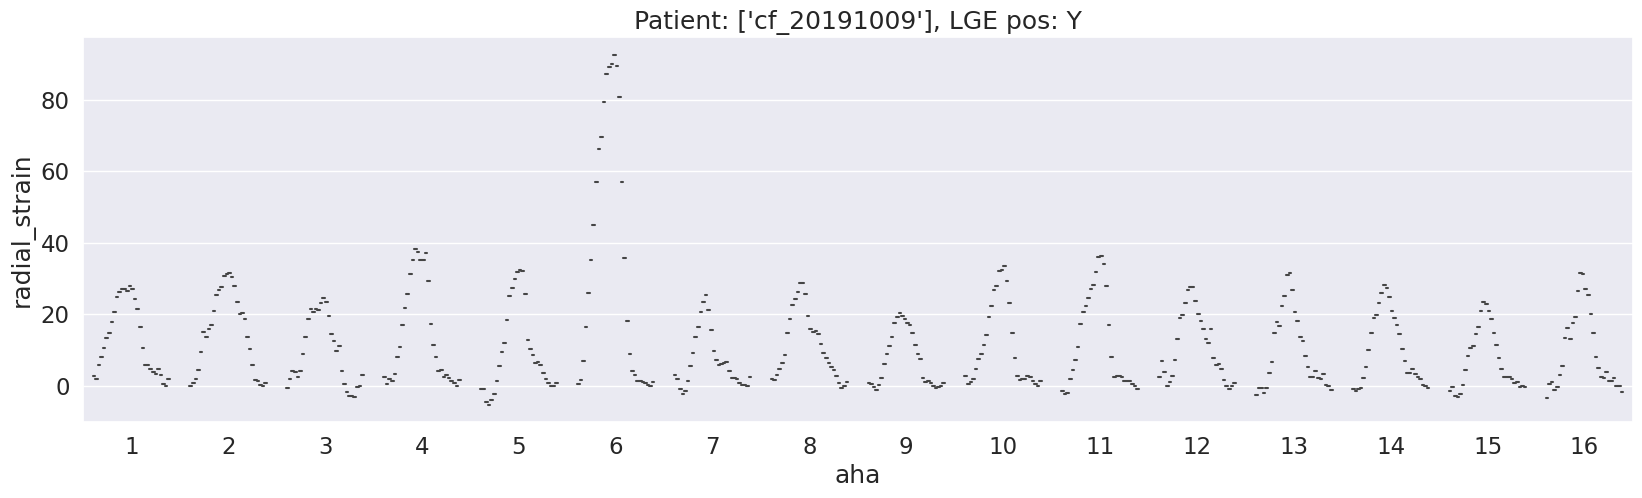

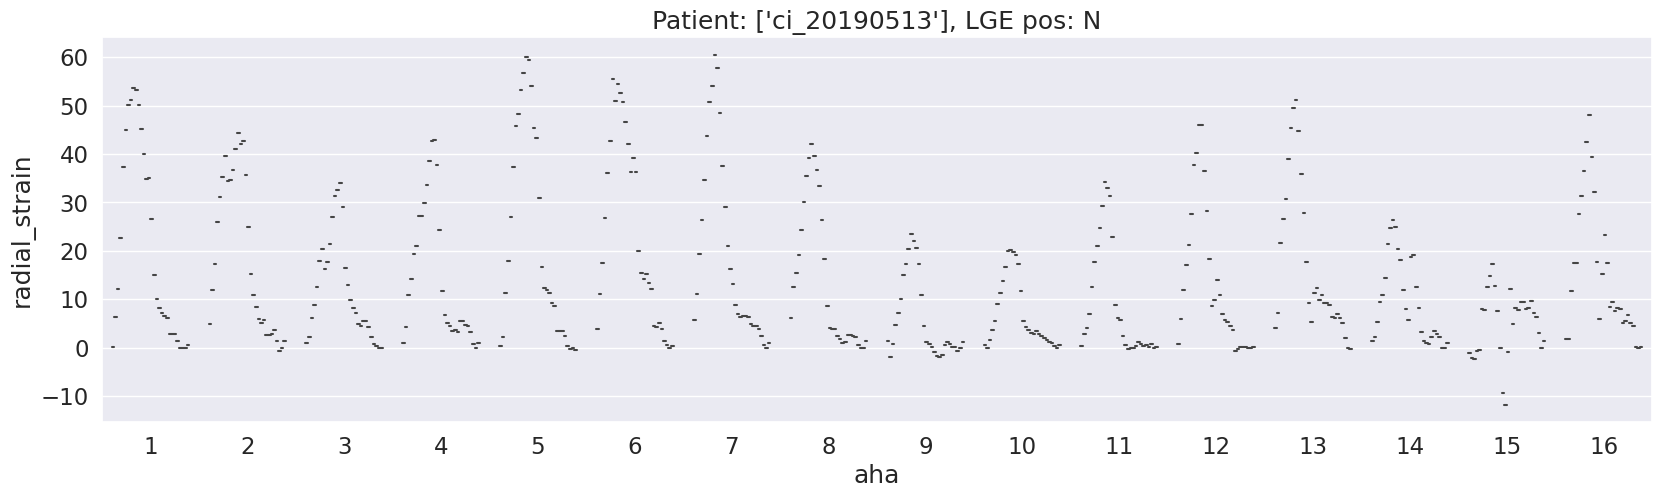

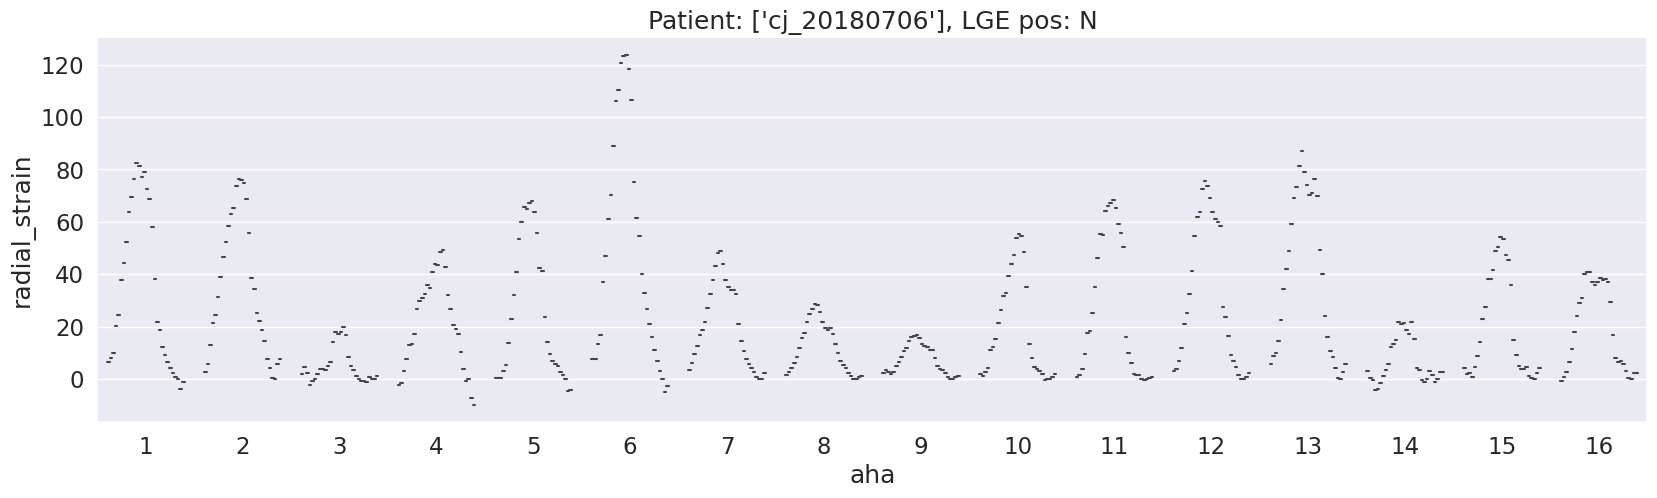

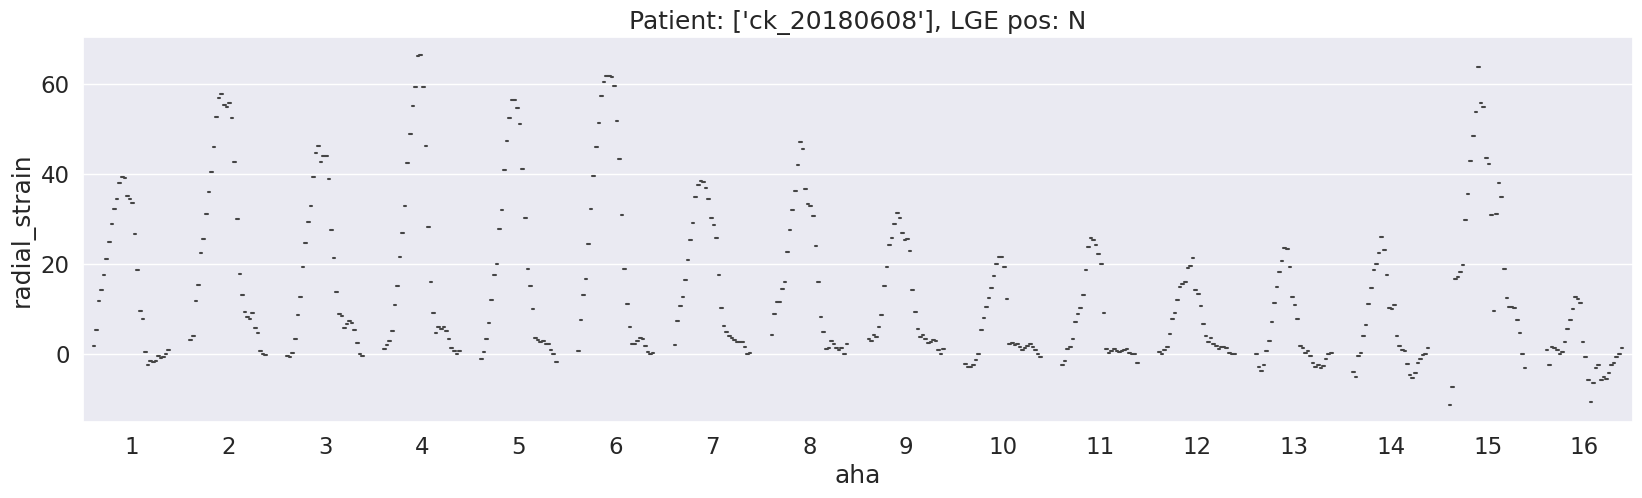

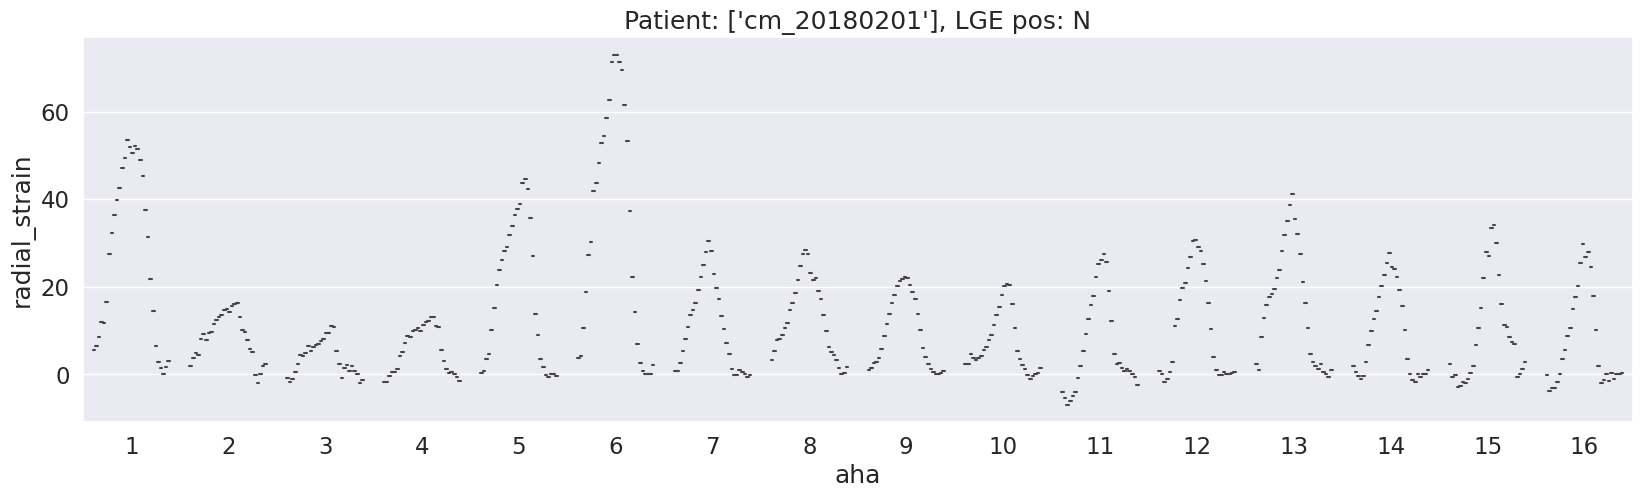

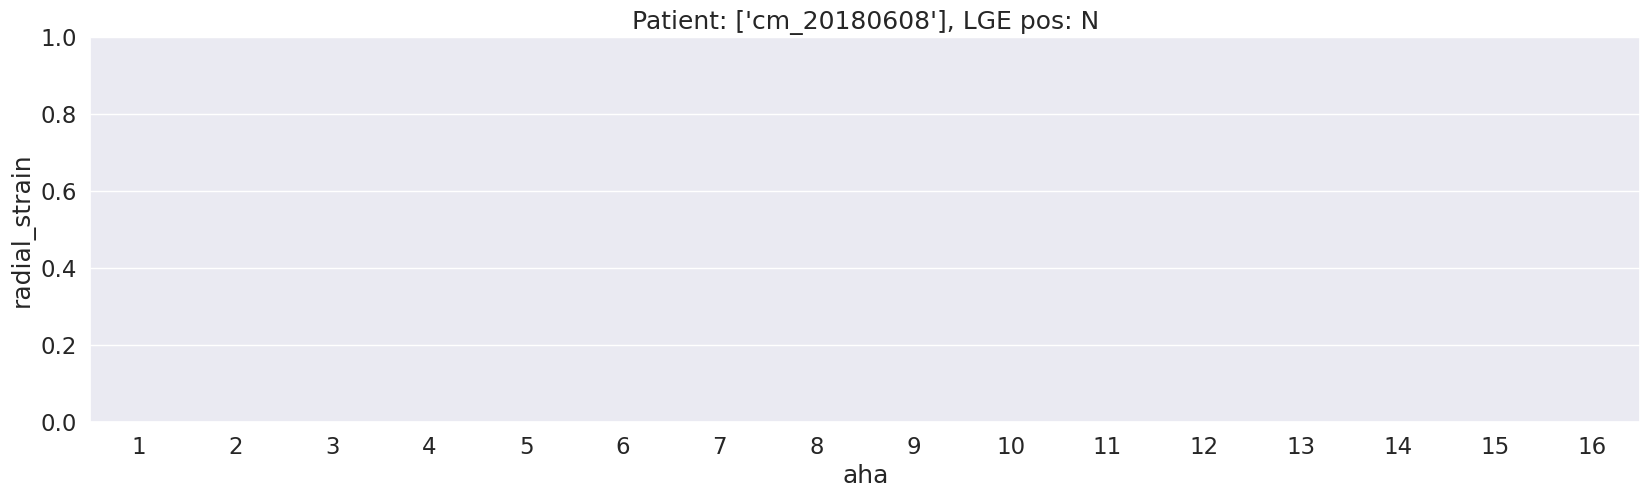

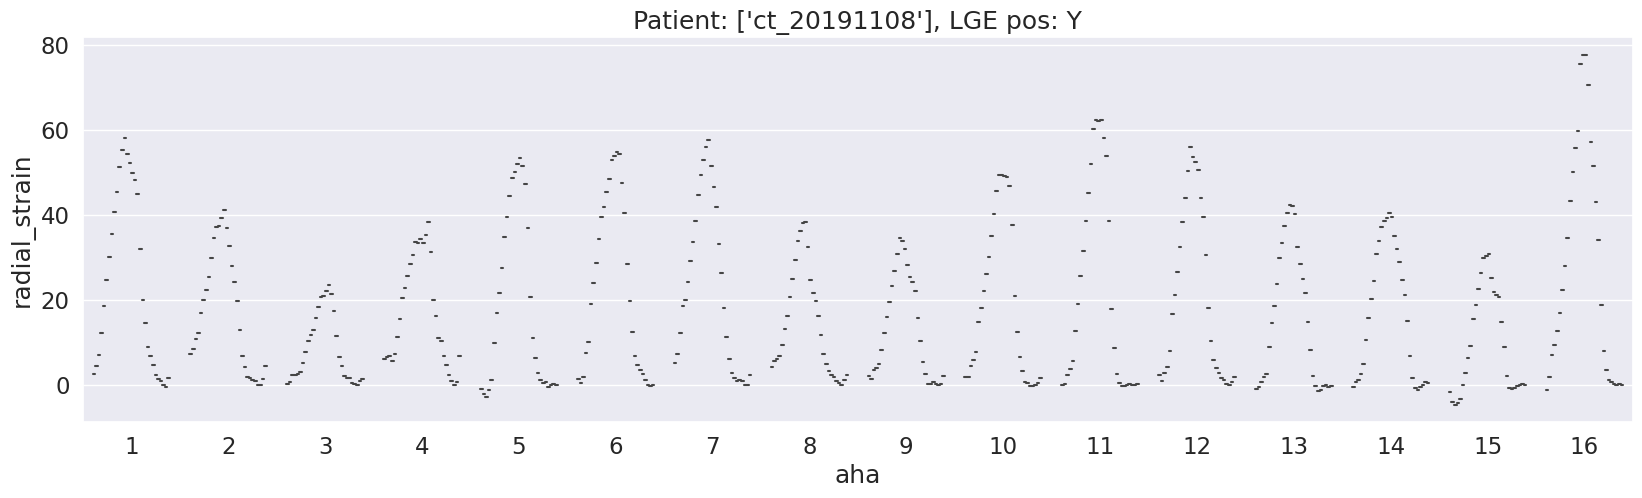

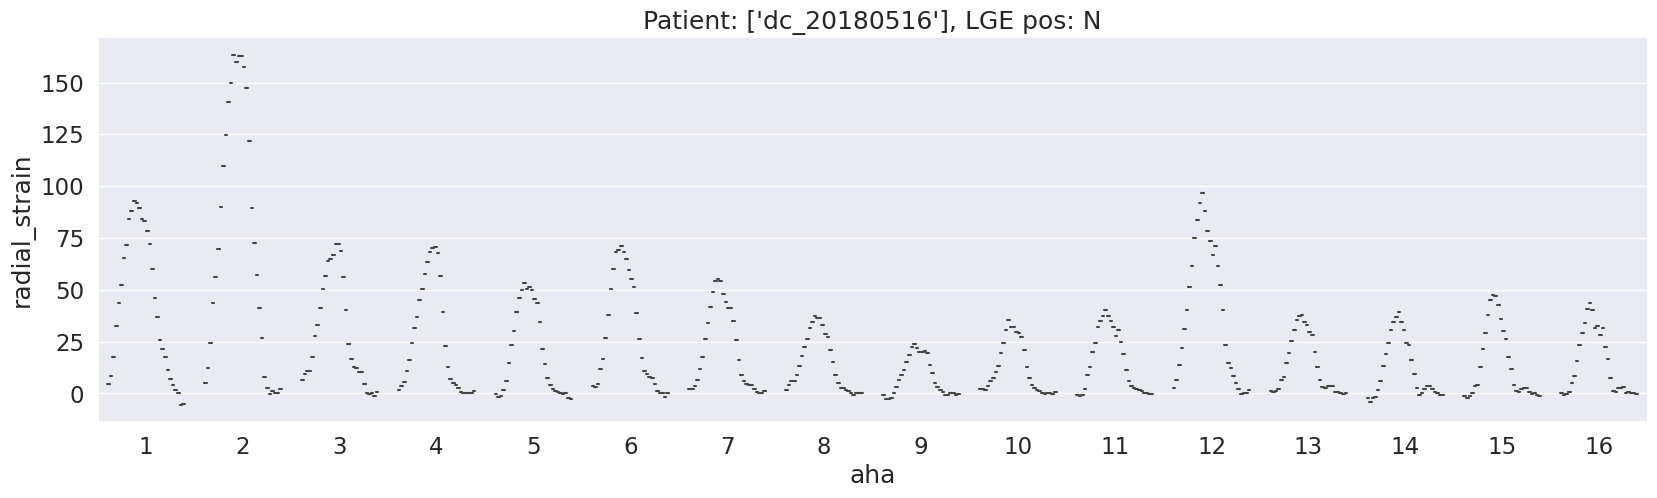

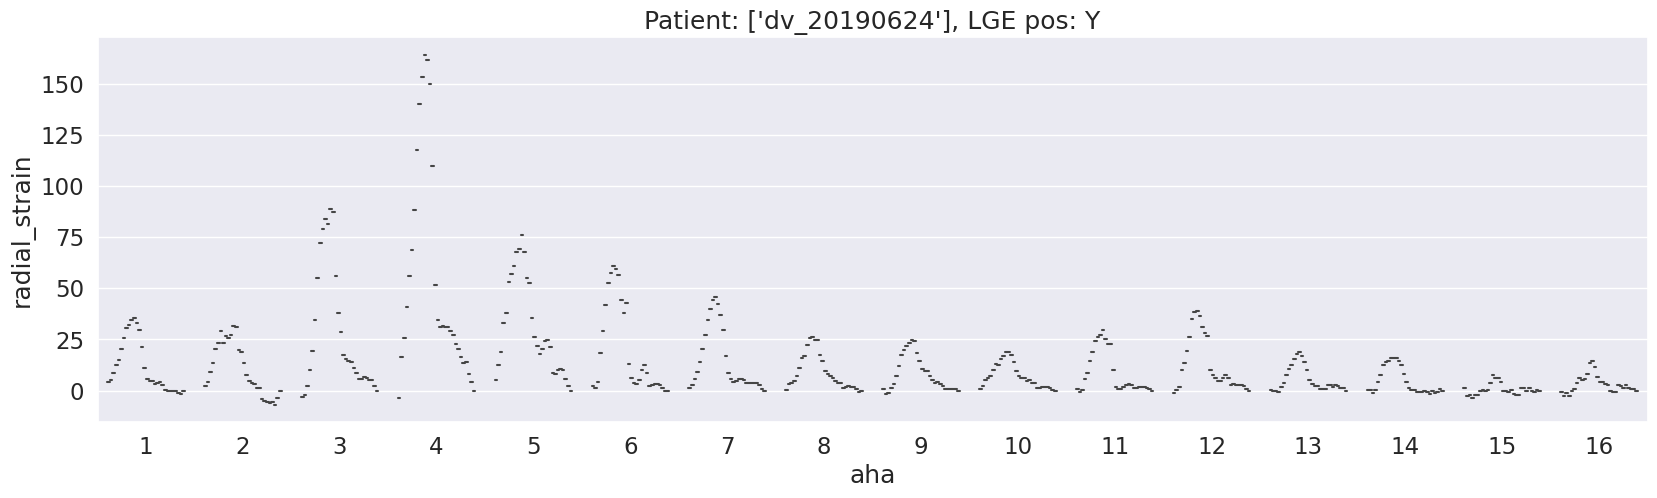

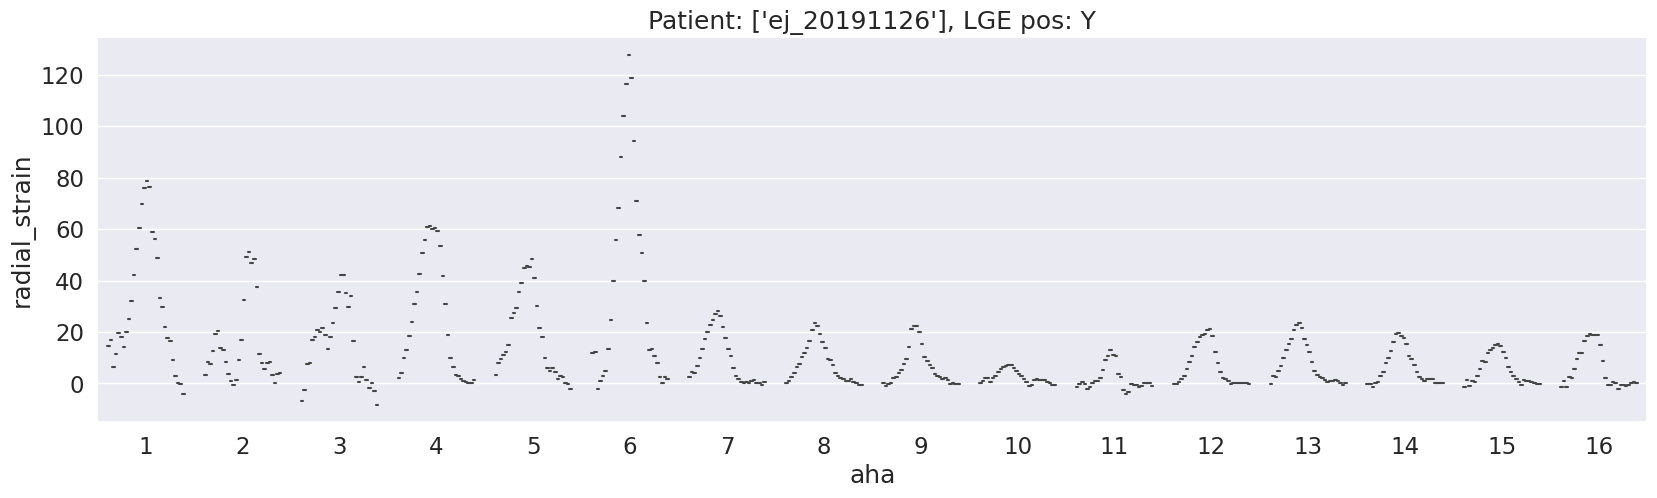

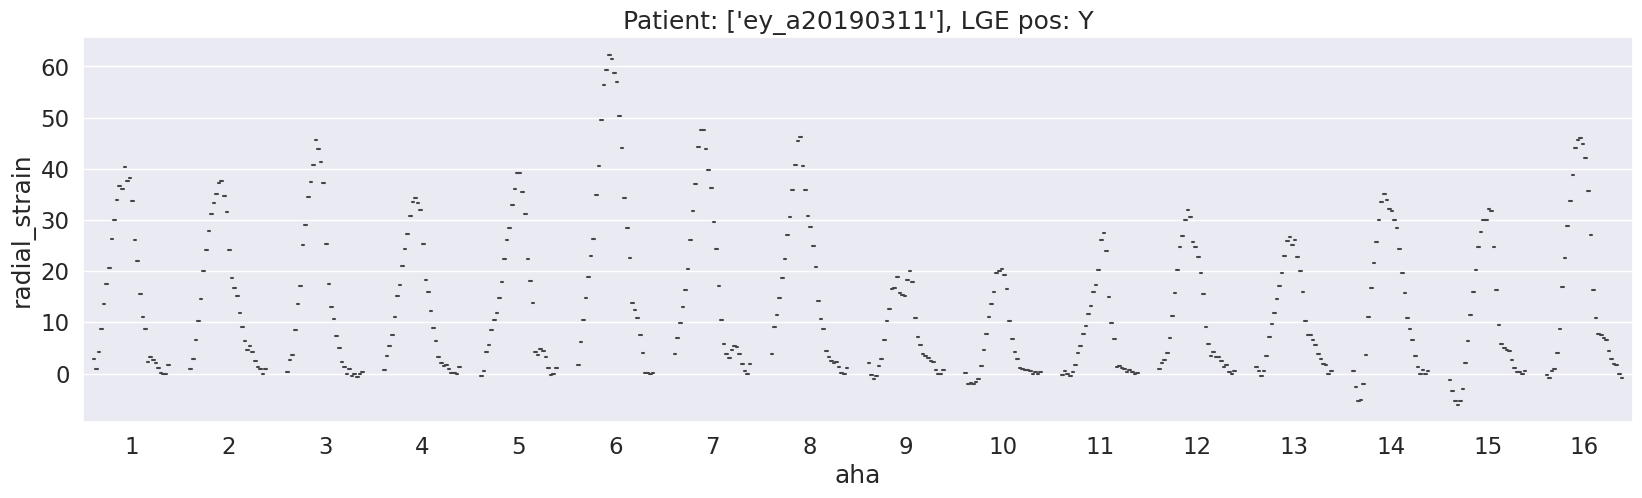

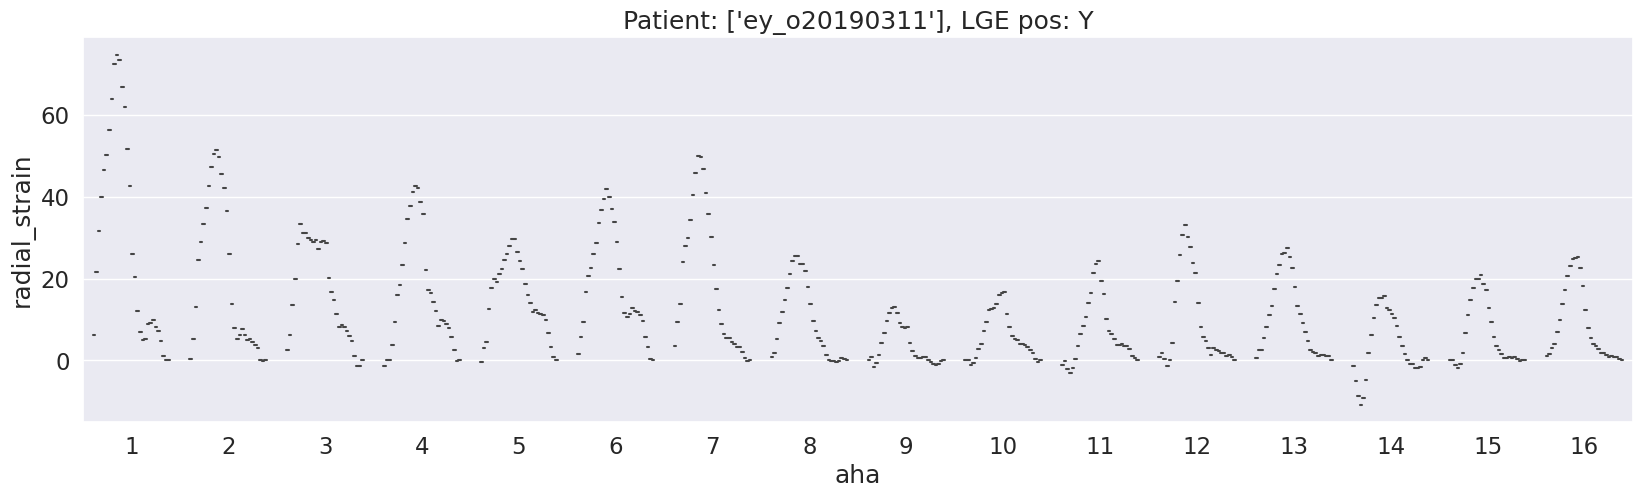

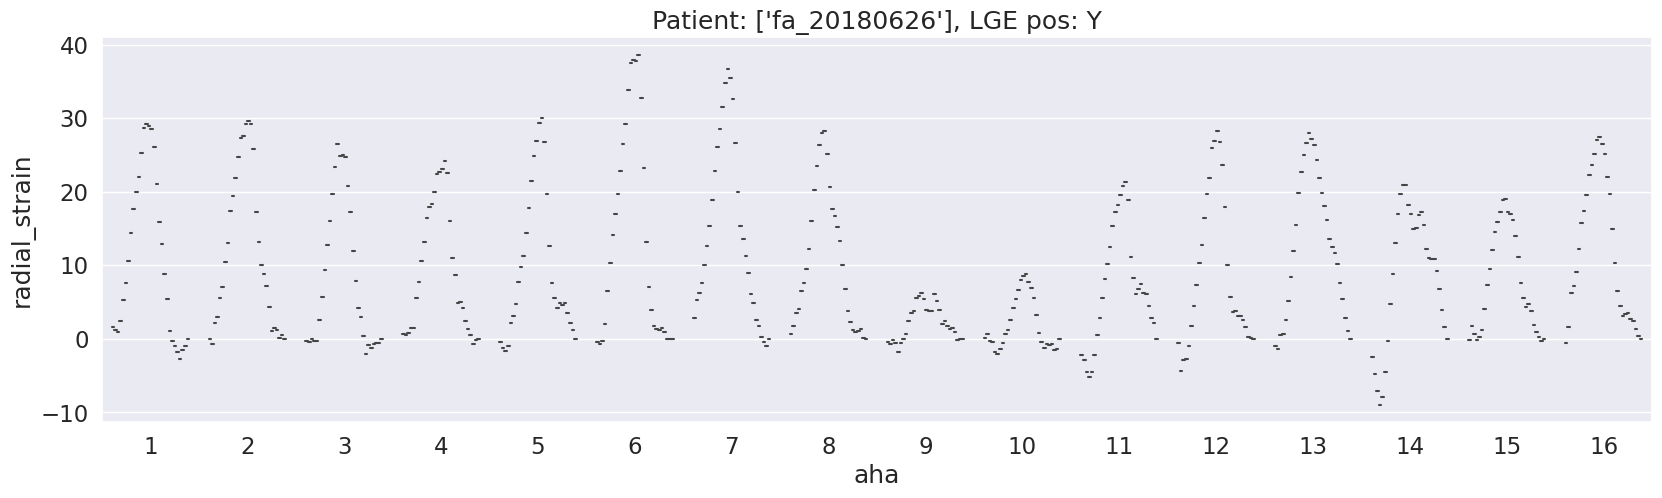

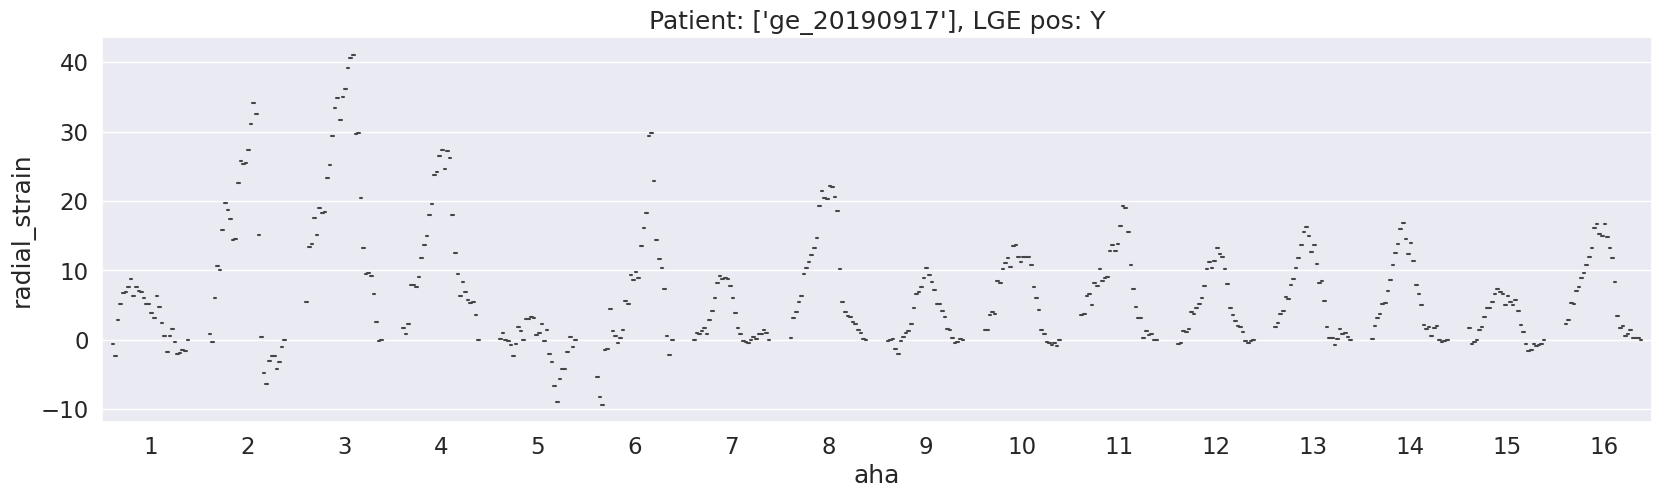

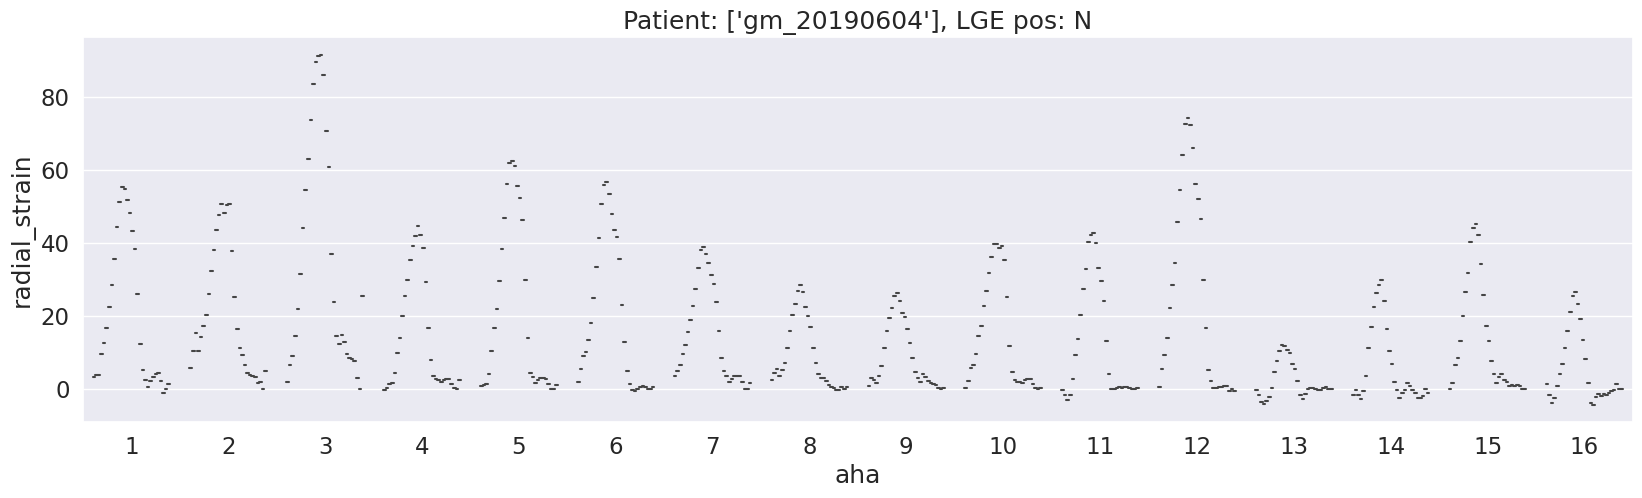

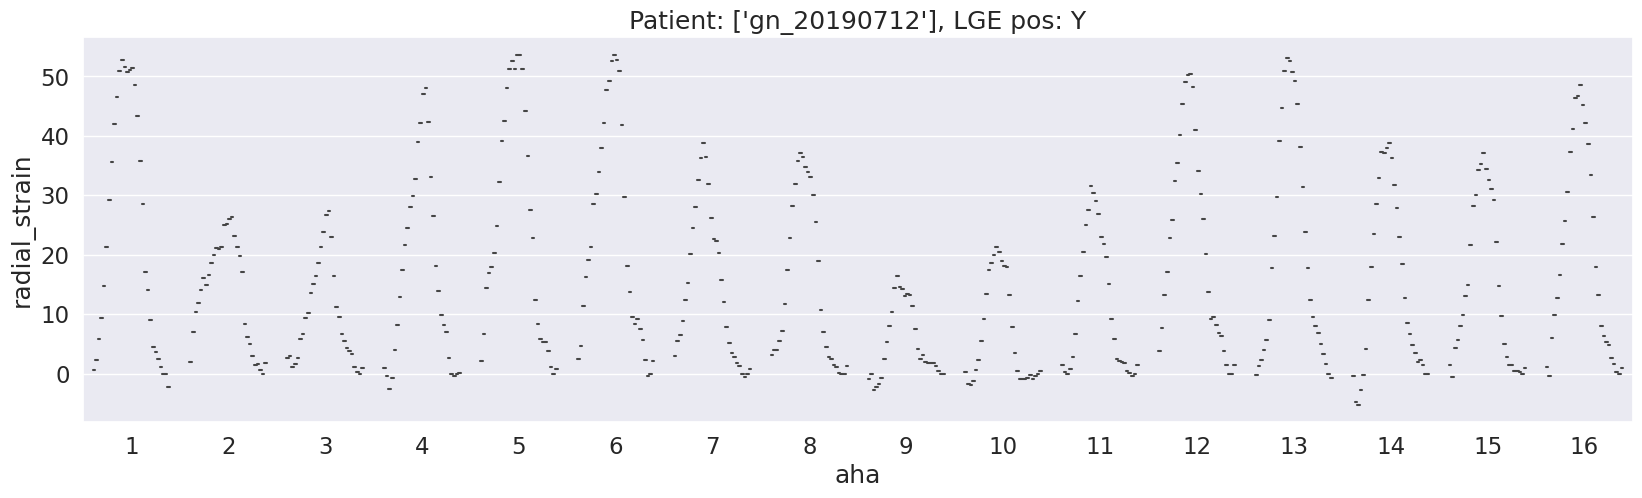

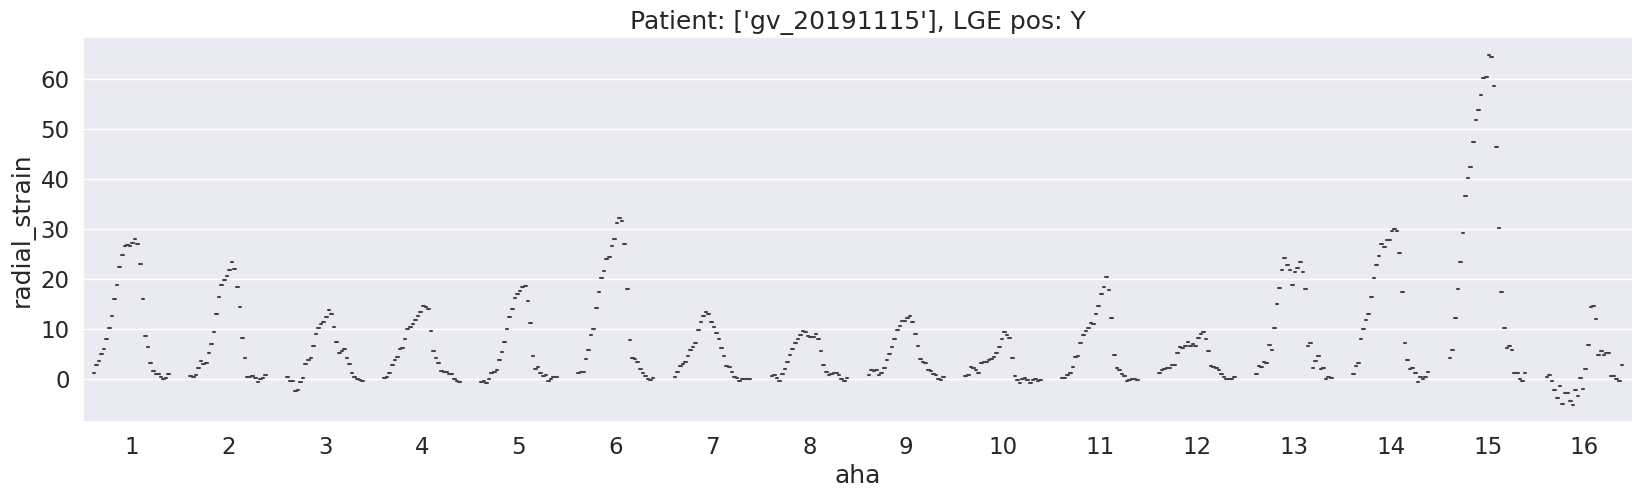

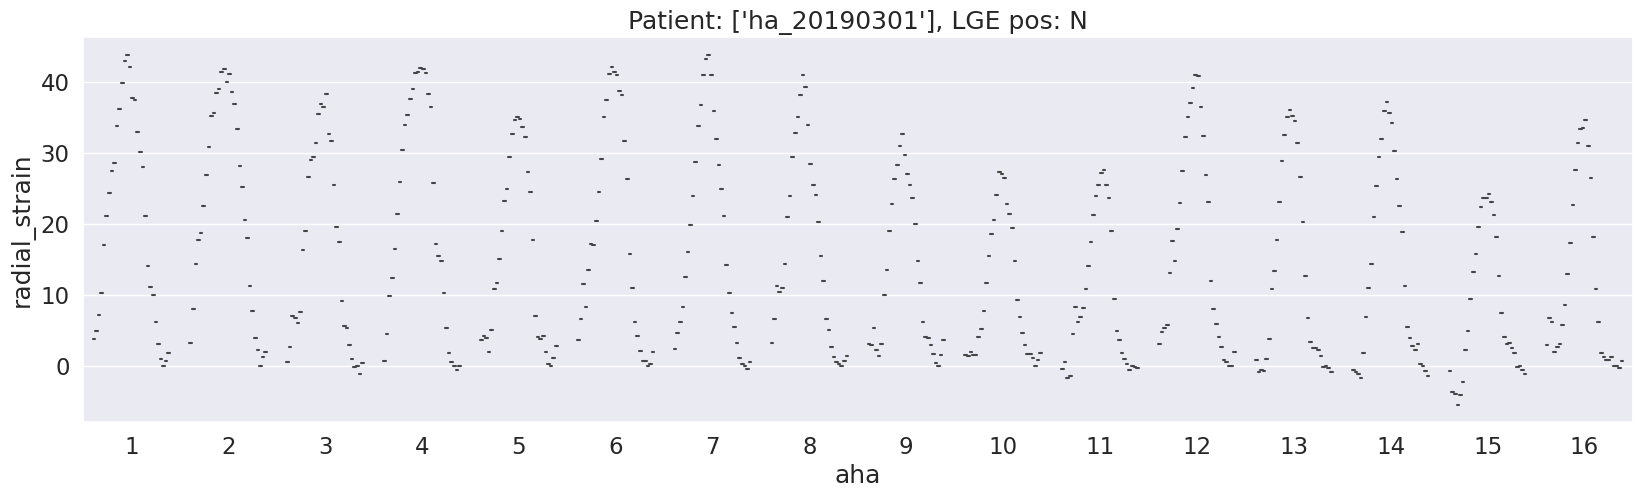

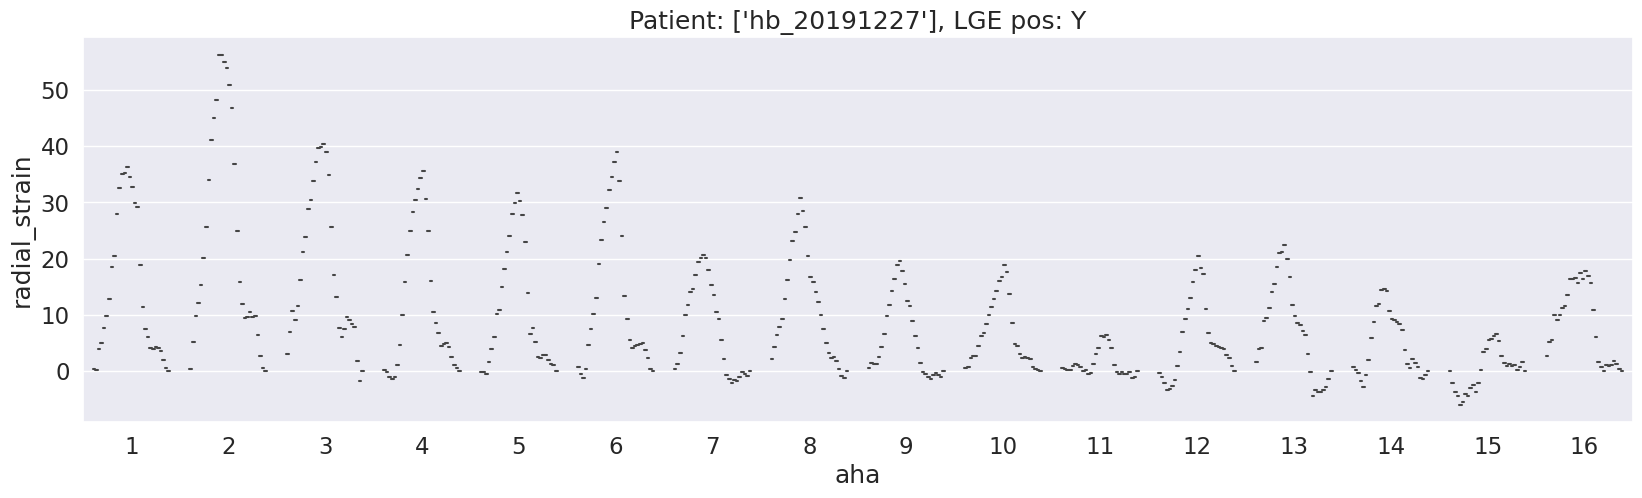

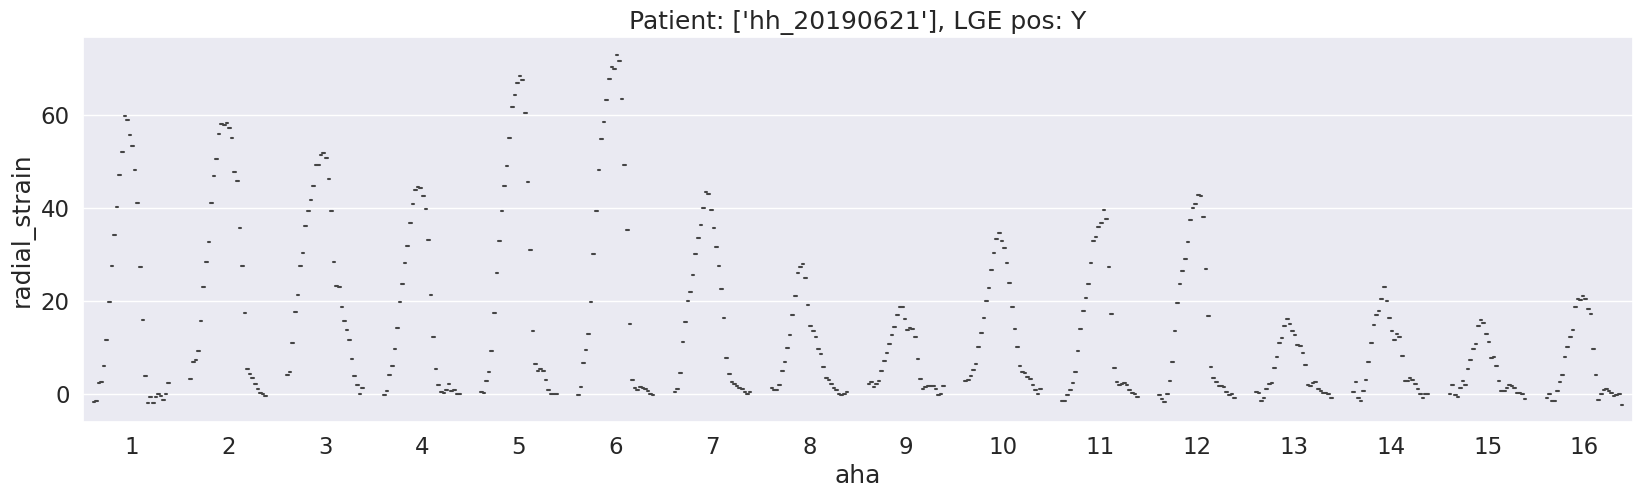

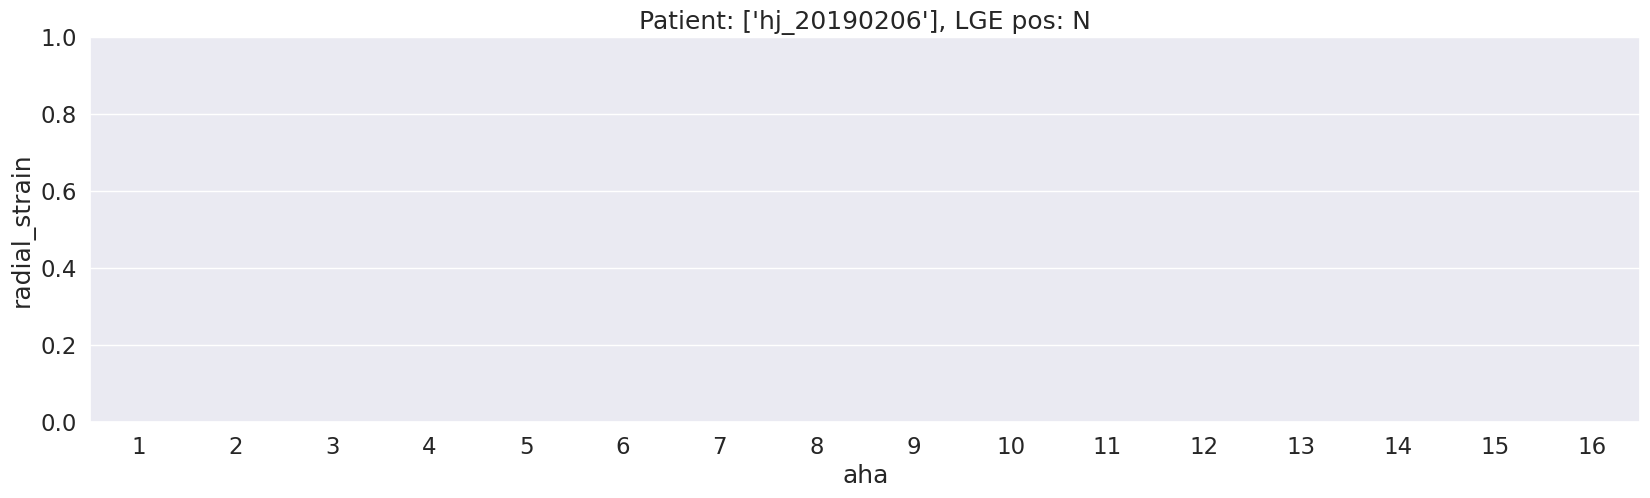

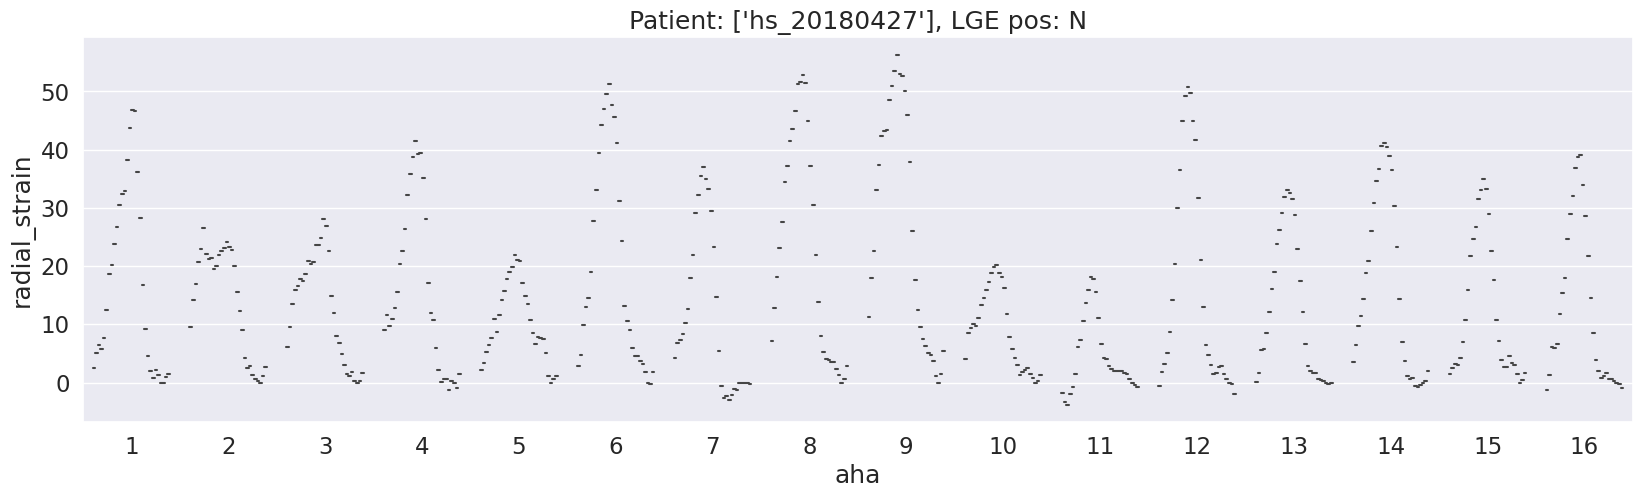

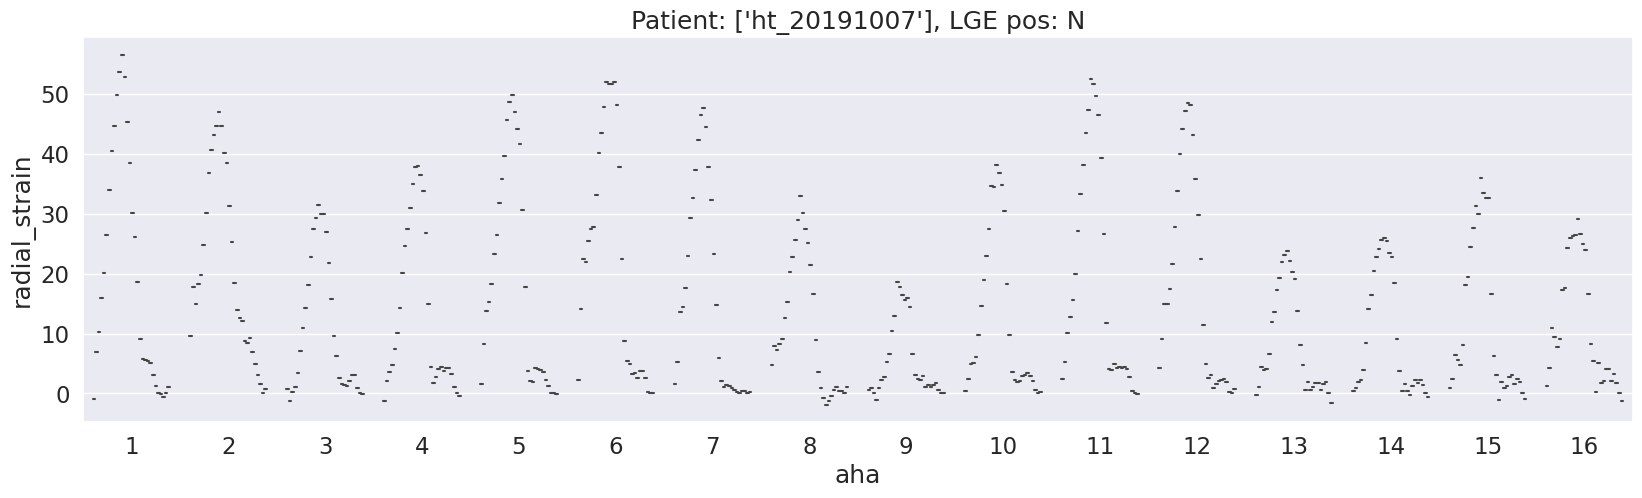

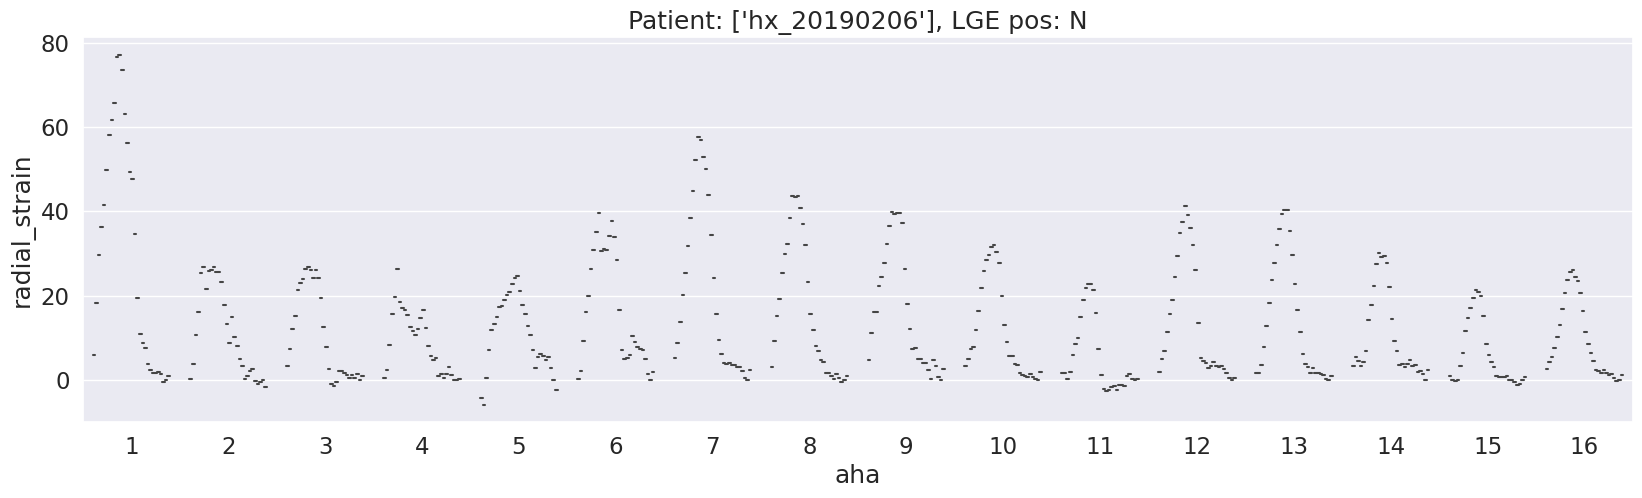

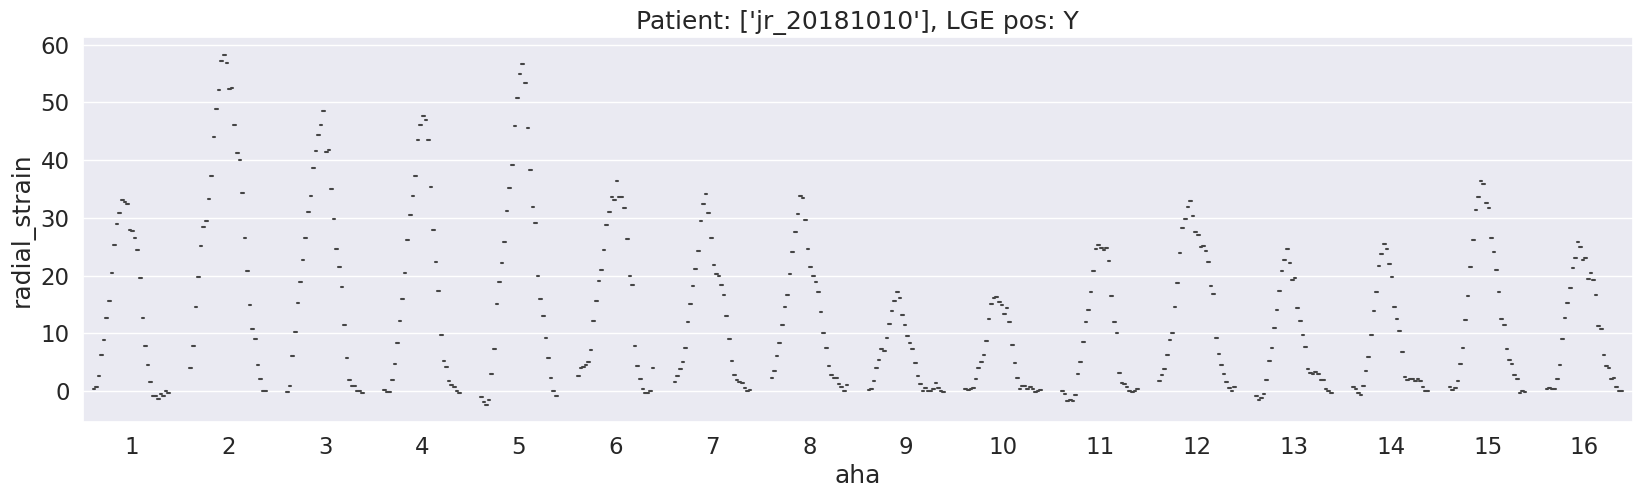

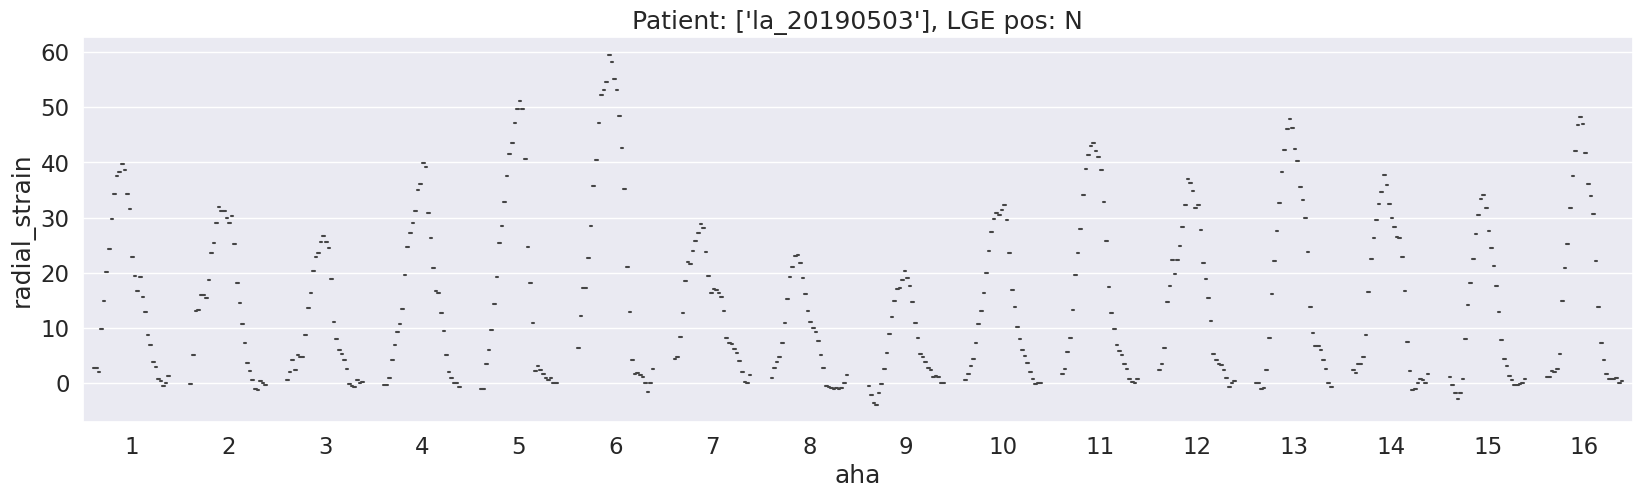

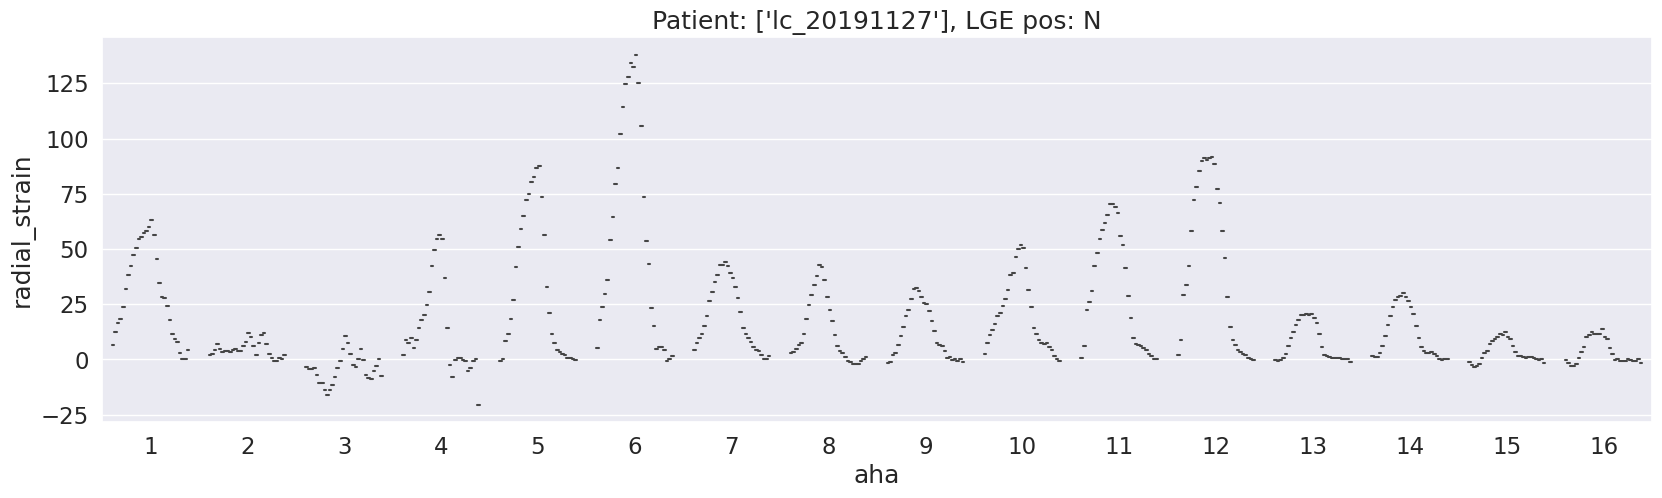

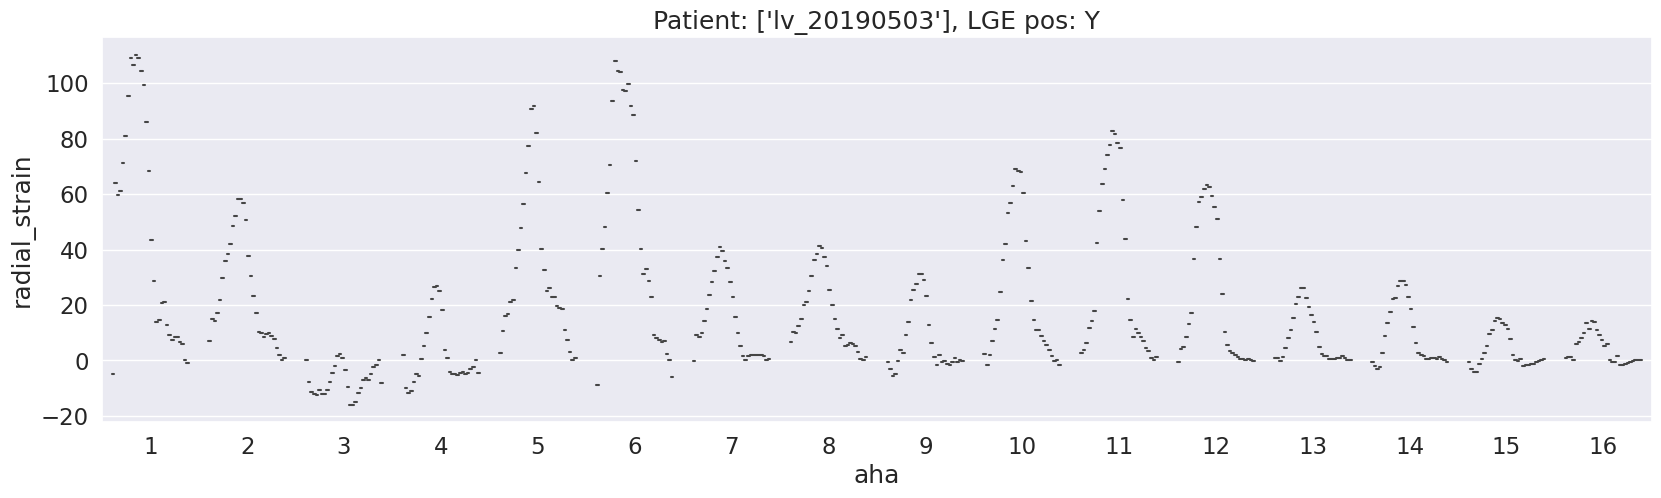

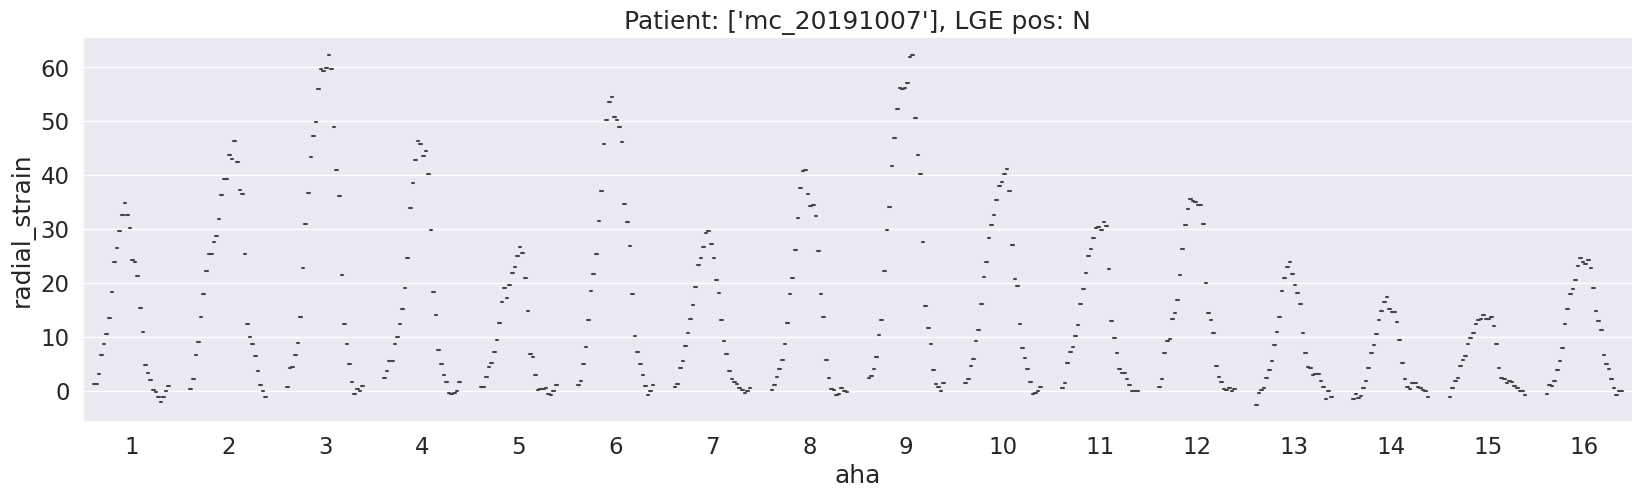

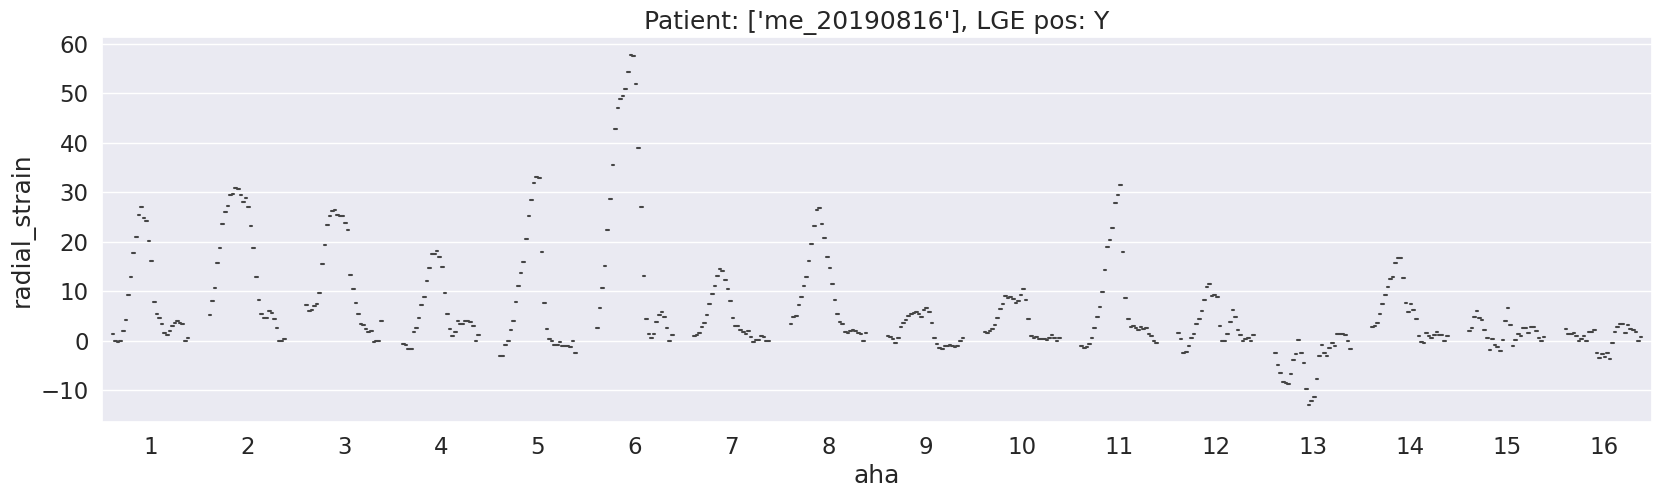

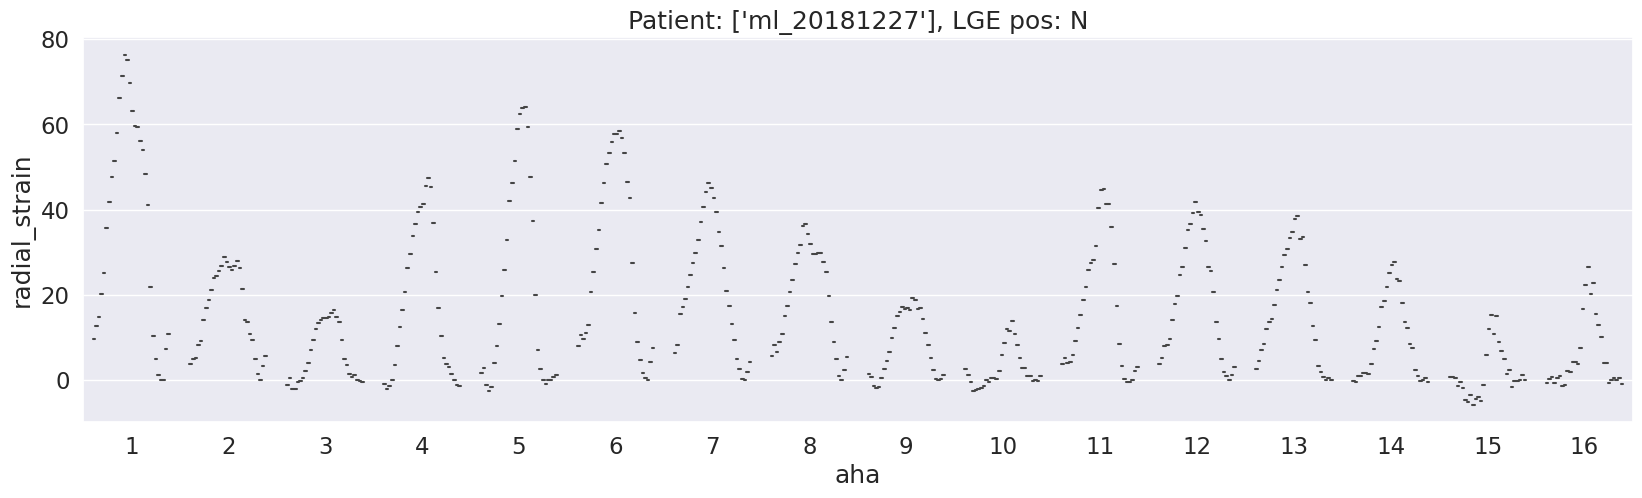

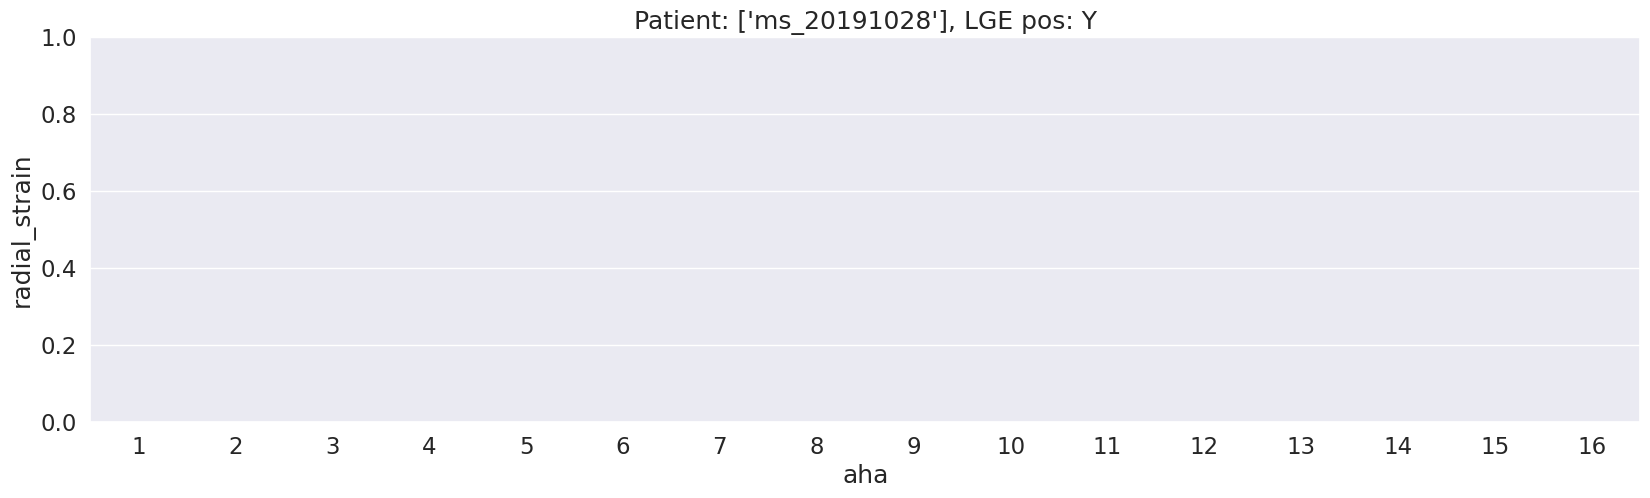

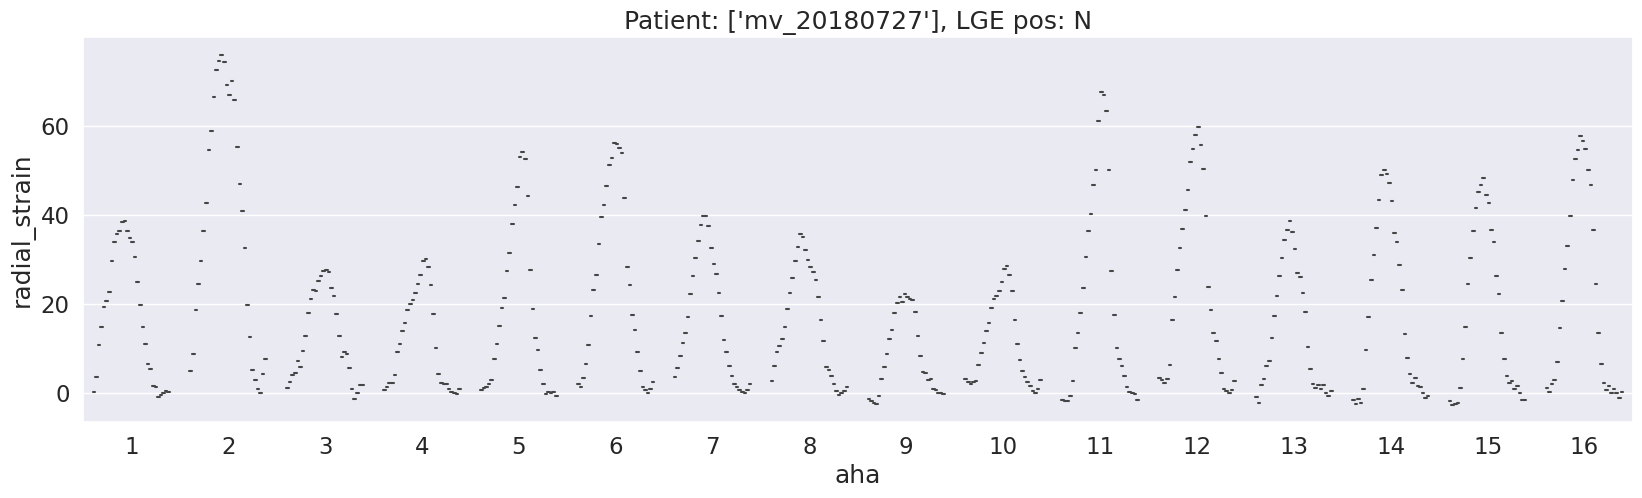

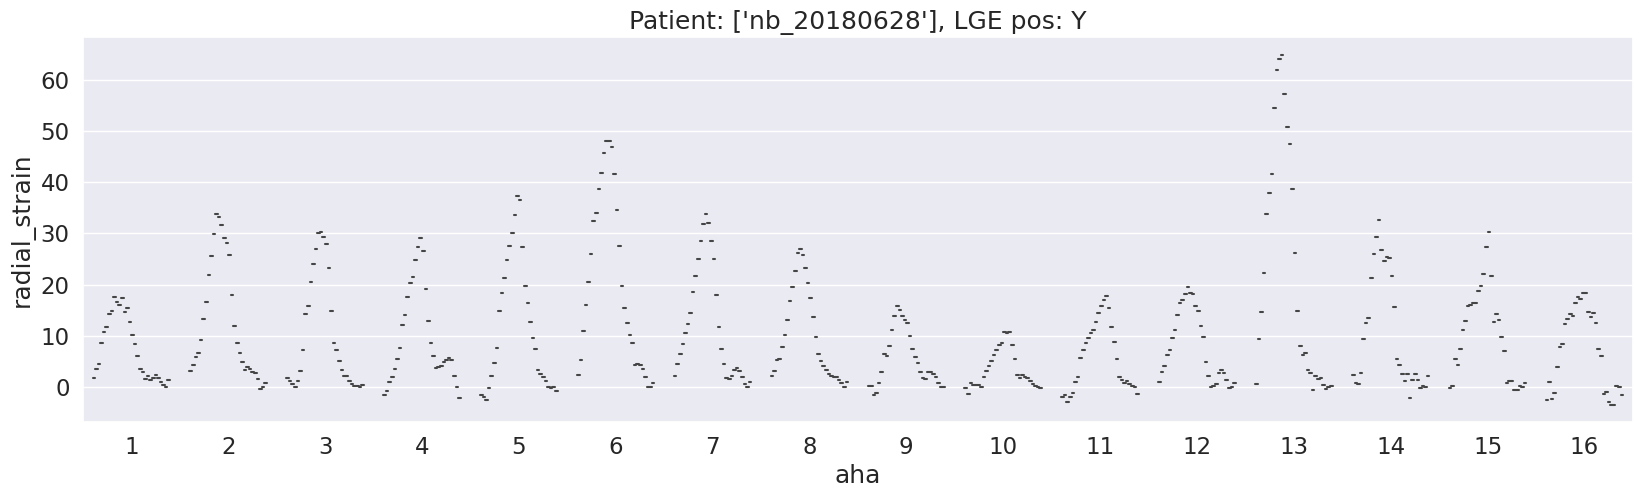

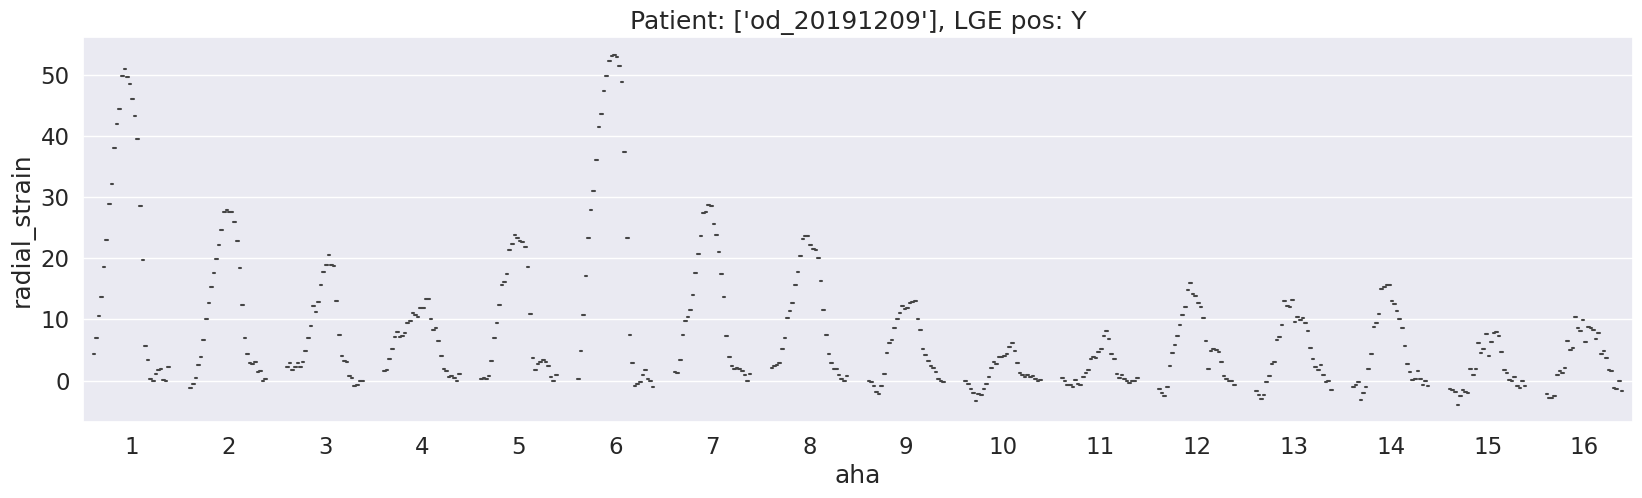

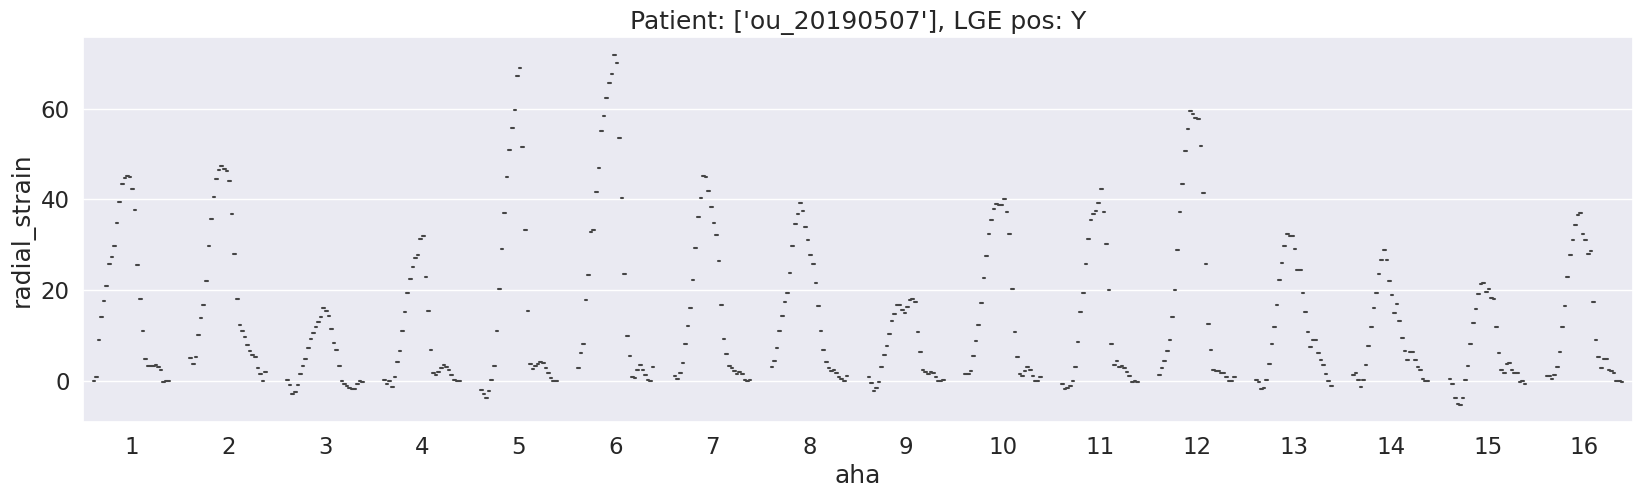

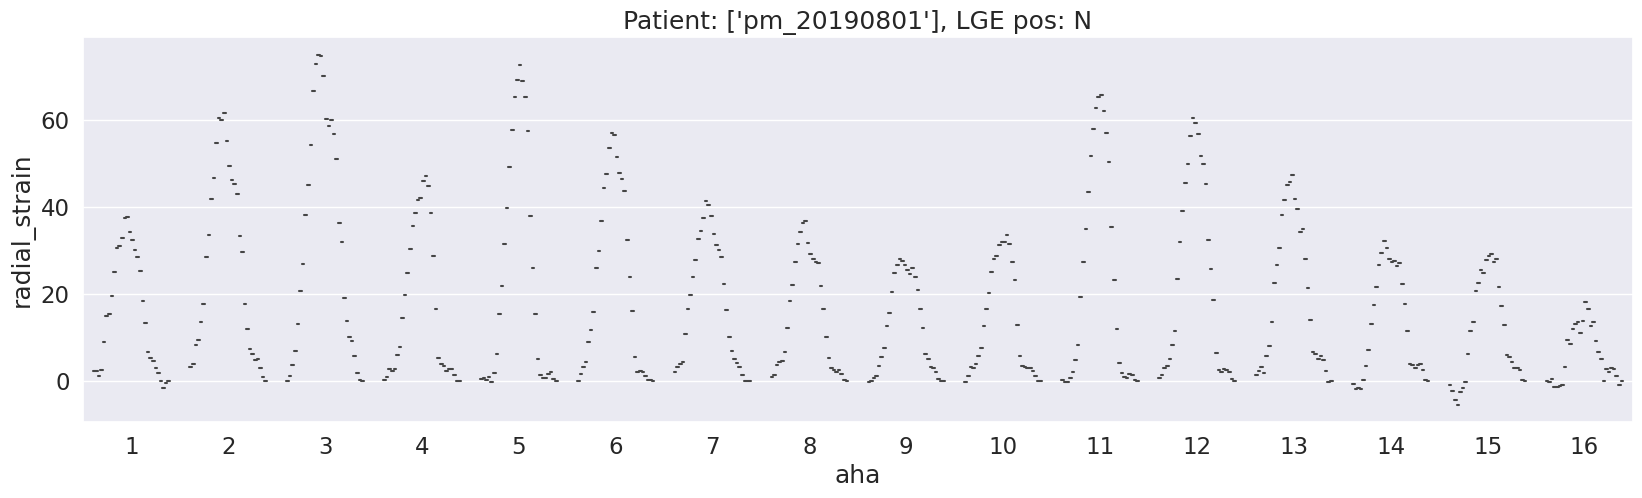

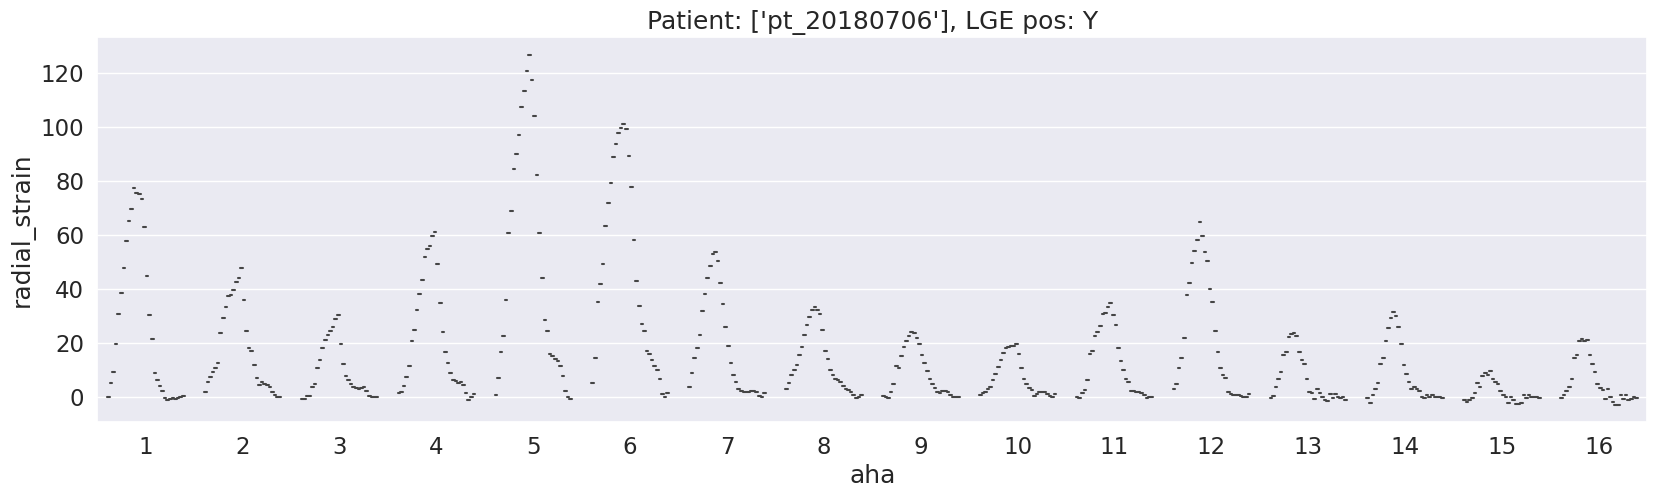

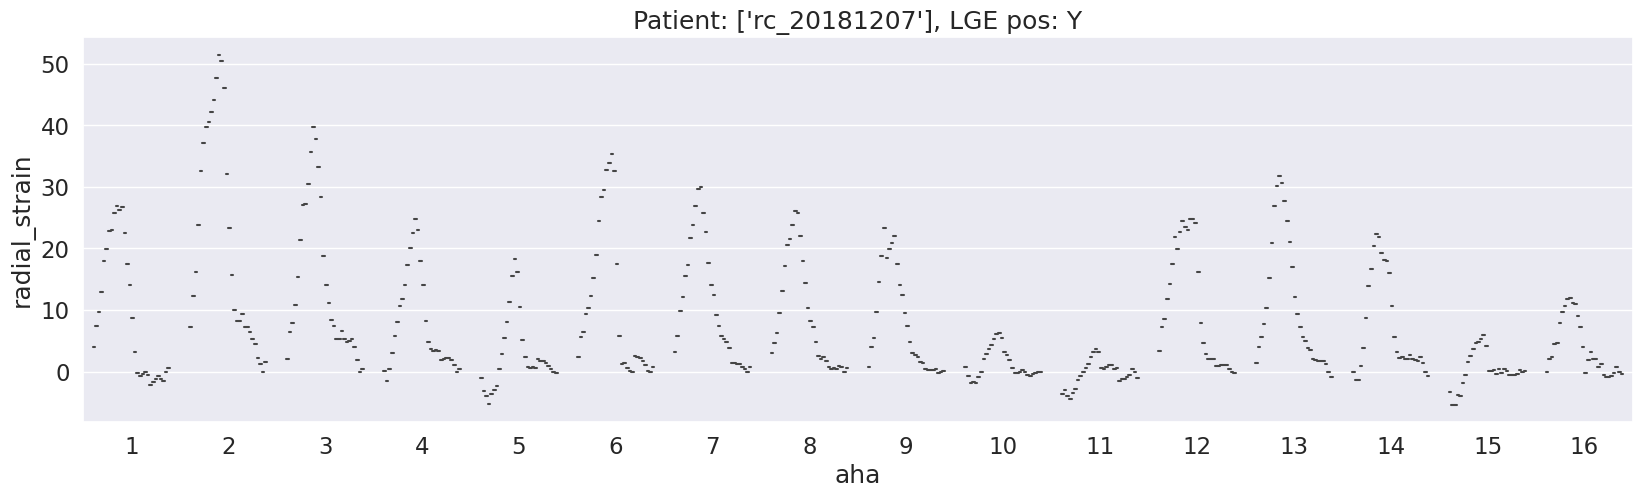

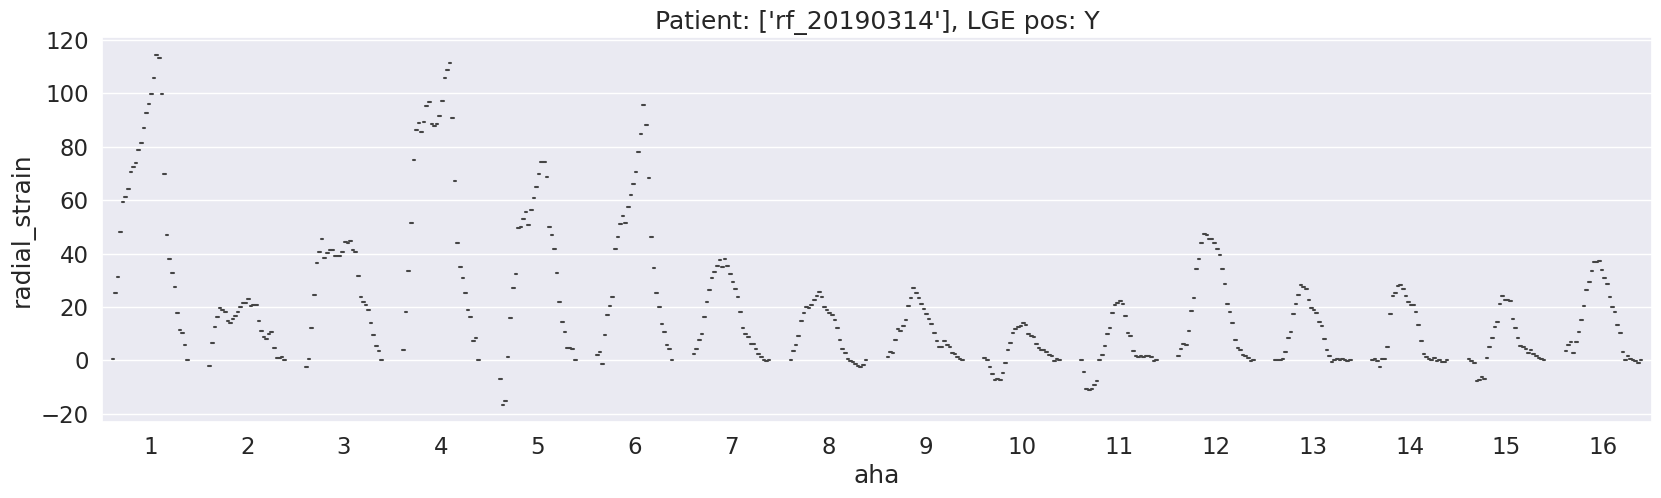

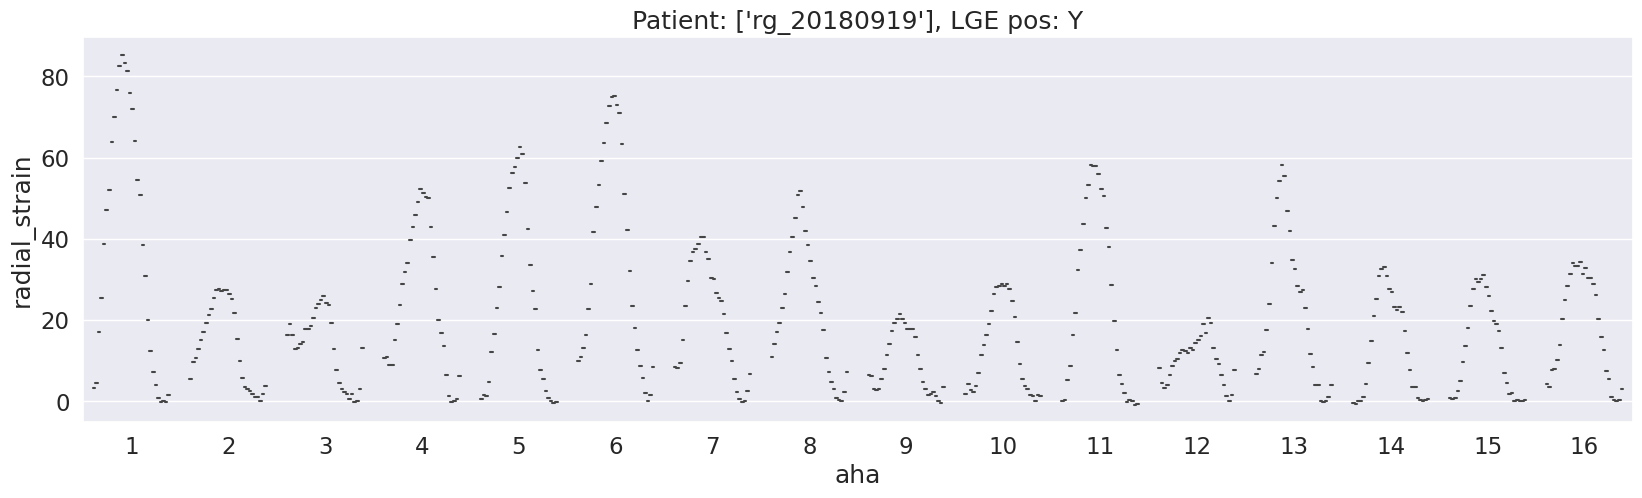

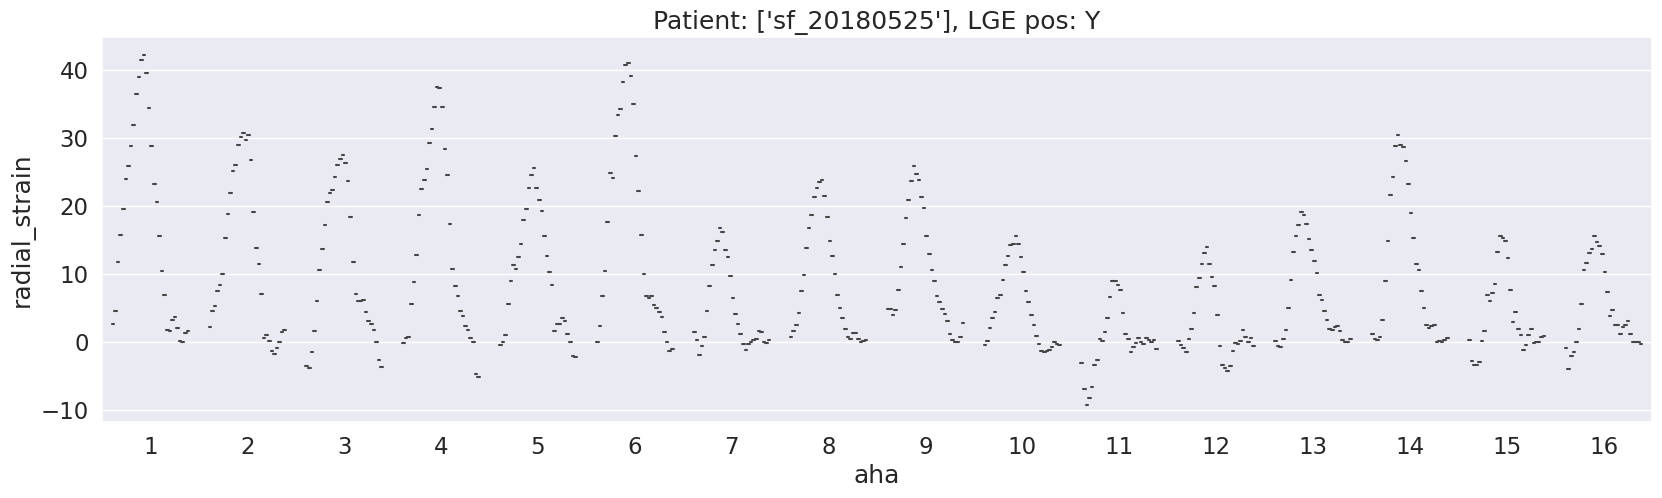

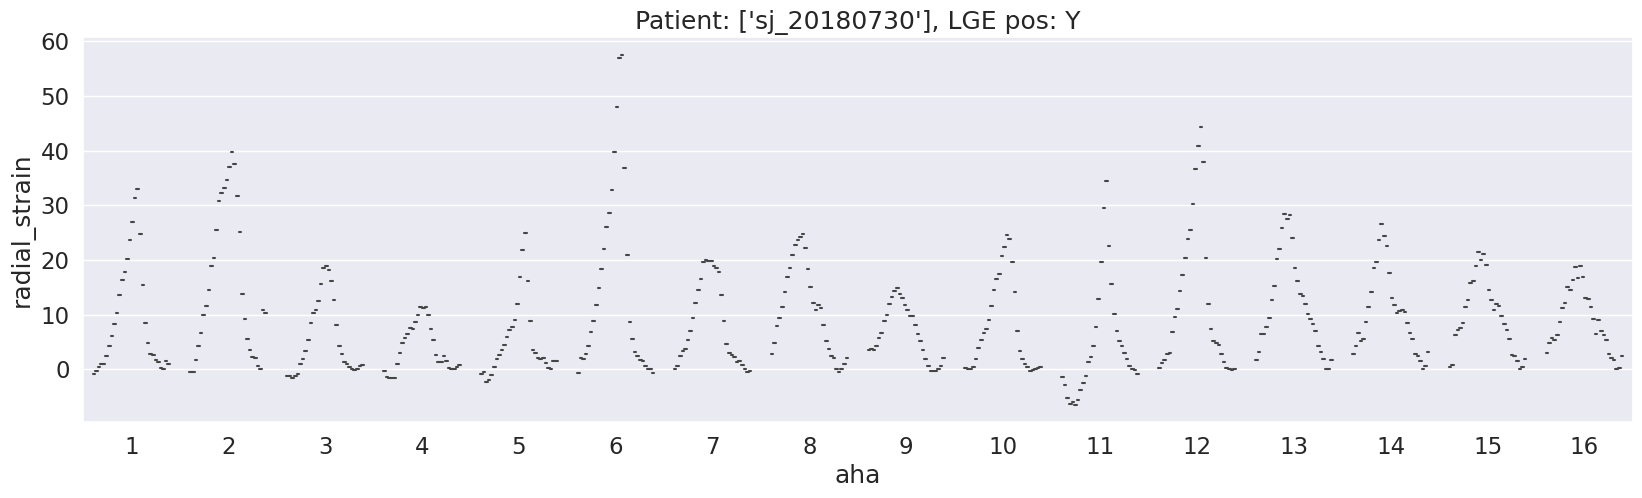

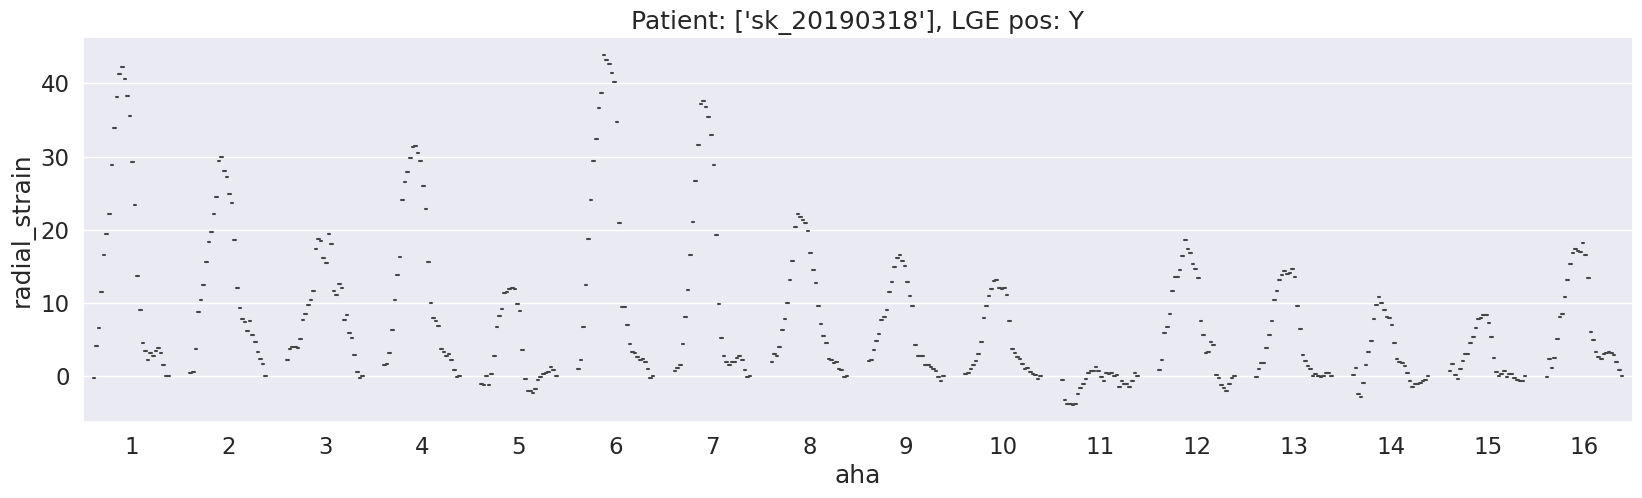

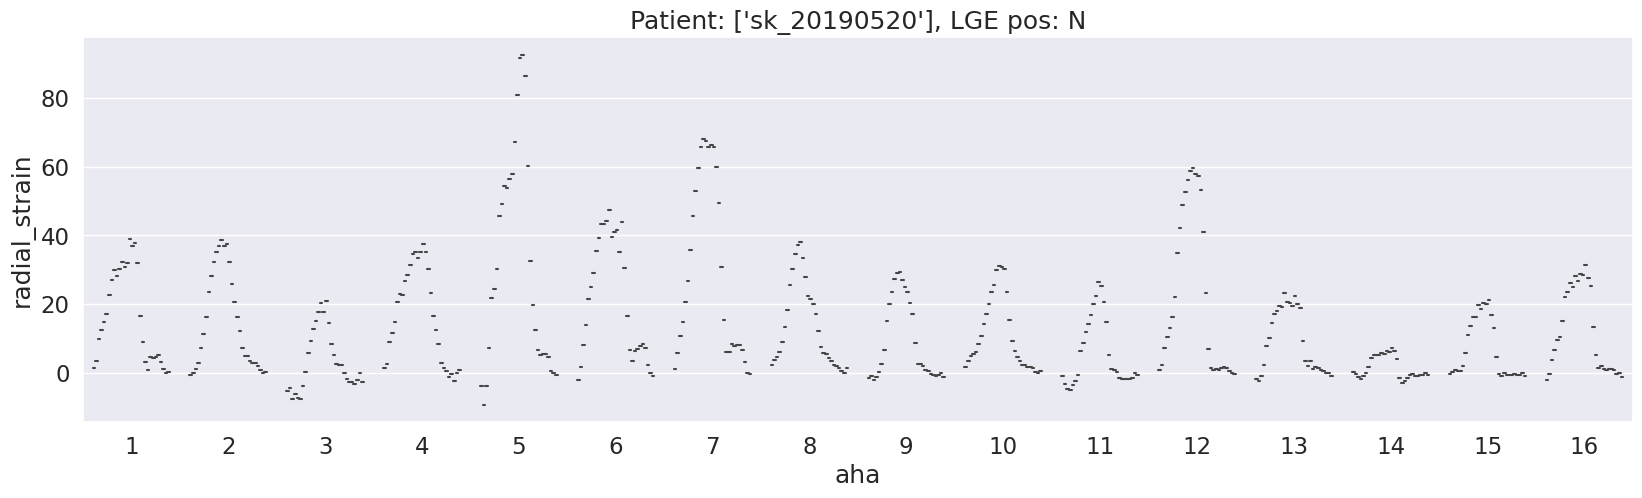

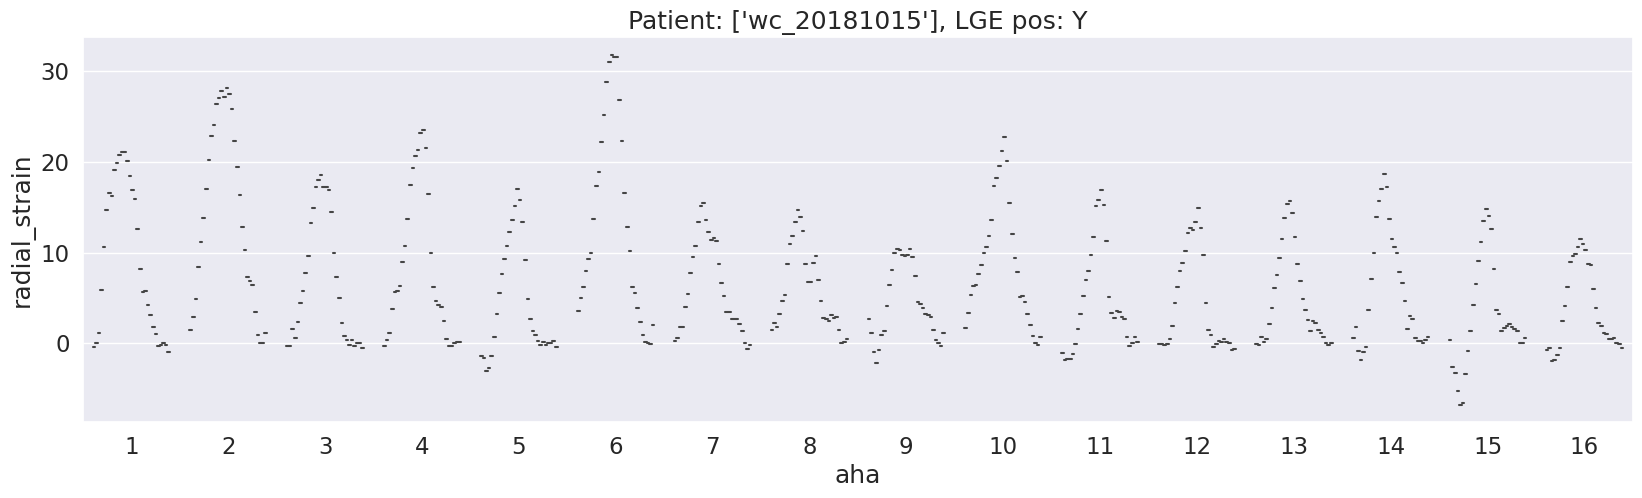

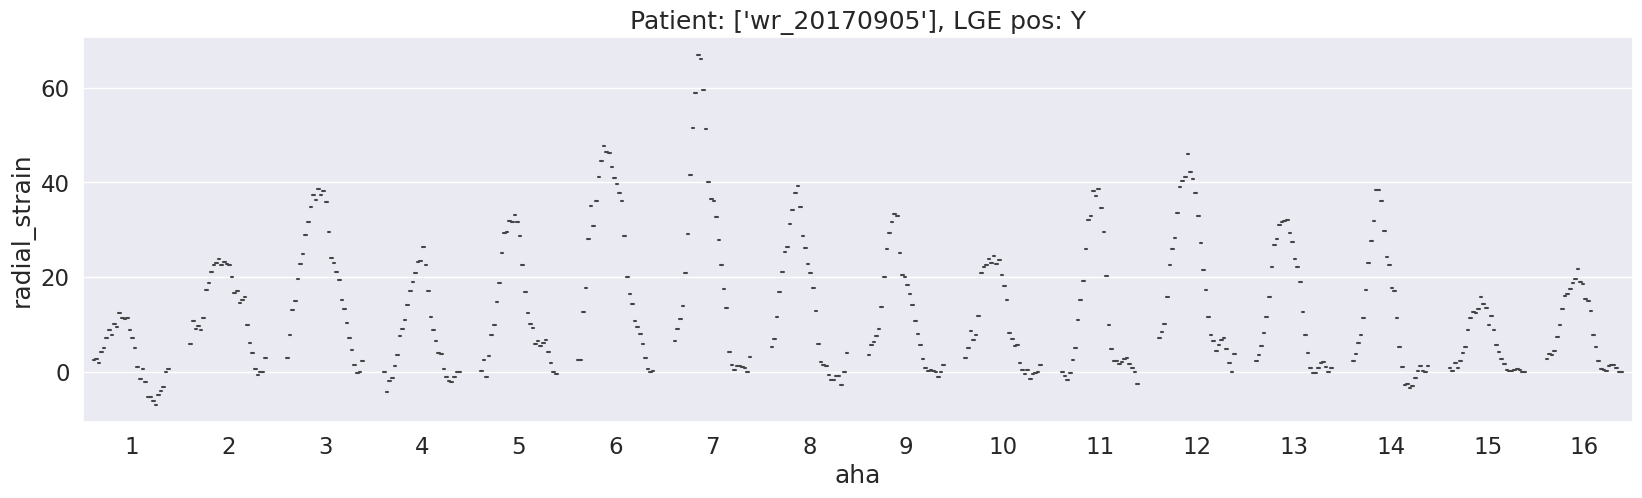

In [58]:
def plot_strain(df, segments=[1]):
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    plt.title('Patient: {}, LGE pos: {}'.format(segments, df[df['patient'].isin(segments)].target.values[0]))
    sb.violinplot(x="aha", y="radial_strain",inner='quart',
                     data=df[df['patient'].isin(segments)],
                  ax=ax,
                 hue='frame',
                  #scale_hue=True,
                 #split=True
                 )
    plt.legend([],[], frameon=False)
    plt.show()
_ = [plot_strain(df_merged, segments=[i]) for i in df_merged.patient.unique()]

In [10]:
df_merged.describe() # 27360 = 57 patients x 16 segments x 30 frames

aha  radial_strain   circ_strain  Participant Number  \
count  27360.000000   25920.000000  25920.000000        27360.000000   
mean       8.500000      13.579107     -7.649623           29.000000   
std        4.609856      17.096239      7.730509           16.452251   
min        1.000000     -20.510000    -34.678000            1.000000   
25%        4.750000       1.306750    -13.345000           15.000000   
50%        8.500000       7.220500     -5.669500           29.000000   
75%       12.250000      21.016750     -1.377750           43.000000   
max       16.000000     164.404000     45.347000           57.000000   

          Unique ID    Age at MRI           ED#           MS#           ES#  \
count  2.736000e+04  27360.000000  27360.000000  27360.000000  27360.000000   
mean   4.320642e+06     14.197563     30.140351      6.982456     13.631579   
std    2.898526e+06      3.160484      0.686693      0.713080      1.279162   
min    3.814370e+05      8.788889     29.000000      5.000000     10.000000   
25%    1.851147e+06     11.741667     30.000000      7.000000     13.000000   
50%    3.583054e+06     14.402778     30.000000      7.000000     13.000000   
75%    6.624293e+06     16.975000     31.000000      7.000000     14.000000   
max    9.953987e+06     22.225000     31.000000      9.000000     17.000000   

                PF#  ...   Height (cm)     BSA (m^2)    Heart Rate  \
count  27360.000000  ...  27360.000000  27360.000000  27360.000000   
mean      19.543860  ...    149.033333      1.496491     95.052632   
std        1.777772  ...     15.703771      0.362737     14.784592   
min       14.000000  ...    121.900000      0.680000     62.000000   
25%       18.000000  ...    135.600000      1.210000     86.000000   
50%       20.000000  ...    148.800000      1.520000     96.000000   
75%       20.000000  ...    161.300000      1.730000    103.000000   
max       24.000000  ...    182.000000      2.380000    138.000000   

       LV Ejection Fraction  LV end diastolic volume  LV end systolic volume  \
count          27360.000000              27360.00000            27360.000000   
mean               0.544035                108.77193               51.721053   
std                0.088058                 38.78306               27.871822   
min                0.340000                 54.00000               12.000000   
25%                0.490000                 83.00000               33.000000   
50%                0.550000                 94.00000               43.000000   
75%                0.600000                124.00000               60.000000   
max                0.780000                225.00000              148.000000   

        LV mass (g)  RV Ejection Fraction  RV end diastolic volume  \
count  27360.000000          27360.000000             27360.000000   
mean      67.403509              0.564561                99.631579   
std       26.196675              0.059681                26.795770   
min       27.000000              0.460000                58.000000   
25%       52.000000              0.520000                82.000000   
50%       59.000000              0.560000                93.000000   
75%       78.000000              0.600000               111.000000   
max      151.000000              0.740000               171.000000   

       RV end systolic volume  
count            27360.000000  
mean                43.684211  
std                 14.100348  
min                 19.000000  
25%                 33.000000  
50%                 41.000000  
75%                 51.000000  
max                 86.000000  

[8 rows x 27 columns]

In [9]:
df_merged.columns

Index(['pat', 'aha', 'frame', 'radial_strain', 'circ_strain',
       'Participant Number', 'Name',
       'Tarique -visual wall motion abnormality?', 'AHA segments',
       'Tarique -strain abnormality?', 'AHA segment from strain if different',
       'Unique ID', 'Study Date', 'Age at MRI', 'Gender', 'ED#', 'MS#', 'ES#',
       'PF#', 'MD#', '# of Phases',
       'Plain XML, Plain+strain XML, and Strain Calculations Exported',
       'Plain + LGE workspacexported', 'LGE TD location', 'LAX_ED', 'LAX_ES',
       'LAX_phases', 'Weight (kg)', 'Height (cm)', 'BSA (m^2)', 'Heart Rate',
       'BP', 'LV Ejection Fraction', 'LV end diastolic volume',
       'LV end systolic volume', 'LV mass (g)', 'RV Ejection Fraction',
       'RV end diastolic volume', 'RV end systolic volume',
       'LGE present? (y/n)',
       '% Involvement of LV myocardium (by mean+5xSD method)',
       'AHA segments with LGE',
       'Location, and Extent of Late Gadolinium Enhancement (LGE)',
       'Nocturnal BiPAP 

In [247]:
# Peak radial strain per patient
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((57,16))
x = np.max(x, axis=1)[:,None]
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

(57, 1)
********** Logistic Regression **********
[0.57142857 0.57142857 0.5        0.83333333 0.71428571]
F1: 0.64 (+/- 0.12) [Logistic Regression]
Recall: 0.64 (+/- 0.12) [Logistic Regression]
Accuracy: 0.58 (+/- 0.15) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.57142857 1.         0.33333333 0.85714286]
F1: 0.63 (+/- 0.14) [Random Forest]
Recall: 0.67 (+/- 0.24) [Random Forest]
Accuracy: 0.56 (+/- 0.10) [Random Forest]
********** naive Bayes **********
[1.         0.85714286 1.         0.66666667 0.85714286]
F1: 0.69 (+/- 0.06) [naive Bayes]
Recall: 0.88 (+/- 0.12) [naive Bayes]
Accuracy: 0.48 (+/- 0.04) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.57142857 1.         0.33333333 0.85714286]
F1: 0.65 (+/- 0.14) [scaled DecissionTree]
Recall: 0.67 (+/- 0.24) [scaled DecissionTree]
Accuracy: 0.60 (+/- 0.08) [scaled DecissionTree]


ValueError: The preferred dimensionality of the projected space `n_components` (2) cannot be greater than the given data dimensionality (1)!

(57, 2)
********** Logistic Regression **********
[0.42857143 0.57142857 0.83333333 0.66666667 0.57142857]
F1: 0.62 (+/- 0.10) [Logistic Regression]
Recall: 0.61 (+/- 0.13) [Logistic Regression]
Accuracy: 0.56 (+/- 0.11) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.42857143 0.66666667 0.66666667 0.71428571]
F1: 0.61 (+/- 0.10) [Random Forest]
Recall: 0.61 (+/- 0.10) [Random Forest]
Accuracy: 0.54 (+/- 0.12) [Random Forest]
********** naive Bayes **********
[1.         0.71428571 1.         0.66666667 0.85714286]
F1: 0.67 (+/- 0.06) [naive Bayes]
Recall: 0.85 (+/- 0.14) [naive Bayes]
Accuracy: 0.46 (+/- 0.03) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.42857143 0.5        0.66666667 0.28571429]
F1: 0.51 (+/- 0.10) [scaled DecissionTree]
Recall: 0.49 (+/- 0.13) [scaled DecissionTree]
Accuracy: 0.47 (+/- 0.11) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.42857143 0.33333333 0.33333333 0.28571429]
F1: 0.49 (+/- 0.09) [

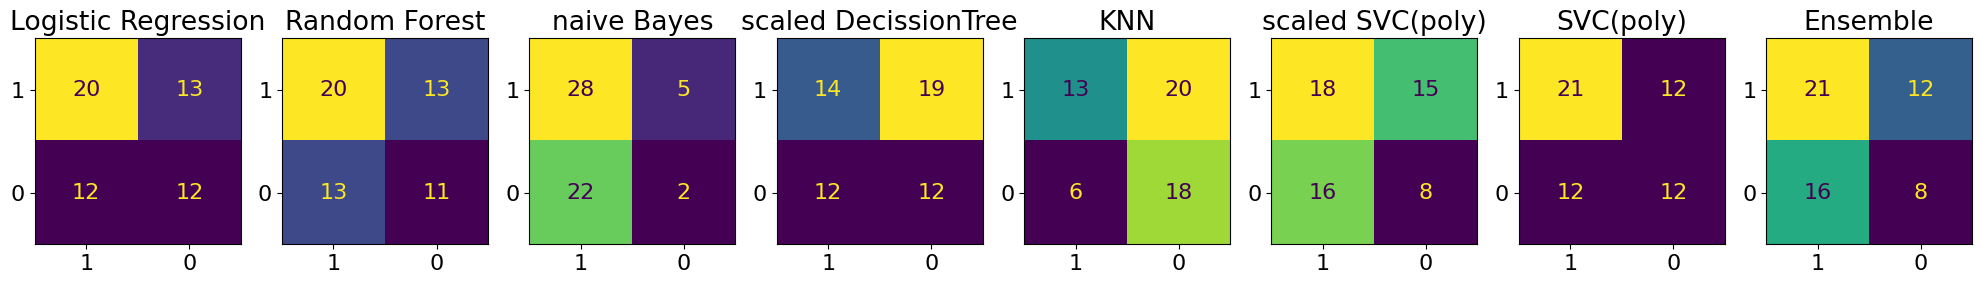

In [13]:
# Peak radial and circ strain per patient
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((57,16))
x = np.max(x, axis=1)
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((57,16))
x2 = np.max(x2, axis=1)
x = np.stack([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

In [130]:
# Peak radial strain per segment
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: max(list(x))).values).astype(np.float32).reshape((57,16))
print(x.shape)
x = np.nan_to_num(x)


(57, 16)


(57, 32)
********** Logistic Regression **********
[0.57142857 0.71428571 0.83333333 0.33333333 0.85714286]
F1: 0.69 (+/- 0.21) [Logistic Regression]
Recall: 0.66 (+/- 0.19) [Logistic Regression]
Accuracy: 0.65 (+/- 0.23) [Logistic Regression]
********** Random Forest **********
[0.85714286 0.71428571 0.66666667 0.5        0.71428571]
F1: 0.64 (+/- 0.12) [Random Forest]
Recall: 0.69 (+/- 0.11) [Random Forest]
Accuracy: 0.52 (+/- 0.16) [Random Forest]
********** naive Bayes **********
[0.57142857 0.71428571 0.66666667 0.83333333 0.71428571]
F1: 0.68 (+/- 0.08) [naive Bayes]
Recall: 0.70 (+/- 0.08) [naive Bayes]
Accuracy: 0.60 (+/- 0.13) [naive Bayes]
********** scaled DecissionTree **********
[0.71428571 0.57142857 0.33333333 0.5        0.42857143]
F1: 0.55 (+/- 0.07) [scaled DecissionTree]
Recall: 0.51 (+/- 0.13) [scaled DecissionTree]
Accuracy: 0.52 (+/- 0.07) [scaled DecissionTree]
********** KNN **********
[0.28571429 0.57142857 0.         0.83333333 0.57142857]
F1: 0.49 (+/- 0.28) 

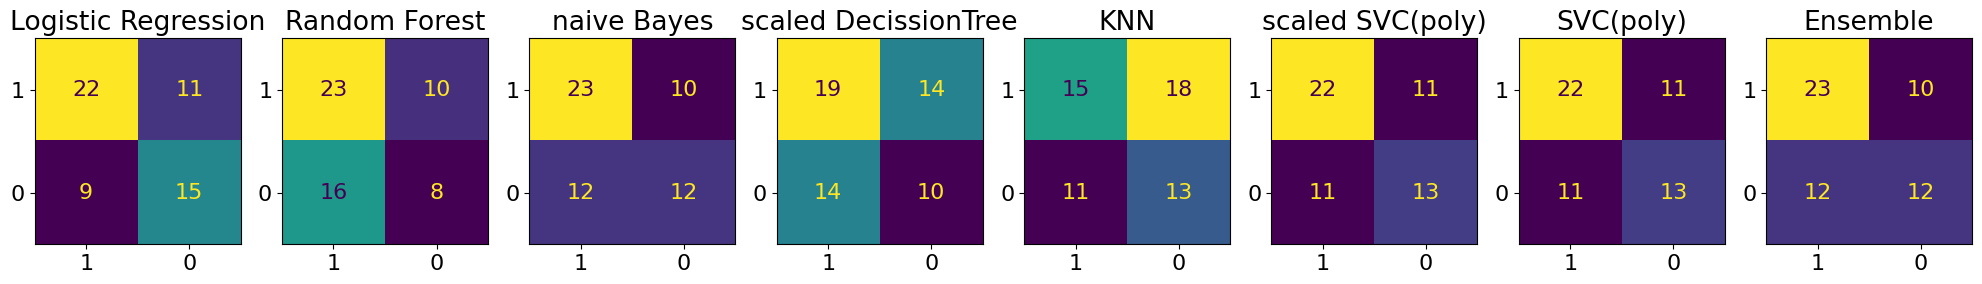

In [251]:
# Peak radial and circ strain per segment
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: max(list(x))).values).astype(np.float32).reshape((57,16))
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: min(list(x))).values).astype(np.float32).reshape((57,16))
x = np.concatenate([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

In [106]:
# radial strain per segment and frame 16 x 30
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['radial_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
print(x.shape)
x = np.nan_to_num(x)

(57, 480)


(57, 960)
********** Logistic Regression **********
[0.57142857 0.57142857 0.66666667 0.5        0.85714286]
F1: 0.57 (+/- 0.09) [Logistic Regression]
Recall: 0.63 (+/- 0.12) [Logistic Regression]
Accuracy: 0.42 (+/- 0.09) [Logistic Regression]
********** Random Forest **********
[0.71428571 1.         1.         0.66666667 1.        ]
F1: 0.68 (+/- 0.10) [Random Forest]
Recall: 0.88 (+/- 0.15) [Random Forest]
Accuracy: 0.46 (+/- 0.10) [Random Forest]
********** naive Bayes **********
[0.28571429 0.57142857 0.5        0.66666667 0.57142857]
F1: 0.56 (+/- 0.12) [naive Bayes]
Recall: 0.52 (+/- 0.13) [naive Bayes]
Accuracy: 0.56 (+/- 0.13) [naive Bayes]
********** scaled DecissionTree **********
[0.42857143 0.42857143 0.33333333 0.5        0.42857143]
F1: 0.50 (+/- 0.06) [scaled DecissionTree]
Recall: 0.42 (+/- 0.05) [scaled DecissionTree]
Accuracy: 0.52 (+/- 0.10) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.71428571 0.66666667 0.5        0.71428571]
F1: 0.67 (+/- 0.06)

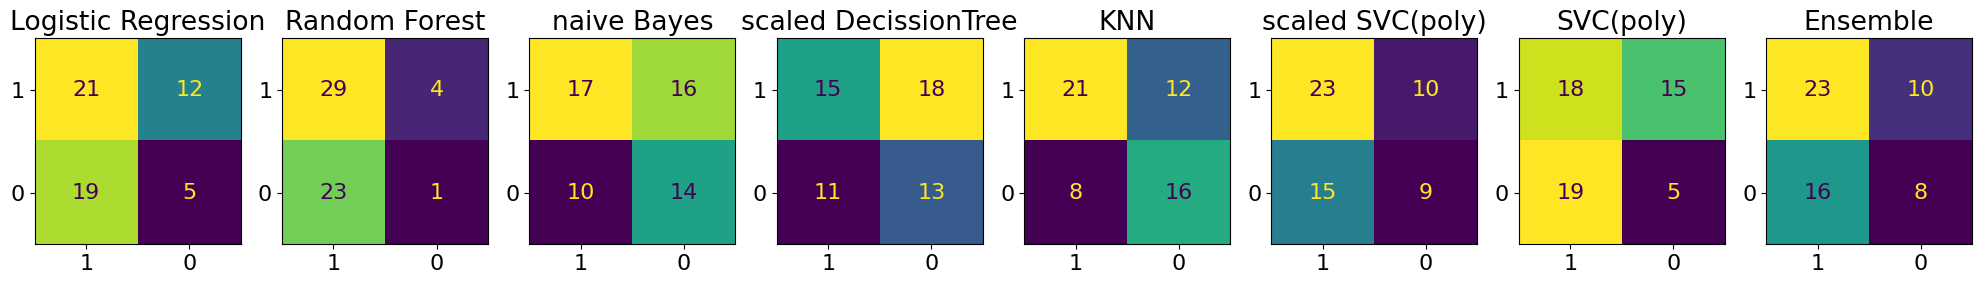

In [250]:
# radial and circ strain per segment and frame 16 x 30
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['radial_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['circ_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x = np.concatenate([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

In [12]:
y = (df_merged[df_merged.frame==0].sort_values(['pat']).groupby('pat')['target'].apply(lambda x: list(x)[0]).values=='Y').astype(int) # 57 patients
print(y.shape)

(57,)


In [108]:
y

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

********** Logistic Regression **********
[0.42857143 0.57142857 0.83333333 0.66666667 0.57142857]
F1: 0.62 (+/- 0.10) [Logistic Regression]
Recall: 0.61 (+/- 0.13) [Logistic Regression]
Accuracy: 0.56 (+/- 0.11) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.42857143 0.66666667 0.66666667 0.71428571]
F1: 0.61 (+/- 0.10) [Random Forest]
Recall: 0.61 (+/- 0.10) [Random Forest]
Accuracy: 0.54 (+/- 0.12) [Random Forest]
********** naive Bayes **********
[1.         0.71428571 1.         0.66666667 0.85714286]
F1: 0.67 (+/- 0.06) [naive Bayes]
Recall: 0.85 (+/- 0.14) [naive Bayes]
Accuracy: 0.46 (+/- 0.03) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.57142857 0.5        0.33333333 0.28571429]
F1: 0.50 (+/- 0.13) [scaled DecissionTree]
Recall: 0.45 (+/- 0.12) [scaled DecissionTree]
Accuracy: 0.49 (+/- 0.14) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.42857143 0.33333333 0.33333333 0.28571429]
F1: 0.49 (+/- 0.09) [KNN]
Rec

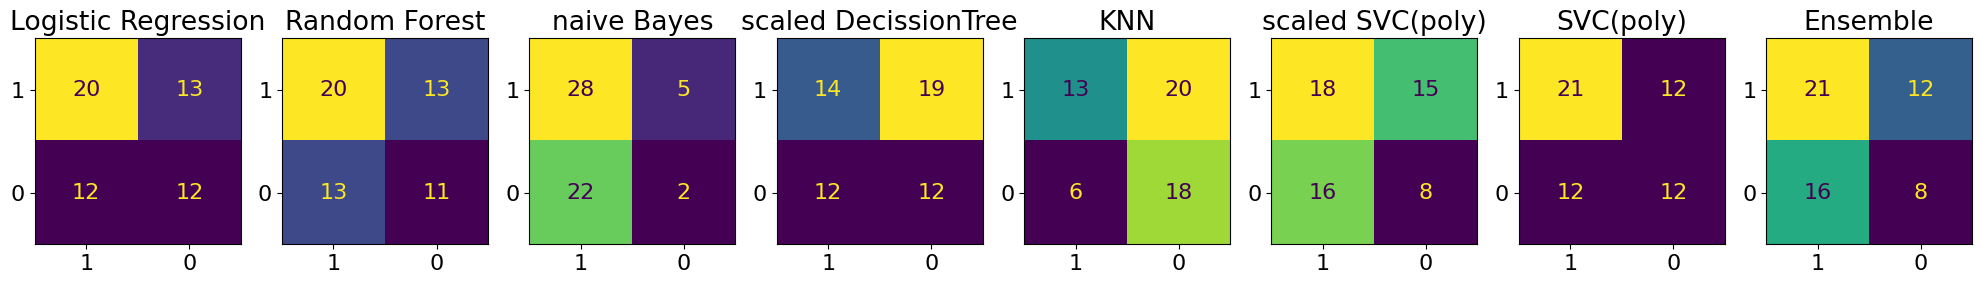

In [246]:
cross_validate_f1(x,y)